In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from pprint import pprint

from functions.request_data import __request_data
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth
from functions.compute_adr_pfo import __compute_adr_pfo
from functions.add_radial_and_transverse_channel import __add_radial_and_transverse_channel

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __makeplot(config, st):


    st_in = st.copy()

    fig, ax = plt.subplots(6,1, figsize=(15,10), sharex=True)

    font = 14

    time_scaling, time_unit = 1, "sec"
    rot_scaling = 1e9
    trans_scaling = 1e6

    for i, tr in enumerate(st_in):

        if i in [0,1,2]:
            ax[i].set_ylabel(r"$\omega$ (nrad/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*rot_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        elif i in [3,4,5]:
            ax[i].set_ylabel(r"u ($\mu$m/s)", fontsize=font)
            ax[i].plot(tr.times()/time_scaling, tr.data*trans_scaling, 'k', label=tr.stats.station+"."+tr.stats.channel)

        ax[i].legend(loc=1)

    ax[5].set_xlabel(f"Time ({time_unit}) from {st[0].stats.starttime.date} {str(st[0].stats.starttime.time).split('.')[0]} UTC", fontsize=font)
    ax[0].set_title(config['title']+f" | {config['fmin']} - {config['fmax']} Hz", fontsize=font, pad=10)

    plt.show();
    del st_in
    return fig

In [4]:
def __empty_stream(reference_stream):

    from numpy import ones
    from obspy import Stream, Trace

    t_ref = reference_stream[0]

    empty = Stream()

    for cha in ["BHZ", "BHN", "BHE"]:
        t = Trace()
        t.data = ones(len(t_ref))
        t.stats.sampling_rate = t_ref.stats.sampling_rate
        t.stats.starttime = t_ref.stats.starttime
        t.stats.network, t.stats.station, t.stats.channel = "PY", "RPFO", cha
        empty += t

    return empty

In [5]:
def __stream_to_dataframe(st):

    dff = pd.DataFrame()

    for tr in st:
        name = f"{tr.stats.station}_{tr.stats.location}_{tr.stats.channel}"
        dff[name] = tr.data

    return dff

In [6]:
config = {}

## location of BSPF
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## path for figures to store
config['outpath_figs'] = data_path+"BSPF/figures/SNR/"

##
config['translation_type'] = "ACC"  ## ACC / DISP

## path for output data
config['outpath_data'] = data_path+"BSPF/data/"

config['path_to_mseed'] = data_path+f"BSPF/data/waveforms/{config['translation_type'].upper()}/"

## blueSeis sensor (@200Hz)
# config['seed_blueseis'] = "PY.BSPF..HJ*"

## Trillium 240 next to BlueSeis on Pier (@40Hz)
# config['seed_seismometer1'] = "II.PFO.10.BH*"

## STS2 next to BlueSeis (@200Hz)
# config['seed_seismometer2'] = "PY.PFOIX..HH*"

config['path_to_catalog'] = data_path+"BSPF/data/catalogs/"

config['catalog'] = "BSPF_catalog_20221001_20230930_triggered.pkl"
# config['catalog'] = "BSPF_catalog_20221001_20231001_triggered.pkl"

## Event Info

In [7]:
## read data frame of selected triggered events
events = pd.read_pickle(config['path_to_catalog']+config['catalog'])

## add column for hypocenter distance
events['Hdistance_km'] = np.sqrt(events['distances_km']**2 + (events['depth']/1000)**2)

events

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km,Hdistance_km
0,2022-10-01 05:36:11.240,33.489667,-116.507167,9120.0,1.13,ml,20171.24,2022-10-01T05:36:10.344538Z,2022-10-01T05:36:11.240000Z,2022-10-01T05:36:11.240000Z,6.0,199.712618,14.252022,16.920240
1,2022-10-01 21:26:43.530,33.978000,-116.730500,15130.0,2.08,ml,77203.53,2022-10-01T21:26:51.594539Z,2022-10-01T21:26:43.530000Z,2022-10-01T21:26:43.530000Z,6.0,328.065144,48.053535,50.379154
2,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,98716.44,2022-10-02T03:25:19.219539Z,2022-10-02T03:25:16.440000Z,2022-10-02T03:25:16.440000Z,6.0,199.394033,14.850966,16.887652
3,2022-10-02 15:51:37.180,33.480167,-116.398000,8240.0,1.68,ml,143497.18,2022-10-02T15:51:39.919539Z,2022-10-02T15:51:37.180000Z,2022-10-02T15:51:37.180000Z,6.0,159.749086,15.423592,17.486703
4,2022-10-02 21:52:54.280,33.485333,-116.509333,9650.0,0.99,ml,165174.28,2022-10-02T21:52:57.319539Z,2022-10-02T21:52:54.280000Z,2022-10-02T21:52:54.280000Z,6.0,199.820062,14.772415,17.645021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,2023-09-21 01:58:24.210,33.545833,-116.455000,4870.0,0.68,ml,30679104.21,2023-09-21T01:58:25.860000Z,2023-09-21T01:58:24.210000Z,2023-09-21T01:58:24.210000Z,4.0,179.675029,7.188470,8.682799
402,2023-09-21 21:26:10.420,34.031000,-116.912500,14140.0,2.26,ml,30749170.42,2023-09-21T21:26:20.975000Z,2023-09-21T21:26:22.103722Z,2023-09-21T21:26:10.420000Z,4.0,317.902461,62.963464,64.531678
403,2023-09-22 09:48:22.760,33.270167,-116.781000,11290.0,1.72,ml,30793702.76,2023-09-22T09:48:28.755000Z,2023-09-22T09:48:22.760000Z,2023-09-22T09:48:22.760000Z,4.0,218.807178,48.399101,49.698462
404,2023-09-27 13:41:07.510,33.496500,-116.556833,13430.0,1.18,ml,31239667.51,2023-09-27T13:41:10.945000Z,2023-09-27T13:41:07.510000Z,2023-09-27T13:41:07.510000Z,5.0,216.668239,15.777807,20.719655


## RUN LOOP

In [33]:
def __get_maximum_frequency(st):

    from numpy import argmax

    def __multitaper_psd(arr, dt, n_win=5, time_bandwidth=4.0):

        import multitaper as mt

        out_psd = mt.MTSpec(arr, nw=time_bandwidth, kspec=n_win, dt=dt, iadapt=2)

        _f, _psd = out_psd.rspec()

        f = _f.reshape(_f.size)
        psd = _psd.reshape(_psd.size)

        return f, psd

    fmax = {}
    for tr in st:
        _f, _psd = __multitaper_psd(tr.data, tr.stats.delta)
        fmax[f"{tr.stats.station}_{tr.stats.channel[-1]}"] = round(_f[argmax(_psd)], 3)

    return fmax

In [38]:
def __compute_fmax(header, st_in, out_lst, trigger_time):

    from numpy import nan

    st_in = st_in.sort()

    st_in = st_in.detrend("demean")
    st_in = st_in.taper(0.01)
    st_in = st_in.filter("bandpass", freqmin=1.0, freqmax=50.0, corners=4, zerophase=True)

    _fmax = __get_maximum_frequency(st_in)

    out = {}
    for ii, h in enumerate(header):
        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]
        try:
            out[h+"_fmax"] = _fmax[f"{sta}_{cha}"]
        except:
            out[h+"_fmax"] = nan
            print(f" -> fmax: {h} adding nan")
    return out

In [28]:
def __compute_Amax(header, st_in, out_lst, trigger_time, win_length_sec):

    from numpy import ones, nan, nanargmax, argmax
    from obspy import UTCDateTime

    st_in = st_in.sort()

    st_in = st_in.detrend("demean")
    st_in = st_in.taper(0.01)
    st_in = st_in.filter("bandpass", freqmin=1.0, freqmax=50.0, corners=4, zerophase=True)


    ## get relative samples of signal window
    t_rel_sec = abs(UTCDateTime(trigger_time)-st[0].stats.starttime)

    df = st[0].stats.sampling_rate  ## sampling rate

    NN = int(df * win_length_sec) ## samples

    n_rel_spl = t_rel_sec * df ## samples

    n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)

    ## find index of maximum for PFO Z
    tr_ = st_in.select(station="PFO*", location="10", channel=f"*R")[0]
    max_idx = argmax(abs(tr_.data[n_signal_1:n_signal_2]))

    ## samples offset around maximum
    n_off = int(0.1 * df)

    out = {}
    for ii, h in enumerate(header):
        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]
        try:
            tr = st_in.select(station=sta, location=loc, channel=f"*{cha}")[0]
            out[h+"_amax"] = max(abs(tr.data[n_signal_1+max_idx-n_off:n_signal_1+max_idx+n_off]))
            # out[h+"_amax"] = max(abs(tr.data[n_signal_1+max_idx]))
        except:
            out[h+"_amax"] = nan
            print(f" -> amax: {h} adding nan")

    return out

In [11]:
def __compute_SNR(header, st_in, out_lst, trigger_time, win_length_sec=10, plot=False, plot_save=False):

    from numpy import nanmean, sqrt, isnan, ones, nan, nanpercentile, nanargmax, argmax
    from obspy import UTCDateTime

    st_in = st_in.sort()
    st_in = st_in.detrend("demean")
    st_in = st_in.taper(0.01)
    st_in = st_in.filter("bandpass", freqmin=1.0, freqmax=40.0, corners=4, zerophase=True)

    if plot or plot_save:
        fig, ax = plt.subplots(len(st_in), 1, figsize=(15, 15), sharex=True)

    out = {}
    for ii, h in enumerate(header):

        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]

        try:
            tr = st_in.select(station=sta, location=loc, channel=f"*{cha}")[0]
        except:
            out[h+"_snr"] = nan

        t_rel_sec = abs(UTCDateTime(trigger_time)-tr.stats.starttime)

        df = tr.stats.sampling_rate

        NN = int(df * win_length_sec) ## samples

        n_rel_spl = t_rel_sec * df ## samples

        n_offset = df * 2 ## samples

        n_noise_1, n_noise_2 = int(n_rel_spl-NN-n_offset), int(n_rel_spl-n_offset)
        n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)

        ## noise, signal and ratio using mean
        # noise = nanmean(tr.data[n_noise_1:n_noise_2]**2)
        # signal = nanmean(tr.data[n_signal_1:n_signal_2]**2)
        # out[h+"_snr"] = sqrt(signal/noise)

        ## find index of maximum for PFO Z
        # tr_ = st_in.select(station="PFO*", location="10", channel=f"*R")[0]
        tr_ = st_in.select(station="PFO*", channel=f"*R")[0]
        max_idx = argmax(abs(tr_.data[n_signal_1:n_signal_2]))

        ## samples offset around maximum
        n_off = int(1 * df)


        ## noise, signal and ratio using percentile
        try:
            noise = nanpercentile(abs(tr.data[n_noise_1:n_noise_2]), 99.)
            signal = nanpercentile(abs(tr.data[n_signal_1:n_signal_2]), 99.)
            out[h+"_snr"] = signal/noise
        except:
            out[h+"_snr"] = nan
            print(f" -> snr: {h} adding nan")


        if plot or plot_save:

            if ii < len(st_in):

                scaling = 1


                ax[ii].plot(abs(tr.data)*scaling, label=f"{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}")

                ax[ii].legend(loc=1)

                ## signal period
                ax[ii].axvline(n_rel_spl, color="g")
                ax[ii].axvline(n_rel_spl+NN, color="g")

                # ax[ii].axhline(signal*scaling, n_rel_spl, n_rel_spl+NN, color="g", ls="--", zorder=3)

                ## noise period
                ax[ii].axvline(n_rel_spl-n_offset, color="r")
                ax[ii].axvline(n_rel_spl-NN-n_offset, color="r")

                # ax[ii].axhline(noise*scaling, n_rel_spl-n_offset, n_rel_spl-NN-n_offset, color="r", ls="--", zorder=3)

                maximal_value = abs(tr.data[n_signal_1+max_idx])
                ax[ii].scatter(n_signal_1+max_idx, maximal_value*scaling, color="tab:orange", alpha=0.7)


                ## OLD window picking
                # maximal_idx = nanargmax(abs(tr.data[n_signal_1+max_idx-n_off:n_signal_1+max_idx+n_off]))
                # maximal_value = abs(tr.data[n_signal_1+max_idx-n_off+maximal_idx])
                # ax[ii].scatter(maximal_idx+n_signal_1+max_idx-n_off, maximal_value*scaling, color="tab:orange", alpha=0.7)

                # ax[ii].axvline(n_signal_1+max_idx-n_off, color="orange")
                # ax[ii].axvline(n_signal_1+max_idx+n_off, color="orange")
                # ax[ii].axvline(n_signal_1+max_idx-n_off+maximal_idx, color="orange", ls="--")

                ax[ii].set_ylim(bottom=-0)

    if plot:
        plt.show();

    if plot_save:
        fig.savefig(config['outpath_figs']+f"SNR_{st_in[0].stats.starttime}.png", format="png", dpi=200, bbox_inches='tight')
        plt.close();

    return out

In [12]:
def __compute_adr_snr(header, st_in, out_lst, trigger_time, method="maximum", win_length_sec=10):

    from numpy import ones, nan, argmax, nanpercentile, nanmax, nanmean
    from obspy import UTCDateTime

    st_in = st_in.copy().sort()

    st_in = st_in.detrend("demean")

    bspf_i = st_in.select(station="BSPF").copy()
    bspf_a = st_in.select(station="BSPF").copy()
    bspf_m = st_in.select(station="BSPF").copy()

    for tr in bspf_a:
        tr.stats.location = "al"
    for tr in bspf_m:
        tr.stats.location = "mi"
    for tr in bspf_i:
        tr.stats.location = "in"

    pfo_i = st_in.select(station="PFO*").copy()
    pfo_a = st_in.select(station="PFO*").copy()
    pfo_m = st_in.select(station="PFO*").copy()

    for tr in pfo_a:
        tr.stats.location = "al"
    for tr in pfo_m:
        tr.stats.location = "mi"
    for tr in pfo_i:
        tr.stats.location = "in"

    adr_i = st_in.select(station="RPFO", location="in").copy()
    adr_a = st_in.select(station="RPFO", location="al").copy()
    adr_m = st_in.select(station="RPFO", location="mi").copy()

    bspf_a = bspf_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)
    adr_a = adr_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)
    pfo_a = pfo_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)

    bspf_i = bspf_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)
    adr_i = adr_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)
    pfo_i = pfo_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)

    bspf_m = bspf_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)
    adr_m = adr_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)
    pfo_m = pfo_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)



    bspf_a.detrend("linear")
    adr_a.detrend("linear")
    pfo_a.detrend("linear")

    bspf_i.detrend("linear")
    adr_i.detrend("linear")
    pfo_i.detrend("linear")

    adr_m.detrend("linear")
    adr_m.detrend("linear")
    pfo_m.detrend("linear")

    st0 = adr_i
    st0 += bspf_i
    st0 += pfo_i

    st0 += bspf_a
    st0 += adr_a
    st0 += pfo_a

    st0 += bspf_m
    st0 += adr_m
    st0 += pfo_m



    ## get relative samples of signal window
    t_rel_sec = abs(UTCDateTime(trigger_time)-st[0].stats.starttime)

    df = st[0].stats.sampling_rate  ## sampling rate

    NN = int(df * win_length_sec) ## samples

    n_rel_spl = t_rel_sec * df ## samples


    n_offset = df * 2 ## samples

    n_noise_1, n_noise_2 = int(n_rel_spl-NN-n_offset), int(n_rel_spl-n_offset)
    n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)


    out = {}
    for ii, h in enumerate(header):

        if h == "origin":
            continue

        ## noise, signal and ratio using percentile
        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]
        try:
            tr = st0.select(station=sta, location=loc, channel=f"*{cha}")[0]

            if method == "percentile":
                noise = nanpercentile(abs(tr.data[n_noise_1:n_noise_2]), 99)
                signal = nanpercentile(abs(tr.data[n_signal_1:n_signal_2]), 99)
            elif method == "maximum":
                noise = nanmax(abs(tr.data[n_noise_1:n_noise_2]))
                signal = nanmax(abs(tr.data[n_signal_1:n_signal_2]))
            elif method == "mean":
                noise = nanmean(abs(tr.data[n_noise_1:n_noise_2]))
                signal = nanmean(abs(tr.data[n_signal_1:n_signal_2]))

            out[h] = signal/noise
        except:
            out[h] = nan
            print(f" -> snr: {h} adding nan")

    return out

In [13]:
def __compute_adr_max(header, st_in, out_lst, trigger_time, win_length_sec):

    from numpy import ones, nan, argmax
    from obspy import UTCDateTime

    st_in = st_in.copy().sort()

    st_in = st_in.detrend("demean")

    bspf_i = st_in.select(station="BSPF").copy()
    bspf_a = st_in.select(station="BSPF").copy()
    bspf_m = st_in.select(station="BSPF").copy()
    adr_i = st_in.select(station="RPFO", location="in").copy()
    adr_a = st_in.select(station="RPFO", location="al").copy()
    adr_m = st_in.select(station="RPFO", location="mi").copy()

    bspf_a = bspf_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)
    adr_a = adr_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)

    bspf_i = bspf_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)
    adr_i = adr_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)

    bspf_m = bspf_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)
    adr_m = adr_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)

    for tr in bspf_a:
        tr.stats.location = "al"
    for tr in bspf_m:
        tr.stats.location = "mi"
    for tr in bspf_i:
        tr.stats.location = "in"

    bspf_a.detrend("linear")
    adr_a.detrend("linear")

    bspf_i.detrend("linear")
    adr_i.detrend("linear")

    adr_m.detrend("linear")
    adr_m.detrend("linear")

    st0 = adr_i
    st0 += bspf_i

    st0 += bspf_a
    st0 += adr_a

    st0 += bspf_m
    st0 += adr_m


    ## get relative samples of signal window
    t_rel_sec = abs(UTCDateTime(trigger_time)-st[0].stats.starttime)

    df = st[0].stats.sampling_rate  ## sampling rate

    NN = int(df * win_length_sec) ## samples

    n_rel_spl = t_rel_sec * df ## samples

    n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)


    ## find index of maximum for PFO Z
    tr_ = st_in.select(station="PFO*", location="10", channel=f"*T")[0]
    max_idx = argmax(abs(tr_.data[n_signal_1:n_signal_2]))

    ## samples offset around maximum
    n_off = int(0.1 * df)


    out = {}
    for ii, h in enumerate(header):

        if h == "origin":
            continue

        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]
        try:
            tr = st0.select(station=sta, location=loc, channel=f"*{cha}")[0]
            out[h] = max(abs(tr.data[n_signal_1+max_idx-n_off:n_signal_1+max_idx+n_off]))
        except Exception as e:
            out[h] = nan
            print(f" -> adr: {h} adding nan")

    return out

In [14]:
def __compute_adr_cc(header, st_in, out_lst, trigger_time, win_length_sec):

    from numpy import ones, nan, argmax
    from obspy import UTCDateTime
    from obspy.signal.cross_correlation import correlate

    st_in = st_in.copy().sort()

    st_in = st_in.detrend("demean")

    bspf_i = st_in.select(station="BSPF").copy()
    bspf_a = st_in.select(station="BSPF").copy()
    bspf_m = st_in.select(station="BSPF").copy()
    adr_i = st_in.select(station="RPFO", location="in").copy()
    adr_a = st_in.select(station="RPFO", location="al").copy()
    adr_m = st_in.select(station="RPFO", location="mi").copy()


    bspf_a = bspf_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)
    adr_a = adr_a.filter("bandpass", freqmin=0.1, freqmax=0.5, corners=8, zerophase=True)

    bspf_i = bspf_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)
    adr_i = adr_i.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=8, zerophase=True)

    bspf_m = bspf_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)
    adr_m = adr_m.filter("bandpass", freqmin=0.5, freqmax=1.0, corners=8, zerophase=True)

    for tr in bspf_a:
        tr.stats.location = "al"
    for tr in bspf_m:
        tr.stats.location = "mi"
    for tr in bspf_i:
        tr.stats.location = "in"

    bspf_a.detrend("linear")
    adr_a.detrend("linear")

    bspf_i.detrend("linear")
    adr_i.detrend("linear")

    adr_m.detrend("linear")
    adr_m.detrend("linear")

    st0 = adr_i
    st0 += bspf_i

    st0 += bspf_a
    st0 += adr_a

    st0 += bspf_m
    st0 += adr_m


    ## get relative samples of signal window
    t_rel_sec = abs(UTCDateTime(trigger_time)-st[0].stats.starttime)

    df = st[0].stats.sampling_rate  ## sampling rate

    NN = int(df * win_length_sec) ## samples

    n_rel_spl = t_rel_sec * df ## samples

    n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)


    ## find index of maximum for PFO
    tr_ = st_in.select(station="PFO*", location="10", channel=f"*T")[0]
    max_idx = argmax(abs(tr_.data[n_signal_1:n_signal_2]))

    ## samples offset around maximum
    n_off = int(1 * df)

    _i1, _i2 = n_signal_1+max_idx-n_off, n_signal_1+max_idx+n_off

    # print(st0.__str__(extended=True))

    out = {}
    for ii, h in enumerate(header):

        if h == "origin":
            continue

        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]

        try:
            tr_ref = st0.select(station="BSPF", location=loc, channel=f"*{cha}")[0]
            tr = st0.select(station=sta, location=loc, channel=f"*{cha}")[0]
            # out[h] = round(max(correlate(tr_ref.data[n_signal_1:n_signal_2], tr.data[n_signal_1:n_signal_2], 0)), 1)
            out[h] = round(max(correlate(tr_ref.data[_i1:_i2], tr.data[_i1:_i2], 0)), 1)

        except Exception as e:
            # print("cc error:" + e)
            out[h] = nan
            print(f" -> cc: {h} adding nan")

    return out

In [42]:
config['mseed_files'] = sorted([file for file in os.listdir(config['path_to_mseed'])])


## create dataframe for output
out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["Mag_type"] = events.type
out_df["BAZ"] = events.backazimuth
out_df["Edistance_km"] = events.distances_km
out_df["Hdistance_km"] = events.Hdistance_km

tmp_events = [str(ee).split(".")[0] for ee in events.origin]

data_amax, data_fmax, data_snr, data_adr_snr, data_adr, skipped, nan_row = [], [], [], [], [], 0, 0

## pre-define header for data frames
header = ['BSPF__E','BSPF__N','BSPF__R','BSPF__T','BSPF__Z',
          'PFO_10_E','PFO_10_N','PFO_10_R','PFO_10_T','PFO_10_Z',
          'RPFO_al_E','RPFO_al_N','RPFO_al_Z',
          'RPFO_in_E','RPFO_in_N','RPFO_in_Z',
          'RPFO_mi_E','RPFO_mi_N','RPFO_mi_Z'
         ]

## prepare dataframes
header_amax = [h+"_amax" for h in header]
header_amax.insert(0, "origin")
df_amax = pd.DataFrame(columns=header_amax)

header_fmax = [h+"_fmax" for h in header]
header_fmax.insert(0, "origin")
df_fmax = pd.DataFrame(columns=header_fmax)

header_snr = [h+"_snr" for h in header]
header_snr.insert(0, "origin")
df_snr = pd.DataFrame(columns=header_snr)

header_adr_snr = []
for hh in ["BSPF_al_N_snr", "BSPF_al_E_snr", "BSPF_al_Z_snr", "BSPF_al_T_snr", "BSPF_al_R_snr",
           "BSPF_mi_N_snr", "BSPF_mi_E_snr", "BSPF_mi_Z_snr", "BSPF_mi_T_snr", "BSPF_mi_R_snr",
           "BSPF_in_N_snr", "BSPF_in_E_snr", "BSPF_in_Z_snr", "BSPF_in_T_snr", "BSPF_in_R_snr",
           "PFO_in_N_snr", "PFO_in_E_snr", "PFO_in_Z_snr",
           "PFO_al_N_snr", "PFO_al_E_snr", "PFO_al_Z_snr",
           "PFO_mi_N_snr", "PFO_mi_E_snr", "PFO_mi_Z_snr",
           "RPFO_in_N_snr", "RPFO_in_E_snr", "RPFO_in_Z_snr",
           "RPFO_al_N_snr", "RPFO_al_E_snr", "RPFO_al_Z_snr",
           "RPFO_mi_N_snr", "RPFO_mi_E_snr", "RPFO_mi_Z_snr"]:
    header_adr_snr.append(hh)


header_adr = []
for hh in ["BSPF_al_N_adr", "BSPF_al_E_adr", "BSPF_al_Z_adr", "BSPF_al_T_adr", "BSPF_al_R_adr",
           "BSPF_mi_N_adr", "BSPF_mi_E_adr", "BSPF_mi_Z_adr", "BSPF_mi_T_adr", "BSPF_mi_R_adr",
           "BSPF_in_N_adr", "BSPF_in_E_adr", "BSPF_in_Z_adr", "BSPF_in_T_adr", "BSPF_in_R_adr",
           "RPFO_in_N_adr", "RPFO_in_E_adr", "RPFO_in_Z_adr",
           "RPFO_al_N_adr", "RPFO_al_E_adr", "RPFO_al_Z_adr",
           "RPFO_mi_N_adr", "RPFO_mi_E_adr", "RPFO_mi_Z_adr"]:
    header_adr.append(hh)

# header_adr = [h+"_adr" for h in header]
header_adr.insert(0, "origin")
df_adr = pd.DataFrame(columns=header_adr)

df_adr_cc = pd.DataFrame(columns=header_adr)

header_adr_snr.insert(0, "origin")
df_adr_snr = pd.DataFrame(columns=header_adr_snr)


# for event in tqdm(config['mseed_files'][:10]):
for event in tqdm(config['mseed_files']):

    yy = int(event.replace(".","_").split("_")[1][:4])
    mm = int(event.replace(".","_").split("_")[1][4:6])
    dd = int(event.replace(".","_").split("_")[1][6:8])
    h = int(event.replace(".","_").split("_")[2][0:2])
    m = int(event.replace(".","_").split("_")[2][2:4])
    s = int(event.replace(".","_").split("_")[2][4:6])

    otime = f"{yy}-{mm:02d}-{dd:02d} {h:02d}:{m:02d}:{s:02d}"


    if otime not in tmp_events:
        skipped += 1
        continue
    else:
        jj = tmp_events.index(otime)

#     print(f"\n -> {jj} {events.origin[jj]} ")

    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]


    try:

        st = obs.read(config['path_to_mseed']+event)

        ## resample all to 40 Hz
        st = st.resample(40, no_filter=False)

        st = st.sort();

        ## rename PFOIX events to make compatible
        for tr in st:
            if "PFOIX" in tr.stats.station:
                tr.stats.station = "PFO"
                tr.stats.location = "10"

        # for tr in st:
        #     if "BSPF" in tr.stats.station:
        #         tr.data = np.roll(tr.data, 4)

        ## add radial and transverse channels
        st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
        st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])

        if len(st) != 19:
            print(f"{len(st)} is not 19")

        ## processing data stream
        st = st.detrend("linear")
        st = st.taper(0.01)
        st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)

        ## compute maximal amplitude values (PGA and PGR)
        data_amax = __compute_Amax(header, st, data_amax, events.trigger_time[jj], win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_amax}
        df_amax.loc[len(df_amax)] = row

        ## compute maximal frequency values (PGA and PGR)
        data_fmax = __compute_fmax(header, st, data_fmax, events.trigger_time[jj])
        row = {**{"origin":events.origin[jj]}, **data_fmax}
        df_fmax.loc[len(df_fmax)] = row

        # ## compute signal-to-noise ratios
        data_snr = __compute_SNR(header, st, data_snr, events.trigger_time[jj], win_length_sec=15, plot=False, plot_save=False)
        row = {**{"origin":events.origin[jj]}, **data_snr}
        df_snr.loc[len(df_snr)] = row

        ## compute signal-to-noise ratios
        data_adr_snr = __compute_adr_snr(header_adr_snr, st, data_adr_snr, events.trigger_time[jj], method="percentile", win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_adr_snr}
        df_adr_snr.loc[len(df_adr_snr)] = row

        ## compute adr maxima
        data_adr = __compute_adr_max(header_adr, st, data_adr, events.trigger_time[jj], win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_adr}
        df_adr.loc[len(df_adr)] = row

        ## compute bspf vs adr cross correlation coefficients
        data_adr_cc = __compute_adr_cc(header_adr, st, data_adr, events.trigger_time[jj], win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_adr_cc}
        df_adr_cc.loc[len(df_adr)] = row


    except Exception as e:
        print(e)
        print(f" -> failed for {event}")
        skipped += 1
        continue

## _______________________________________

out_df['origin'] = out_df['Torigin']

df_amax_out = pd.merge(out_df, df_amax, on=["origin"])

df_amax_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_amax_{config['translation_type']}.pkl")


## _______________________________________

out_df['origin'] = out_df['Torigin']

df_fmax_out = pd.merge(out_df, df_fmax, on=["origin"])

df_fmax_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_fmax_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_fmax_{config['translation_type']}.pkl")


# ## _______________________________________

out_df['origin'] = out_df['Torigin']

df_snr_out = pd.merge(out_df, df_snr, on=["origin"])
df_snr_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_snr_{config['translation_type']}.pkl")


# ## _______________________________________

df_adr_snr_out = pd.merge(out_df, df_adr_snr, on=["origin"])
df_adr_snr_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_adr_snr_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_adr_snr_{config['translation_type']}.pkl")


# ## _______________________________________

df_adr_out = pd.merge(out_df, df_adr, on=["origin"])

df_adr_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_adr_{config['translation_type']}.pkl")


# ## _______________________________________

df_adr_cc_out = pd.merge(out_df, df_adr_cc, on=["origin"])

df_adr_cc_out.to_pickle(config['outpath_data']+f"bspf_analysisdata_adr_cc_{config['translation_type']}.pkl")
print(f"\n -> writing: {config['outpath_data']}bspf_analysisdata_adr_cc_{config['translation_type']}.pkl")



print(f"\n -> skipped: {skipped}")

  0%|          | 0/406 [00:00<?, ?it/s]

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.002, 'BSPF__N_fmax': 3.613, 'BSPF__R_fmax': 1.655, 'BSPF__T_fmax': 3.185, 'BSPF__Z_fmax': 2.777, 'PFO_10_E_fmax': 8.448, 'PFO_10_N_fmax': 7.346, 'PFO_10_R_fmax': 7.348, 'PFO_10_T_fmax': 8.451, 'PFO_10_Z_fmax': 5.057, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.905, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.905, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.905, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.872, 'BSPF__N_fmax': 2.394, 'BSPF__R_fmax': 3.283, 'BSPF__T_fmax': 1.886, 'BSPF__Z_fmax': 1.789, 'PFO_10_E_fmax': 6.185, 'PFO_10_N_fmax': 9.159, 'PFO_10_R_fmax': 5.777, 'PFO_10_T_fmax': 6.451, 'PFO_10_Z_fmax': 4.846, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 1.011, 'RPFO_al_Z_fmax': 0.953, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 1.011, 'RPFO_in_Z_fmax': 0.953, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 1.011, 'RPFO_mi_Z_fmax': 0.953}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.416, 'BSPF__N_fmax': 1.869, 'BSPF__R_fmax': 1.58, 'BSPF__T_fmax': 1.419, 'BSPF__Z_fmax': 2.075, 'PFO_10_E_fmax': 8.39, 'PFO_10_N_fmax': 7.307, 'PFO_10_R_fmax': 8.815, 'PFO_10_T_fmax': 8.395, 'PFO_10_Z_fmax': 6.479, 'RPFO_al_E_fmax': 1.066, 'RPFO_al_N_fmax': 1.055, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 1.066, 'RPFO_in_N_fmax': 1.055, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 1.066, 'RPFO_mi_N_fmax': 1.055, 'RPFO_mi_Z_fmax': 1.028}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.419, 'BSPF__N_fmax': 2.472, 'BSPF__R_fmax': 1.48, 'BSPF__T_fmax': 2.441, 'BSPF__Z_fmax': 3.699, 'PFO_10_E_fmax': 5.579, 'PFO_10_N_fmax': 6.429, 'PFO_10_R_fmax': 6.429, 'PFO_10_T_fmax': 5.568, 'PFO_10_Z_fmax': 5.788, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.055, 'BSPF__N_fmax': 2.005, 'BSPF__R_fmax': 1.555, 'BSPF__T_fmax': 3.052, 'BSPF__Z_fmax': 1.469, 'PFO_10_E_fmax': 8.395, 'PFO_10_N_fmax': 7.335, 'PFO_10_R_fmax': 8.443, 'PFO_10_T_fmax': 4.596, 'PFO_10_Z_fmax': 6.485, 'RPFO_al_E_fmax': 0.95, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.95, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.95, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.411, 'BSPF__N_fmax': 2.744, 'BSPF__R_fmax': 2.616, 'BSPF__T_fmax': 1.694, 'BSPF__Z_fmax': 2.858, 'PFO_10_E_fmax': 7.904, 'PFO_10_N_fmax': 6.254, 'PFO_10_R_fmax': 6.213, 'PFO_10_T_fmax': 6.693, 'PFO_10_Z_fmax': 6.532, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 1.028, 'RPFO_al_Z_fmax': 1.005, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 1.028, 'RPFO_in_Z_fmax': 1.005, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 1.028, 'RPFO_mi_Z_fmax': 1.005}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.866, 'BSPF__N_fmax': 2.286, 'BSPF__R_fmax': 1.955, 'BSPF__T_fmax': 1.869, 'BSPF__Z_fmax': 2.702, 'PFO_10_E_fmax': 8.309, 'PFO_10_N_fmax': 7.31, 'PFO_10_R_fmax': 8.323, 'PFO_10_T_fmax': 8.434, 'PFO_10_Z_fmax': 6.474, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.044, 'BSPF__N_fmax': 1.558, 'BSPF__R_fmax': 2.955, 'BSPF__T_fmax': 2.044, 'BSPF__Z_fmax': 1.922, 'PFO_10_E_fmax': 6.057, 'PFO_10_N_fmax': 5.999, 'PFO_10_R_fmax': 5.999, 'PFO_10_T_fmax': 4.602, 'PFO_10_Z_fmax': 5.807, 'RPFO_al_E_fmax': 1.053, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 1.053, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 1.053, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.463, 'BSPF__N_fmax': 2.177, 'BSPF__R_fmax': 2.177, 'BSPF__T_fmax': 2.463, 'BSPF__Z_fmax': 2.586, 'PFO_10_E_fmax': 5.243, 'PFO_10_N_fmax': 7.115, 'PFO_10_R_fmax': 7.115, 'PFO_10_T_fmax': 5.241, 'PFO_10_Z_fmax': 4.13, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.727, 'BSPF__N_fmax': 1.519, 'BSPF__R_fmax': 3.083, 'BSPF__T_fmax': 2.163, 'BSPF__Z_fmax': 1.833, 'PFO_10_E_fmax': 6.09, 'PFO_10_N_fmax': 5.971, 'PFO_10_R_fmax': 6.035, 'PFO_10_T_fmax': 6.096, 'PFO_10_Z_fmax': 5.799, 'RPFO_al_E_fmax': 1.075, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 1.075, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 1.075, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.35, 'BSPF__N_fmax': 1.93, 'BSPF__R_fmax': 1.944, 'BSPF__T_fmax': 2.344, 'BSPF__Z_fmax': 1.977, 'PFO_10_E_fmax': 6.068, 'PFO_10_N_fmax': 5.99, 'PFO_10_R_fmax': 6.035, 'PFO_10_T_fmax': 6.088, 'PFO_10_Z_fmax': 5.804, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.802, 'BSPF__N_fmax': 2.263, 'BSPF__R_fmax': 2.263, 'BSPF__T_fmax': 3.038, 'BSPF__Z_fmax': 2.527, 'PFO_10_E_fmax': 6.965, 'PFO_10_N_fmax': 8.204, 'PFO_10_R_fmax': 5.918, 'PFO_10_T_fmax': 8.046, 'PFO_10_Z_fmax': 6.426, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 1.008}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.591, 'BSPF__N_fmax': 1.536, 'BSPF__R_fmax': 1.536, 'BSPF__T_fmax': 2.591, 'BSPF__Z_fmax': 1.697, 'PFO_10_E_fmax': 5.796, 'PFO_10_N_fmax': 6.118, 'PFO_10_R_fmax': 6.113, 'PFO_10_T_fmax': 5.793, 'PFO_10_Z_fmax': 5.979, 'RPFO_al_E_fmax': 1.014, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 1.014, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 1.014, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 1.028}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.869, 'BSPF__N_fmax': 1.641, 'BSPF__R_fmax': 1.641, 'BSPF__T_fmax': 1.869, 'BSPF__Z_fmax': 2.705, 'PFO_10_E_fmax': 8.373, 'PFO_10_N_fmax': 7.307, 'PFO_10_R_fmax': 8.82, 'PFO_10_T_fmax': 8.401, 'PFO_10_Z_fmax': 5.804, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.905, 'BSPF__N_fmax': 1.372, 'BSPF__R_fmax': 1.938, 'BSPF__T_fmax': 1.905, 'BSPF__Z_fmax': 1.636, 'PFO_10_E_fmax': 7.082, 'PFO_10_N_fmax': 7.426, 'PFO_10_R_fmax': 7.41, 'PFO_10_T_fmax': 7.065, 'PFO_10_Z_fmax': 4.855, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.705, 'BSPF__N_fmax': 3.23, 'BSPF__R_fmax': 2.166, 'BSPF__T_fmax': 1.916, 'BSPF__Z_fmax': 2.505, 'PFO_10_E_fmax': 6.624, 'PFO_10_N_fmax': 7.748, 'PFO_10_R_fmax': 7.796, 'PFO_10_T_fmax': 6.629, 'PFO_10_Z_fmax': 3.427, 'RPFO_al_E_fmax': 1.061, 'RPFO_al_N_fmax': 1.05, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 1.061, 'RPFO_in_N_fmax': 1.05, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 1.061, 'RPFO_mi_N_fmax': 1.05, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.352, 'BSPF__N_fmax': 2.027, 'BSPF__R_fmax': 2.027, 'BSPF__T_fmax': 4.824, 'BSPF__Z_fmax': 2.522, 'PFO_10_E_fmax': 4.841, 'PFO_10_N_fmax': 4.585, 'PFO_10_R_fmax': 4.585, 'PFO_10_T_fmax': 4.841, 'PFO_10_Z_fmax': 4.469, 'RPFO_al_E_fmax': 1.022, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 1.022, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 1.022, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.141, 'BSPF__N_fmax': 3.846, 'BSPF__R_fmax': 2.508, 'BSPF__T_fmax': 2.683, 'BSPF__Z_fmax': 1.925, 'PFO_10_E_fmax': 6.513, 'PFO_10_N_fmax': 4.41, 'PFO_10_R_fmax': 6.513, 'PFO_10_T_fmax': 4.299, 'PFO_10_Z_fmax': 7.087, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.169, 'BSPF__N_fmax': 1.575, 'BSPF__R_fmax': 1.577, 'BSPF__T_fmax': 2.169, 'BSPF__Z_fmax': 1.769, 'PFO_10_E_fmax': 5.143, 'PFO_10_N_fmax': 6.715, 'PFO_10_R_fmax': 6.762, 'PFO_10_T_fmax': 5.146, 'PFO_10_Z_fmax': 5.327, 'RPFO_al_E_fmax': 0.941, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.941, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.941, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.711, 'BSPF__N_fmax': 1.969, 'BSPF__R_fmax': 3.958, 'BSPF__T_fmax': 1.969, 'BSPF__Z_fmax': 2.363, 'PFO_10_E_fmax': 5.418, 'PFO_10_N_fmax': 3.308, 'PFO_10_R_fmax': 5.416, 'PFO_10_T_fmax': 7.446, 'PFO_10_Z_fmax': 3.252, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.299, 'BSPF__N_fmax': 3.002, 'BSPF__R_fmax': 3.308, 'BSPF__T_fmax': 3.002, 'BSPF__Z_fmax': 3.147, 'PFO_10_E_fmax': 6.632, 'PFO_10_N_fmax': 5.032, 'PFO_10_R_fmax': 6.632, 'PFO_10_T_fmax': 4.593, 'PFO_10_Z_fmax': 5.84, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 1.005, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 1.005, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 1.005}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.327, 'BSPF__N_fmax': 2.322, 'BSPF__R_fmax': 2.322, 'BSPF__T_fmax': 2.511, 'BSPF__Z_fmax': 3.26, 'PFO_10_E_fmax': 8.407, 'PFO_10_N_fmax': 6.004, 'PFO_10_R_fmax': 6.01, 'PFO_10_T_fmax': 8.409, 'PFO_10_Z_fmax': 5.752, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.524, 'BSPF__N_fmax': 1.936, 'BSPF__R_fmax': 1.936, 'BSPF__T_fmax': 2.197, 'BSPF__Z_fmax': 3.213, 'PFO_10_E_fmax': 8.404, 'PFO_10_N_fmax': 8.196, 'PFO_10_R_fmax': 8.207, 'PFO_10_T_fmax': 8.404, 'PFO_10_Z_fmax': 6.432, 'RPFO_al_E_fmax': 0.953, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.953, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.953, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.275, 'BSPF__N_fmax': 1.486, 'BSPF__R_fmax': 2.611, 'BSPF__T_fmax': 2.255, 'BSPF__Z_fmax': 1.658, 'PFO_10_E_fmax': 8.809, 'PFO_10_N_fmax': 7.676, 'PFO_10_R_fmax': 6.102, 'PFO_10_T_fmax': 7.671, 'PFO_10_Z_fmax': 5.471, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.819, 'BSPF__N_fmax': 2.041, 'BSPF__R_fmax': 2.038, 'BSPF__T_fmax': 1.819, 'BSPF__Z_fmax': 2.822, 'PFO_10_E_fmax': 6.015, 'PFO_10_N_fmax': 7.062, 'PFO_10_R_fmax': 7.062, 'PFO_10_T_fmax': 6.015, 'PFO_10_Z_fmax': 5.952, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 11.623, 'BSPF__N_fmax': 10.975, 'BSPF__R_fmax': 10.975, 'BSPF__T_fmax': 4.455, 'BSPF__Z_fmax': 2.569, 'PFO_10_E_fmax': 5.06, 'PFO_10_N_fmax': 7.118, 'PFO_10_R_fmax': 7.118, 'PFO_10_T_fmax': 5.113, 'PFO_10_Z_fmax': 5.327, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.958, 'BSPF__N_fmax': 2.466, 'BSPF__R_fmax': 2.463, 'BSPF__T_fmax': 1.913, 'BSPF__Z_fmax': 2.077, 'PFO_10_E_fmax': 8.254, 'PFO_10_N_fmax': 7.09, 'PFO_10_R_fmax': 7.09, 'PFO_10_T_fmax': 8.246, 'PFO_10_Z_fmax': 5.321, 'RPFO_al_E_fmax': 0.939, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.939, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.939, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.791, 'BSPF__N_fmax': 1.683, 'BSPF__R_fmax': 2.791, 'BSPF__T_fmax': 1.433, 'BSPF__Z_fmax': 3.905, 'PFO_10_E_fmax': 7.965, 'PFO_10_N_fmax': 5.216, 'PFO_10_R_fmax': 5.207, 'PFO_10_T_fmax': 7.957, 'PFO_10_Z_fmax': 5.313, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.016, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.016, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.016, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.055, 'BSPF__N_fmax': 1.541, 'BSPF__R_fmax': 1.869, 'BSPF__T_fmax': 4.055, 'BSPF__Z_fmax': 2.686, 'PFO_10_E_fmax': 6.457, 'PFO_10_N_fmax': 6.657, 'PFO_10_R_fmax': 6.657, 'PFO_10_T_fmax': 6.457, 'PFO_10_Z_fmax': 3.591, 'RPFO_al_E_fmax': 0.928, 'RPFO_al_N_fmax': 0.903, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.928, 'RPFO_in_N_fmax': 0.903, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.928, 'RPFO_mi_N_fmax': 0.903, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.869, 'BSPF__N_fmax': 2.538, 'BSPF__R_fmax': 2.43, 'BSPF__T_fmax': 2.911, 'BSPF__Z_fmax': 2.652, 'PFO_10_E_fmax': 6.61, 'PFO_10_N_fmax': 6.346, 'PFO_10_R_fmax': 5.427, 'PFO_10_T_fmax': 6.343, 'PFO_10_Z_fmax': 5.324, 'RPFO_al_E_fmax': 1.03, 'RPFO_al_N_fmax': 0.933, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 1.03, 'RPFO_in_N_fmax': 0.933, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 1.03, 'RPFO_mi_N_fmax': 0.933, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.311, 'BSPF__N_fmax': 2.063, 'BSPF__R_fmax': 2.063, 'BSPF__T_fmax': 2.311, 'BSPF__Z_fmax': 2.613, 'PFO_10_E_fmax': 6.04, 'PFO_10_N_fmax': 5.56, 'PFO_10_R_fmax': 5.563, 'PFO_10_T_fmax': 6.043, 'PFO_10_Z_fmax': 5.291, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.6, 'BSPF__N_fmax': 1.766, 'BSPF__R_fmax': 2.227, 'BSPF__T_fmax': 2.469, 'BSPF__Z_fmax': 5.824, 'PFO_10_E_fmax': 6.029, 'PFO_10_N_fmax': 5.96, 'PFO_10_R_fmax': 8.79, 'PFO_10_T_fmax': 6.024, 'PFO_10_Z_fmax': 4.941, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.102, 'BSPF__N_fmax': 4.738, 'BSPF__R_fmax': 3.085, 'BSPF__T_fmax': 3.102, 'BSPF__Z_fmax': 2.805, 'PFO_10_E_fmax': 5.66, 'PFO_10_N_fmax': 5.727, 'PFO_10_R_fmax': 5.727, 'PFO_10_T_fmax': 5.657, 'PFO_10_Z_fmax': 5.143, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.08, 'BSPF__N_fmax': 10.276, 'BSPF__R_fmax': 3.08, 'BSPF__T_fmax': 10.276, 'BSPF__Z_fmax': 2.288, 'PFO_10_E_fmax': 7.243, 'PFO_10_N_fmax': 4.56, 'PFO_10_R_fmax': 7.243, 'PFO_10_T_fmax': 4.56, 'PFO_10_Z_fmax': 6.34, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 1.075, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 1.075, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 1.075}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.063, 'BSPF__N_fmax': 10.273, 'BSPF__R_fmax': 3.063, 'BSPF__T_fmax': 10.273, 'BSPF__Z_fmax': 2.033, 'PFO_10_E_fmax': 6.974, 'PFO_10_N_fmax': 4.56, 'PFO_10_R_fmax': 7.243, 'PFO_10_T_fmax': 4.56, 'PFO_10_Z_fmax': 6.34, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.905, 'BSPF__N_fmax': 1.905, 'BSPF__R_fmax': 1.905, 'BSPF__T_fmax': 1.905, 'BSPF__Z_fmax': 1.558, 'PFO_10_E_fmax': 7.154, 'PFO_10_N_fmax': 4.557, 'PFO_10_R_fmax': 7.154, 'PFO_10_T_fmax': 4.557, 'PFO_10_Z_fmax': 6.357, 'RPFO_al_E_fmax': 0.986, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 0.986, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 0.986, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.669, 'BSPF__N_fmax': 2.877, 'BSPF__R_fmax': 1.797, 'BSPF__T_fmax': 3.333, 'BSPF__Z_fmax': 2.569, 'PFO_10_E_fmax': 7.29, 'PFO_10_N_fmax': 7.096, 'PFO_10_R_fmax': 7.112, 'PFO_10_T_fmax': 7.301, 'PFO_10_Z_fmax': 7.36, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.894, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.894, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.894, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.527, 'BSPF__N_fmax': 2.386, 'BSPF__R_fmax': 1.75, 'BSPF__T_fmax': 2.05, 'BSPF__Z_fmax': 2.491, 'PFO_10_E_fmax': 5.868, 'PFO_10_N_fmax': 5.602, 'PFO_10_R_fmax': 7.118, 'PFO_10_T_fmax': 7.312, 'PFO_10_Z_fmax': 7.382, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 1.036, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 1.036, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 1.036}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.455, 'BSPF__N_fmax': 1.925, 'BSPF__R_fmax': 1.455, 'BSPF__T_fmax': 2.899, 'BSPF__Z_fmax': 1.847, 'PFO_10_E_fmax': 7.004, 'PFO_10_N_fmax': 4.563, 'PFO_10_R_fmax': 7.004, 'PFO_10_T_fmax': 4.56, 'PFO_10_Z_fmax': 7.529, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.766, 'BSPF__N_fmax': 2.008, 'BSPF__R_fmax': 2.538, 'BSPF__T_fmax': 1.372, 'BSPF__Z_fmax': 2.574, 'PFO_10_E_fmax': 7.318, 'PFO_10_N_fmax': 5.018, 'PFO_10_R_fmax': 7.321, 'PFO_10_T_fmax': 4.321, 'PFO_10_Z_fmax': 7.118, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.066, 'BSPF__N_fmax': 3.269, 'BSPF__R_fmax': 3.269, 'BSPF__T_fmax': 3.066, 'BSPF__Z_fmax': 3.055, 'PFO_10_E_fmax': 8.562, 'PFO_10_N_fmax': 8.934, 'PFO_10_R_fmax': 8.934, 'PFO_10_T_fmax': 8.562, 'PFO_10_Z_fmax': 5.99, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 1.014, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 1.014, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 1.014, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.847, 'BSPF__N_fmax': 2.647, 'BSPF__R_fmax': 2.636, 'BSPF__T_fmax': 1.847, 'BSPF__Z_fmax': 2.113, 'PFO_10_E_fmax': 5.629, 'PFO_10_N_fmax': 9.323, 'PFO_10_R_fmax': 6.568, 'PFO_10_T_fmax': 5.371, 'PFO_10_Z_fmax': 5.063, 'RPFO_al_E_fmax': 1.014, 'RPFO_al_N_fmax': 1.019, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 1.014, 'RPFO_in_N_fmax': 1.019, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 1.014, 'RPFO_mi_N_fmax': 1.019, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.138, 'BSPF__N_fmax': 2.836, 'BSPF__R_fmax': 2.138, 'BSPF__T_fmax': 2.236, 'BSPF__Z_fmax': 1.73, 'PFO_10_E_fmax': 6.987, 'PFO_10_N_fmax': 4.316, 'PFO_10_R_fmax': 6.985, 'PFO_10_T_fmax': 4.316, 'PFO_10_Z_fmax': 5.574, 'RPFO_al_E_fmax': 1.086, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.086, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.086, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.966, 'BSPF__N_fmax': 1.833, 'BSPF__R_fmax': 2.749, 'BSPF__T_fmax': 2.305, 'BSPF__Z_fmax': 2.949, 'PFO_10_E_fmax': 7.212, 'PFO_10_N_fmax': 6.121, 'PFO_10_R_fmax': 7.987, 'PFO_10_T_fmax': 5.649, 'PFO_10_Z_fmax': 5.727, 'RPFO_al_E_fmax': 0.95, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.95, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.95, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.322, 'BSPF__N_fmax': 2.433, 'BSPF__R_fmax': 2.433, 'BSPF__T_fmax': 1.905, 'BSPF__Z_fmax': 2.072, 'PFO_10_E_fmax': 6.443, 'PFO_10_N_fmax': 6.054, 'PFO_10_R_fmax': 6.054, 'PFO_10_T_fmax': 6.443, 'PFO_10_Z_fmax': 5.915, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.514, 'BSPF__N_fmax': 1.497, 'BSPF__R_fmax': 1.497, 'BSPF__T_fmax': 1.514, 'BSPF__Z_fmax': 1.875, 'PFO_10_E_fmax': 6.443, 'PFO_10_N_fmax': 6.038, 'PFO_10_R_fmax': 6.038, 'PFO_10_T_fmax': 6.443, 'PFO_10_Z_fmax': 5.913, 'RPFO_al_E_fmax': 0.953, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.953, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.953, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.424, 'BSPF__N_fmax': 2.202, 'BSPF__R_fmax': 2.13, 'BSPF__T_fmax': 3.427, 'BSPF__Z_fmax': 1.575, 'PFO_10_E_fmax': 6.093, 'PFO_10_N_fmax': 5.049, 'PFO_10_R_fmax': 6.09, 'PFO_10_T_fmax': 5.052, 'PFO_10_Z_fmax': 7.129, 'RPFO_al_E_fmax': 0.916, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.939, 'RPFO_in_E_fmax': 0.916, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.939, 'RPFO_mi_E_fmax': 0.916, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.939}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.347, 'BSPF__N_fmax': 3.408, 'BSPF__R_fmax': 3.408, 'BSPF__T_fmax': 2.08, 'BSPF__Z_fmax': 1.752, 'PFO_10_E_fmax': 5.382, 'PFO_10_N_fmax': 4.707, 'PFO_10_R_fmax': 9.087, 'PFO_10_T_fmax': 4.696, 'PFO_10_Z_fmax': 5.321, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.911, 'BSPF__N_fmax': 2.447, 'BSPF__R_fmax': 1.716, 'BSPF__T_fmax': 2.447, 'BSPF__Z_fmax': 1.983, 'PFO_10_E_fmax': 7.79, 'PFO_10_N_fmax': 6.201, 'PFO_10_R_fmax': 7.815, 'PFO_10_T_fmax': 7.64, 'PFO_10_Z_fmax': 5.932, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.375, 'BSPF__N_fmax': 2.985, 'BSPF__R_fmax': 1.938, 'BSPF__T_fmax': 1.797, 'BSPF__Z_fmax': 2.736, 'PFO_10_E_fmax': 7.907, 'PFO_10_N_fmax': 6.124, 'PFO_10_R_fmax': 8.693, 'PFO_10_T_fmax': 7.904, 'PFO_10_Z_fmax': 7.357, 'RPFO_al_E_fmax': 0.916, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.916, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.916, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.377, 'BSPF__N_fmax': 3.758, 'BSPF__R_fmax': 2.919, 'BSPF__T_fmax': 3.758, 'BSPF__Z_fmax': 5.821, 'PFO_10_E_fmax': 9.209, 'PFO_10_N_fmax': 8.165, 'PFO_10_R_fmax': 9.209, 'PFO_10_T_fmax': 8.009, 'PFO_10_Z_fmax': 6.421, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.011, 'BSPF__N_fmax': 3.699, 'BSPF__R_fmax': 4.263, 'BSPF__T_fmax': 2.011, 'BSPF__Z_fmax': 2.152, 'PFO_10_E_fmax': 4.338, 'PFO_10_N_fmax': 5.154, 'PFO_10_R_fmax': 5.16, 'PFO_10_T_fmax': 5.452, 'PFO_10_Z_fmax': 4.074, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.502, 'BSPF__N_fmax': 2.624, 'BSPF__R_fmax': 2.561, 'BSPF__T_fmax': 2.624, 'BSPF__Z_fmax': 1.866, 'PFO_10_E_fmax': 5.238, 'PFO_10_N_fmax': 6.343, 'PFO_10_R_fmax': 6.34, 'PFO_10_T_fmax': 5.232, 'PFO_10_Z_fmax': 5.549, 'RPFO_al_E_fmax': 1.047, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.047, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.047, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.424, 'BSPF__N_fmax': 1.802, 'BSPF__R_fmax': 1.519, 'BSPF__T_fmax': 2.816, 'BSPF__Z_fmax': 2.313, 'PFO_10_E_fmax': 8.423, 'PFO_10_N_fmax': 7.187, 'PFO_10_R_fmax': 8.42, 'PFO_10_T_fmax': 7.193, 'PFO_10_Z_fmax': 5.832, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 1.053, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 1.053, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 1.053}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.48, 'BSPF__N_fmax': 2.894, 'BSPF__R_fmax': 1.48, 'BSPF__T_fmax': 2.894, 'BSPF__Z_fmax': 2.127, 'PFO_10_E_fmax': 7.946, 'PFO_10_N_fmax': 4.121, 'PFO_10_R_fmax': 7.946, 'PFO_10_T_fmax': 4.124, 'PFO_10_Z_fmax': 5.746, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 1.047, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 1.047, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 1.047, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.3, 'BSPF__N_fmax': 2.038, 'BSPF__R_fmax': 1.572, 'BSPF__T_fmax': 1.3, 'BSPF__Z_fmax': 2.761, 'PFO_10_E_fmax': 6.69, 'PFO_10_N_fmax': 8.754, 'PFO_10_R_fmax': 8.754, 'PFO_10_T_fmax': 6.69, 'PFO_10_Z_fmax': 5.224, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.914, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.914, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.914, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.094, 'BSPF__N_fmax': 1.93, 'BSPF__R_fmax': 1.73, 'BSPF__T_fmax': 3.091, 'BSPF__Z_fmax': 2.016, 'PFO_10_E_fmax': 6.729, 'PFO_10_N_fmax': 5.718, 'PFO_10_R_fmax': 5.715, 'PFO_10_T_fmax': 6.729, 'PFO_10_Z_fmax': 5.593, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.152, 'BSPF__N_fmax': 1.933, 'BSPF__R_fmax': 2.152, 'BSPF__T_fmax': 1.933, 'BSPF__Z_fmax': 2.522, 'PFO_10_E_fmax': 7.06, 'PFO_10_N_fmax': 6.765, 'PFO_10_R_fmax': 7.06, 'PFO_10_T_fmax': 6.76, 'PFO_10_Z_fmax': 5.543, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.163, 'BSPF__N_fmax': 1.941, 'BSPF__R_fmax': 1.941, 'BSPF__T_fmax': 2.311, 'BSPF__Z_fmax': 2.755, 'PFO_10_E_fmax': 7.868, 'PFO_10_N_fmax': 5.832, 'PFO_10_R_fmax': 5.868, 'PFO_10_T_fmax': 7.868, 'PFO_10_Z_fmax': 6.376, 'RPFO_al_E_fmax': 0.922, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.922, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.922, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.905, 'BSPF__N_fmax': 2.869, 'BSPF__R_fmax': 1.897, 'BSPF__T_fmax': 2.869, 'BSPF__Z_fmax': 2.383, 'PFO_10_E_fmax': 9.02, 'PFO_10_N_fmax': 8.187, 'PFO_10_R_fmax': 9.02, 'PFO_10_T_fmax': 8.162, 'PFO_10_Z_fmax': 6.401, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.877, 'BSPF__N_fmax': 2.158, 'BSPF__R_fmax': 2.158, 'BSPF__T_fmax': 2.883, 'BSPF__Z_fmax': 2.377, 'PFO_10_E_fmax': 5.629, 'PFO_10_N_fmax': 6.376, 'PFO_10_R_fmax': 6.376, 'PFO_10_T_fmax': 5.629, 'PFO_10_Z_fmax': 4.896, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 1.039, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 1.039, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 1.039, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.775, 'BSPF__N_fmax': 4.002, 'BSPF__R_fmax': 4.002, 'BSPF__T_fmax': 1.775, 'BSPF__Z_fmax': 2.102, 'PFO_10_E_fmax': 4.818, 'PFO_10_N_fmax': 6.379, 'PFO_10_R_fmax': 6.379, 'PFO_10_T_fmax': 4.818, 'PFO_10_Z_fmax': 4.902, 'RPFO_al_E_fmax': 1.039, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 1.039, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 1.039, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 1.008}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.755, 'BSPF__N_fmax': 1.652, 'BSPF__R_fmax': 1.652, 'BSPF__T_fmax': 3.033, 'BSPF__Z_fmax': 1.739, 'PFO_10_E_fmax': 7.337, 'PFO_10_N_fmax': 6.032, 'PFO_10_R_fmax': 6.488, 'PFO_10_T_fmax': 7.34, 'PFO_10_Z_fmax': 7.576, 'RPFO_al_E_fmax': 0.939, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.939, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.939, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.764, 'BSPF__N_fmax': 1.666, 'BSPF__R_fmax': 2.358, 'BSPF__T_fmax': 1.666, 'BSPF__Z_fmax': 2.697, 'PFO_10_E_fmax': 7.174, 'PFO_10_N_fmax': 7.612, 'PFO_10_R_fmax': 6.31, 'PFO_10_T_fmax': 7.587, 'PFO_10_Z_fmax': 5.041, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.372, 'BSPF__N_fmax': 2.186, 'BSPF__R_fmax': 2.186, 'BSPF__T_fmax': 3.049, 'BSPF__Z_fmax': 1.447, 'PFO_10_E_fmax': 7.773, 'PFO_10_N_fmax': 6.682, 'PFO_10_R_fmax': 6.682, 'PFO_10_T_fmax': 7.773, 'PFO_10_Z_fmax': 7.232, 'RPFO_al_E_fmax': 0.914, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 0.914, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 0.914, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 1.028}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.664, 'BSPF__N_fmax': 1.7, 'BSPF__R_fmax': 1.494, 'BSPF__T_fmax': 4.249, 'BSPF__Z_fmax': 1.864, 'PFO_10_E_fmax': 7.329, 'PFO_10_N_fmax': 6.943, 'PFO_10_R_fmax': 7.329, 'PFO_10_T_fmax': 6.565, 'PFO_10_Z_fmax': 6.657, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.2, 'BSPF__N_fmax': 2.852, 'BSPF__R_fmax': 3.324, 'BSPF__T_fmax': 2.113, 'BSPF__Z_fmax': 2.624, 'PFO_10_E_fmax': 6.837, 'PFO_10_N_fmax': 7.987, 'PFO_10_R_fmax': 6.835, 'PFO_10_T_fmax': 7.984, 'PFO_10_Z_fmax': 4.921, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.564, 'BSPF__N_fmax': 2.038, 'BSPF__R_fmax': 2.038, 'BSPF__T_fmax': 1.564, 'BSPF__Z_fmax': 2.991, 'PFO_10_E_fmax': 6.129, 'PFO_10_N_fmax': 5.965, 'PFO_10_R_fmax': 5.965, 'PFO_10_T_fmax': 7.607, 'PFO_10_Z_fmax': 5.032, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.086, 'BSPF__N_fmax': 4.044, 'BSPF__R_fmax': 5.232, 'BSPF__T_fmax': 2.086, 'BSPF__Z_fmax': 1.6, 'PFO_10_E_fmax': 3.974, 'PFO_10_N_fmax': 2.152, 'PFO_10_R_fmax': 4.621, 'PFO_10_T_fmax': 3.971, 'PFO_10_Z_fmax': 2.15, 'RPFO_al_E_fmax': 1.011, 'RPFO_al_N_fmax': 0.925, 'RPFO_al_Z_fmax': 1.041, 'RPFO_in_E_fmax': 1.011, 'RPFO_in_N_fmax': 0.925, 'RPFO_in_Z_fmax': 1.041, 'RPFO_mi_E_fmax': 1.011, 'RPFO_mi_N_fmax': 0.925, 'RPFO_mi_Z_fmax': 1.041}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.213, 'BSPF__N_fmax': 1.641, 'BSPF__R_fmax': 2.888, 'BSPF__T_fmax': 4.21, 'BSPF__Z_fmax': 3.263, 'PFO_10_E_fmax': 6.59, 'PFO_10_N_fmax': 3.483, 'PFO_10_R_fmax': 6.56, 'PFO_10_T_fmax': 6.601, 'PFO_10_Z_fmax': 3.252, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.013, 'BSPF__N_fmax': 1.844, 'BSPF__R_fmax': 2.569, 'BSPF__T_fmax': 2.755, 'BSPF__Z_fmax': 1.727, 'PFO_10_E_fmax': 4.657, 'PFO_10_N_fmax': 6.343, 'PFO_10_R_fmax': 6.343, 'PFO_10_T_fmax': 4.657, 'PFO_10_Z_fmax': 5.513, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.894, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.894, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.894, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.644, 'BSPF__N_fmax': 1.786, 'BSPF__R_fmax': 2.644, 'BSPF__T_fmax': 4.338, 'BSPF__Z_fmax': 2.644, 'PFO_10_E_fmax': 5.74, 'PFO_10_N_fmax': 5.788, 'PFO_10_R_fmax': 5.757, 'PFO_10_T_fmax': 5.288, 'PFO_10_Z_fmax': 5.332, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.191, 'BSPF__N_fmax': 2.311, 'BSPF__R_fmax': 2.311, 'BSPF__T_fmax': 2.188, 'BSPF__Z_fmax': 2.205, 'PFO_10_E_fmax': 5.96, 'PFO_10_N_fmax': 7.182, 'PFO_10_R_fmax': 7.176, 'PFO_10_T_fmax': 5.963, 'PFO_10_Z_fmax': 7.226, 'RPFO_al_E_fmax': 0.919, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.919, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.919, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.805, 'BSPF__N_fmax': 2.163, 'BSPF__R_fmax': 2.163, 'BSPF__T_fmax': 1.805, 'BSPF__Z_fmax': 2.577, 'PFO_10_E_fmax': 6.874, 'PFO_10_N_fmax': 6.715, 'PFO_10_R_fmax': 4.963, 'PFO_10_T_fmax': 7.429, 'PFO_10_Z_fmax': 5.802, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.73, 'BSPF__N_fmax': 1.777, 'BSPF__R_fmax': 1.602, 'BSPF__T_fmax': 2.305, 'BSPF__Z_fmax': 1.877, 'PFO_10_E_fmax': 6.871, 'PFO_10_N_fmax': 7.015, 'PFO_10_R_fmax': 7.015, 'PFO_10_T_fmax': 3.991, 'PFO_10_Z_fmax': 4.713, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 0.905, 'RPFO_al_Z_fmax': 0.933, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 0.905, 'RPFO_in_Z_fmax': 0.933, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 0.905, 'RPFO_mi_Z_fmax': 0.933}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.555, 'BSPF__N_fmax': 2.508, 'BSPF__R_fmax': 2.502, 'BSPF__T_fmax': 3.555, 'BSPF__Z_fmax': 1.772, 'PFO_10_E_fmax': 6.682, 'PFO_10_N_fmax': 7.351, 'PFO_10_R_fmax': 7.351, 'PFO_10_T_fmax': 7.846, 'PFO_10_Z_fmax': 4.871, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 1.072, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 1.072, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 1.072, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.539, 'BSPF__N_fmax': 3.449, 'BSPF__R_fmax': 3.088, 'BSPF__T_fmax': 3.424, 'BSPF__Z_fmax': 2.763, 'PFO_10_E_fmax': 5.016, 'PFO_10_N_fmax': 6.06, 'PFO_10_R_fmax': 4.98, 'PFO_10_T_fmax': 4.68, 'PFO_10_Z_fmax': 4.566, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.316, 'BSPF__N_fmax': 2.666, 'BSPF__R_fmax': 1.558, 'BSPF__T_fmax': 3.13, 'BSPF__Z_fmax': 2.072, 'PFO_10_E_fmax': 6.613, 'PFO_10_N_fmax': 6.735, 'PFO_10_R_fmax': 6.629, 'PFO_10_T_fmax': 7.515, 'PFO_10_Z_fmax': 5.946, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 1.03, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 1.03, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 1.03}
list index out of range
 -> failed for 078_20221210_151027.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.947, 'BSPF__N_fmax': 2.008, 'BSPF__R_fmax': 2.008, 'BSPF__T_fmax': 2.044, 'BSPF__Z_fmax': 1.894, 'PFO_10_E_fmax': 5.99, 'PFO_10_N_fmax': 9.426, 'PFO_10_R_fmax': 9.423, 'PFO_10_T_fmax': 5.688, 'PFO_10_Z_fmax': 5.143, 'RPFO_al_E_fmax': 1.033, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 1.033, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 1.033, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.325, 'BSPF__N_fmax': 2.23, 'BSPF__R_fmax': 1.611, 'BSPF__T_fmax': 2.325, 'BSPF__Z_fmax': 2.522, 'PFO_10_E_fmax': 4.485, 'PFO_10_N_fmax': 4.432, 'PFO_10_R_fmax': 6.715, 'PFO_10_T_fmax': 4.432, 'PFO_10_Z_fmax': 4.321, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 1.05, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 1.05, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 1.05, 'RPFO_mi_Z_fmax': 1.008}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.116, 'BSPF__N_fmax': 2.627, 'BSPF__R_fmax': 2.116, 'BSPF__T_fmax': 3.663, 'BSPF__Z_fmax': 4.269, 'PFO_10_E_fmax': 7.251, 'PFO_10_N_fmax': 6.449, 'PFO_10_R_fmax': 6.943, 'PFO_10_T_fmax': 6.421, 'PFO_10_Z_fmax': 5.782, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 1.022, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 1.022, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 1.022}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.511, 'BSPF__N_fmax': 2.308, 'BSPF__R_fmax': 1.508, 'BSPF__T_fmax': 2.308, 'BSPF__Z_fmax': 2.313, 'PFO_10_E_fmax': 5.327, 'PFO_10_N_fmax': 7.432, 'PFO_10_R_fmax': 6.246, 'PFO_10_T_fmax': 7.435, 'PFO_10_Z_fmax': 6.546, 'RPFO_al_E_fmax': 1.047, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 1.047, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 1.047, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.027, 'BSPF__N_fmax': 2.699, 'BSPF__R_fmax': 2.061, 'BSPF__T_fmax': 2.722, 'BSPF__Z_fmax': 3.866, 'PFO_10_E_fmax': 5.152, 'PFO_10_N_fmax': 9.237, 'PFO_10_R_fmax': 9.237, 'PFO_10_T_fmax': 5.129, 'PFO_10_Z_fmax': 5.391, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 1.075, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 1.075, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 1.075}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.658, 'BSPF__N_fmax': 2.705, 'BSPF__R_fmax': 2.708, 'BSPF__T_fmax': 3.66, 'BSPF__Z_fmax': 2.205, 'PFO_10_E_fmax': 7.832, 'PFO_10_N_fmax': 7.834, 'PFO_10_R_fmax': 7.837, 'PFO_10_T_fmax': 8.387, 'PFO_10_Z_fmax': 6.363, 'RPFO_al_E_fmax': 1.053, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 1.055, 'RPFO_in_E_fmax': 1.053, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 1.055, 'RPFO_mi_E_fmax': 1.053, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 1.055}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.825, 'BSPF__N_fmax': 2.969, 'BSPF__R_fmax': 1.916, 'BSPF__T_fmax': 2.969, 'BSPF__Z_fmax': 1.908, 'PFO_10_E_fmax': 4.949, 'PFO_10_N_fmax': 5.613, 'PFO_10_R_fmax': 7.115, 'PFO_10_T_fmax': 5.499, 'PFO_10_Z_fmax': 6.324, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.93, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.93, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.93}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.085, 'BSPF__N_fmax': 2.513, 'BSPF__R_fmax': 2.513, 'BSPF__T_fmax': 2.391, 'BSPF__Z_fmax': 2.18, 'PFO_10_E_fmax': 6.063, 'PFO_10_N_fmax': 5.757, 'PFO_10_R_fmax': 7.821, 'PFO_10_T_fmax': 6.063, 'PFO_10_Z_fmax': 6.088, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 1.061, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 1.061, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 1.061}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.594, 'BSPF__N_fmax': 3.899, 'BSPF__R_fmax': 2.861, 'BSPF__T_fmax': 1.469, 'BSPF__Z_fmax': 2.944, 'PFO_10_E_fmax': 7.215, 'PFO_10_N_fmax': 4.593, 'PFO_10_R_fmax': 7.212, 'PFO_10_T_fmax': 4.582, 'PFO_10_Z_fmax': 5.843, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.983, 'BSPF__N_fmax': 3.155, 'BSPF__R_fmax': 1.811, 'BSPF__T_fmax': 1.98, 'BSPF__Z_fmax': 2.133, 'PFO_10_E_fmax': 5.452, 'PFO_10_N_fmax': 4.643, 'PFO_10_R_fmax': 5.546, 'PFO_10_T_fmax': 4.657, 'PFO_10_Z_fmax': 5.032, 'RPFO_al_E_fmax': 1.025, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 1.025, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 1.025, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.163, 'BSPF__N_fmax': 2.708, 'BSPF__R_fmax': 2.669, 'BSPF__T_fmax': 1.666, 'BSPF__Z_fmax': 2.874, 'PFO_10_E_fmax': 5.116, 'PFO_10_N_fmax': 6.449, 'PFO_10_R_fmax': 5.11, 'PFO_10_T_fmax': 5.116, 'PFO_10_Z_fmax': 5.127, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.903, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.903, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.903}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.891, 'BSPF__N_fmax': 2.922, 'BSPF__R_fmax': 3.027, 'BSPF__T_fmax': 4.885, 'BSPF__Z_fmax': 2.777, 'PFO_10_E_fmax': 6.524, 'PFO_10_N_fmax': 6.649, 'PFO_10_R_fmax': 6.651, 'PFO_10_T_fmax': 6.518, 'PFO_10_Z_fmax': 6.946, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.322, 'BSPF__N_fmax': 1.708, 'BSPF__R_fmax': 2.322, 'BSPF__T_fmax': 1.708, 'BSPF__Z_fmax': 2.438, 'PFO_10_E_fmax': 9.431, 'PFO_10_N_fmax': 5.491, 'PFO_10_R_fmax': 9.429, 'PFO_10_T_fmax': 5.491, 'PFO_10_Z_fmax': 6.749, 'RPFO_al_E_fmax': 0.983, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.983, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.983, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.664, 'BSPF__N_fmax': 2.663, 'BSPF__R_fmax': 3.094, 'BSPF__T_fmax': 2.869, 'BSPF__Z_fmax': 2.4, 'PFO_10_E_fmax': 5.26, 'PFO_10_N_fmax': 4.057, 'PFO_10_R_fmax': 4.355, 'PFO_10_T_fmax': 4.057, 'PFO_10_Z_fmax': 3.858, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 11.309, 'BSPF__N_fmax': 7.476, 'BSPF__R_fmax': 7.476, 'BSPF__T_fmax': 7.921, 'BSPF__Z_fmax': 11.823, 'PFO_10_E_fmax': 5.249, 'PFO_10_N_fmax': 1.927, 'PFO_10_R_fmax': 1.925, 'PFO_10_T_fmax': 1.975, 'PFO_10_Z_fmax': 2.474, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.58, 'BSPF__N_fmax': 1.819, 'BSPF__R_fmax': 1.53, 'BSPF__T_fmax': 2.308, 'BSPF__Z_fmax': 1.425, 'PFO_10_E_fmax': 5.243, 'PFO_10_N_fmax': 6.638, 'PFO_10_R_fmax': 6.635, 'PFO_10_T_fmax': 5.241, 'PFO_10_Z_fmax': 4.552, 'RPFO_al_E_fmax': 0.953, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.953, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.953, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.614, 'BSPF__N_fmax': 2.622, 'BSPF__R_fmax': 2.719, 'BSPF__T_fmax': 1.994, 'BSPF__Z_fmax': 2.797, 'PFO_10_E_fmax': 5.596, 'PFO_10_N_fmax': 6.779, 'PFO_10_R_fmax': 6.779, 'PFO_10_T_fmax': 6.638, 'PFO_10_Z_fmax': 3.821, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.922, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.922, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.922, 'RPFO_mi_Z_fmax': 1.028}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.097, 'BSPF__N_fmax': 1.963, 'BSPF__R_fmax': 1.983, 'BSPF__T_fmax': 3.099, 'BSPF__Z_fmax': 2.772, 'PFO_10_E_fmax': 5.252, 'PFO_10_N_fmax': 6.34, 'PFO_10_R_fmax': 6.34, 'PFO_10_T_fmax': 5.241, 'PFO_10_Z_fmax': 6.94, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.93, 'RPFO_al_Z_fmax': 1.033, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.93, 'RPFO_in_Z_fmax': 1.033, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.93, 'RPFO_mi_Z_fmax': 1.033}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.466, 'BSPF__N_fmax': 2.749, 'BSPF__R_fmax': 2.749, 'BSPF__T_fmax': 2.463, 'BSPF__Z_fmax': 2.491, 'PFO_10_E_fmax': 6.624, 'PFO_10_N_fmax': 6.399, 'PFO_10_R_fmax': 7.207, 'PFO_10_T_fmax': 6.601, 'PFO_10_Z_fmax': 5.343, 'RPFO_al_E_fmax': 1.028, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 1.028, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 1.028, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.083, 'BSPF__N_fmax': 3.352, 'BSPF__R_fmax': 3.266, 'BSPF__T_fmax': 2.297, 'BSPF__Z_fmax': 2.444, 'PFO_10_E_fmax': 5.085, 'PFO_10_N_fmax': 6.854, 'PFO_10_R_fmax': 6.854, 'PFO_10_T_fmax': 5.154, 'PFO_10_Z_fmax': 4.51, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 1.05, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 1.05, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 1.05}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.01, 'BSPF__N_fmax': 1.725, 'BSPF__R_fmax': 1.725, 'BSPF__T_fmax': 3.01, 'BSPF__Z_fmax': 3.074, 'PFO_10_E_fmax': 5.232, 'PFO_10_N_fmax': 6.987, 'PFO_10_R_fmax': 4.882, 'PFO_10_T_fmax': 5.232, 'PFO_10_Z_fmax': 6.368, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 1.047, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 1.047, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 1.047}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.383, 'BSPF__N_fmax': 1.5, 'BSPF__R_fmax': 2.383, 'BSPF__T_fmax': 1.5, 'BSPF__Z_fmax': 1.961, 'PFO_10_E_fmax': 8.668, 'PFO_10_N_fmax': 6.615, 'PFO_10_R_fmax': 8.668, 'PFO_10_T_fmax': 6.61, 'PFO_10_Z_fmax': 5.615, 'RPFO_al_E_fmax': 1.033, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 1.033, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 1.033, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.063, 'BSPF__N_fmax': 1.994, 'BSPF__R_fmax': 2.063, 'BSPF__T_fmax': 1.822, 'BSPF__Z_fmax': 1.35, 'PFO_10_E_fmax': 8.645, 'PFO_10_N_fmax': 6.721, 'PFO_10_R_fmax': 8.645, 'PFO_10_T_fmax': 6.721, 'PFO_10_Z_fmax': 5.615, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.933, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.933, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.933, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.472, 'BSPF__N_fmax': 1.811, 'BSPF__R_fmax': 2.558, 'BSPF__T_fmax': 2.025, 'BSPF__Z_fmax': 1.714, 'PFO_10_E_fmax': 4.294, 'PFO_10_N_fmax': 6.138, 'PFO_10_R_fmax': 5.329, 'PFO_10_T_fmax': 4.049, 'PFO_10_Z_fmax': 5.793, 'RPFO_al_E_fmax': 0.928, 'RPFO_al_N_fmax': 0.914, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 0.928, 'RPFO_in_N_fmax': 0.914, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 0.928, 'RPFO_mi_N_fmax': 0.914, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.849, 'BSPF__N_fmax': 2.255, 'BSPF__R_fmax': 2.255, 'BSPF__T_fmax': 2.849, 'BSPF__Z_fmax': 2.555, 'PFO_10_E_fmax': 5.827, 'PFO_10_N_fmax': 4.391, 'PFO_10_R_fmax': 4.707, 'PFO_10_T_fmax': 4.424, 'PFO_10_Z_fmax': 7.007, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.827, 'BSPF__N_fmax': 2.461, 'BSPF__R_fmax': 2.461, 'BSPF__T_fmax': 1.827, 'BSPF__Z_fmax': 1.386, 'PFO_10_E_fmax': 5.091, 'PFO_10_N_fmax': 6.76, 'PFO_10_R_fmax': 6.76, 'PFO_10_T_fmax': 5.091, 'PFO_10_Z_fmax': 5.468, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.269, 'BSPF__N_fmax': 12.317, 'BSPF__R_fmax': 12.322, 'BSPF__T_fmax': 2.269, 'BSPF__Z_fmax': 2.636, 'PFO_10_E_fmax': 4.271, 'PFO_10_N_fmax': 6.807, 'PFO_10_R_fmax': 6.804, 'PFO_10_T_fmax': 5.091, 'PFO_10_Z_fmax': 4.485, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 1.05, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 1.05, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 1.05}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.311, 'BSPF__N_fmax': 1.972, 'BSPF__R_fmax': 2.305, 'BSPF__T_fmax': 2.752, 'BSPF__Z_fmax': 2.738, 'PFO_10_E_fmax': 4.319, 'PFO_10_N_fmax': 4.435, 'PFO_10_R_fmax': 5.035, 'PFO_10_T_fmax': 4.432, 'PFO_10_Z_fmax': 3.397, 'RPFO_al_E_fmax': 1.011, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 1.011, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 1.011, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.63, 'BSPF__N_fmax': 2.749, 'BSPF__R_fmax': 1.647, 'BSPF__T_fmax': 2.749, 'BSPF__Z_fmax': 1.611, 'PFO_10_E_fmax': 5.738, 'PFO_10_N_fmax': 5.699, 'PFO_10_R_fmax': 6.879, 'PFO_10_T_fmax': 5.696, 'PFO_10_Z_fmax': 7.126, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.072, 'BSPF__N_fmax': 2.738, 'BSPF__R_fmax': 2.086, 'BSPF__T_fmax': 1.969, 'BSPF__Z_fmax': 2.863, 'PFO_10_E_fmax': 7.473, 'PFO_10_N_fmax': 5.541, 'PFO_10_R_fmax': 7.257, 'PFO_10_T_fmax': 5.552, 'PFO_10_Z_fmax': 6.31, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 0.93, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 0.93, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 0.93, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.177, 'BSPF__N_fmax': 1.527, 'BSPF__R_fmax': 3.177, 'BSPF__T_fmax': 1.527, 'BSPF__Z_fmax': 1.919, 'PFO_10_E_fmax': 6.218, 'PFO_10_N_fmax': 7.693, 'PFO_10_R_fmax': 6.218, 'PFO_10_T_fmax': 7.698, 'PFO_10_Z_fmax': 5.529, 'RPFO_al_E_fmax': 1.03, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 1.08, 'RPFO_in_E_fmax': 1.03, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 1.08, 'RPFO_mi_E_fmax': 1.03, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 1.08}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.602, 'BSPF__N_fmax': 1.733, 'BSPF__R_fmax': 2.744, 'BSPF__T_fmax': 2.025, 'BSPF__Z_fmax': 2.652, 'PFO_10_E_fmax': 6.532, 'PFO_10_N_fmax': 6.774, 'PFO_10_R_fmax': 6.776, 'PFO_10_T_fmax': 6.532, 'PFO_10_Z_fmax': 4.282, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 0.916, 'RPFO_al_Z_fmax': 0.953, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 0.916, 'RPFO_in_Z_fmax': 0.953, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 0.916, 'RPFO_mi_Z_fmax': 0.953}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.03, 'BSPF__N_fmax': 2.311, 'BSPF__R_fmax': 2.308, 'BSPF__T_fmax': 2.03, 'BSPF__Z_fmax': 1.988, 'PFO_10_E_fmax': 8.584, 'PFO_10_N_fmax': 6.465, 'PFO_10_R_fmax': 6.471, 'PFO_10_T_fmax': 7.907, 'PFO_10_Z_fmax': 5.793, 'RPFO_al_E_fmax': 0.983, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.983, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.983, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.257, 'BSPF__N_fmax': 2.327, 'BSPF__R_fmax': 2.319, 'BSPF__T_fmax': 2.311, 'BSPF__Z_fmax': 2.763, 'PFO_10_E_fmax': 7.049, 'PFO_10_N_fmax': 7.068, 'PFO_10_R_fmax': 7.06, 'PFO_10_T_fmax': 6.071, 'PFO_10_Z_fmax': 5.774, 'RPFO_al_E_fmax': 1.022, 'RPFO_al_N_fmax': 1.078, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 1.022, 'RPFO_in_N_fmax': 1.078, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 1.022, 'RPFO_mi_N_fmax': 1.078, 'RPFO_mi_Z_fmax': 0.955}
13 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_mi_E adding nan
 -> amax: RPFO_mi_N adding nan
 -> amax: RPFO_mi_Z adding nan


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.891, 'BSPF__N_fmax': 1.644, 'BSPF__R_fmax': 1.644, 'BSPF__T_fmax': 1.888, 'BSPF__Z_fmax': 1.691, 'PFO_10_E_fmax': 6.485, 'PFO_10_N_fmax': 6.771, 'PFO_10_R_fmax': 6.443, 'PFO_10_T_fmax': 6.471, 'PFO_10_Z_fmax': 5.615, 'RPFO_al_E_fmax': 4.621, 'RPFO_al_N_fmax': 5.121, 'RPFO_al_Z_fmax': 4.482, 'RPFO_in_E_fmax': 4.621, 'RPFO_in_N_fmax': 5.121, 'RPFO_in_Z_fmax': 4.482, 'RPFO_mi_E_fmax': 4.621, 'RPFO_mi_N_fmax': 5.121, 'RPFO_mi_Z_fmax': 4.482}
 -> snr: RPFO_al_N_snr adding nan
 -> snr: RPFO_al_E_snr adding nan
 -> snr: RPFO_al_Z_snr adding nan
 -> snr: RPFO_mi_N_snr adding nan
 -> snr: RPFO_mi_E_snr adding nan
 -> snr: RPFO_mi_Z_snr adding nan
 -> adr: RPFO_al_N_adr adding nan
 -> adr: RPFO_al_E_adr adding nan
 -> adr: RPFO_al_Z_adr adding nan
 -> adr: RPFO_mi_N_adr adding nan
 -> adr: RPFO_mi_E_adr adding nan
 -> adr: RPFO_mi_Z_adr adding nan
 -> cc: RPFO_al_N_adr adding nan
 -> cc: RPFO_al_E_adr adding nan
 -> cc: RPFO_al_Z_adr adding nan
 -> cc: RPFO_mi_N_adr adding nan

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.261, 'BSPF__N_fmax': 2.766, 'BSPF__R_fmax': 2.422, 'BSPF__T_fmax': 2.502, 'BSPF__Z_fmax': 1.711, 'PFO_10_E_fmax': 6.476, 'PFO_10_N_fmax': 6.771, 'PFO_10_R_fmax': 6.443, 'PFO_10_T_fmax': 5.865, 'PFO_10_Z_fmax': 5.613, 'RPFO_al_E_fmax': 3.413, 'RPFO_al_N_fmax': 4.413, 'RPFO_al_Z_fmax': 4.477, 'RPFO_in_E_fmax': 3.413, 'RPFO_in_N_fmax': 4.413, 'RPFO_in_Z_fmax': 4.477, 'RPFO_mi_E_fmax': 3.413, 'RPFO_mi_N_fmax': 4.413, 'RPFO_mi_Z_fmax': 4.477}
 -> snr: RPFO_al_N_snr adding nan
 -> snr: RPFO_al_E_snr adding nan
 -> snr: RPFO_al_Z_snr adding nan
 -> snr: RPFO_mi_N_snr adding nan
 -> snr: RPFO_mi_E_snr adding nan
 -> snr: RPFO_mi_Z_snr adding nan
 -> adr: RPFO_al_N_adr adding nan
 -> adr: RPFO_al_E_adr adding nan
 -> adr: RPFO_al_Z_adr adding nan
 -> adr: RPFO_mi_N_adr adding nan
 -> adr: RPFO_mi_E_adr adding nan
 -> adr: RPFO_mi_Z_adr adding nan
 -> cc: RPFO_al_N_adr adding nan
 -> cc: RPFO_al_E_adr adding nan
 -> cc: RPFO_al_Z_adr adding nan
 -> cc: RPFO_mi_N_adr adding nan

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.188, 'BSPF__N_fmax': 2.119, 'BSPF__R_fmax': 2.502, 'BSPF__T_fmax': 2.194, 'BSPF__Z_fmax': 3.022, 'PFO_10_E_fmax': 4.221, 'PFO_10_N_fmax': 4.905, 'PFO_10_R_fmax': 5.163, 'PFO_10_T_fmax': 4.771, 'PFO_10_Z_fmax': 5.738, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.569, 'BSPF__N_fmax': 2.036, 'BSPF__R_fmax': 2.036, 'BSPF__T_fmax': 2.569, 'BSPF__Z_fmax': 3.255, 'PFO_10_E_fmax': 7.754, 'PFO_10_N_fmax': 6.474, 'PFO_10_R_fmax': 6.538, 'PFO_10_T_fmax': 7.757, 'PFO_10_Z_fmax': 5.793, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.955}
list index out of range
 -> failed for 117_20230119_011916.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.102, 'BSPF__N_fmax': 1.913, 'BSPF__R_fmax': 3.433, 'BSPF__T_fmax': 2.591, 'BSPF__Z_fmax': 2.0, 'PFO_10_E_fmax': 5.638, 'PFO_10_N_fmax': 6.474, 'PFO_10_R_fmax': 6.49, 'PFO_10_T_fmax': 8.759, 'PFO_10_Z_fmax': 6.049, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.133, 'BSPF__N_fmax': 1.708, 'BSPF__R_fmax': 2.661, 'BSPF__T_fmax': 2.327, 'BSPF__Z_fmax': 1.608, 'PFO_10_E_fmax': 7.207, 'PFO_10_N_fmax': 8.659, 'PFO_10_R_fmax': 6.704, 'PFO_10_T_fmax': 7.226, 'PFO_10_Z_fmax': 4.291, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 1.028, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 1.028, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 1.028, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.174, 'BSPF__N_fmax': 2.372, 'BSPF__R_fmax': 2.077, 'BSPF__T_fmax': 2.372, 'BSPF__Z_fmax': 3.013, 'PFO_10_E_fmax': 7.118, 'PFO_10_N_fmax': 6.074, 'PFO_10_R_fmax': 7.118, 'PFO_10_T_fmax': 6.074, 'PFO_10_Z_fmax': 5.793, 'RPFO_al_E_fmax': 0.914, 'RPFO_al_N_fmax': 1.066, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.914, 'RPFO_in_N_fmax': 1.066, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.914, 'RPFO_mi_N_fmax': 1.066, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.839, 'BSPF__N_fmax': 1.702, 'BSPF__R_fmax': 3.777, 'BSPF__T_fmax': 2.924, 'BSPF__Z_fmax': 2.383, 'PFO_10_E_fmax': 6.615, 'PFO_10_N_fmax': 5.182, 'PFO_10_R_fmax': 5.102, 'PFO_10_T_fmax': 4.088, 'PFO_10_Z_fmax': 3.546, 'RPFO_al_E_fmax': 0.986, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 1.036, 'RPFO_in_E_fmax': 0.986, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 1.036, 'RPFO_mi_E_fmax': 0.986, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 1.036}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.58, 'BSPF__N_fmax': 2.552, 'BSPF__R_fmax': 2.58, 'BSPF__T_fmax': 2.283, 'BSPF__Z_fmax': 2.791, 'PFO_10_E_fmax': 6.471, 'PFO_10_N_fmax': 6.962, 'PFO_10_R_fmax': 6.971, 'PFO_10_T_fmax': 5.915, 'PFO_10_Z_fmax': 6.71, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.58, 'BSPF__N_fmax': 3.08, 'BSPF__R_fmax': 2.005, 'BSPF__T_fmax': 2.827, 'BSPF__Z_fmax': 2.272, 'PFO_10_E_fmax': 6.346, 'PFO_10_N_fmax': 5.799, 'PFO_10_R_fmax': 7.237, 'PFO_10_T_fmax': 5.924, 'PFO_10_Z_fmax': 4.818, 'RPFO_al_E_fmax': 1.066, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.066, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.066, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.005, 'BSPF__N_fmax': 2.719, 'BSPF__R_fmax': 2.711, 'BSPF__T_fmax': 2.727, 'BSPF__Z_fmax': 1.747, 'PFO_10_E_fmax': 6.032, 'PFO_10_N_fmax': 8.534, 'PFO_10_R_fmax': 8.534, 'PFO_10_T_fmax': 6.024, 'PFO_10_Z_fmax': 6.557, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 1.075, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 1.075, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 1.075, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.969, 'BSPF__N_fmax': 2.266, 'BSPF__R_fmax': 1.908, 'BSPF__T_fmax': 2.119, 'BSPF__Z_fmax': 2.644, 'PFO_10_E_fmax': 6.274, 'PFO_10_N_fmax': 7.282, 'PFO_10_R_fmax': 6.935, 'PFO_10_T_fmax': 7.273, 'PFO_10_Z_fmax': 6.349, 'RPFO_al_E_fmax': 0.872, 'RPFO_al_N_fmax': 1.019, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 0.872, 'RPFO_in_N_fmax': 1.019, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 0.872, 'RPFO_mi_N_fmax': 1.019, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.347, 'BSPF__N_fmax': 2.1, 'BSPF__R_fmax': 2.088, 'BSPF__T_fmax': 3.363, 'BSPF__Z_fmax': 2.724, 'PFO_10_E_fmax': 6.965, 'PFO_10_N_fmax': 6.332, 'PFO_10_R_fmax': 6.946, 'PFO_10_T_fmax': 7.787, 'PFO_10_Z_fmax': 4.746, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.985, 'BSPF__N_fmax': 1.775, 'BSPF__R_fmax': 2.038, 'BSPF__T_fmax': 1.775, 'BSPF__Z_fmax': 2.866, 'PFO_10_E_fmax': 5.571, 'PFO_10_N_fmax': 6.474, 'PFO_10_R_fmax': 7.407, 'PFO_10_T_fmax': 6.474, 'PFO_10_Z_fmax': 6.093, 'RPFO_al_E_fmax': 0.908, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.908, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.908, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.511, 'BSPF__N_fmax': 1.577, 'BSPF__R_fmax': 1.569, 'BSPF__T_fmax': 2.474, 'BSPF__Z_fmax': 2.549, 'PFO_10_E_fmax': 4.391, 'PFO_10_N_fmax': 6.438, 'PFO_10_R_fmax': 6.424, 'PFO_10_T_fmax': 4.655, 'PFO_10_Z_fmax': 5.89, 'RPFO_al_E_fmax': 0.914, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.916, 'RPFO_in_E_fmax': 0.914, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.916, 'RPFO_mi_E_fmax': 0.914, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.916}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.091, 'BSPF__N_fmax': 9.095, 'BSPF__R_fmax': 9.095, 'BSPF__T_fmax': 3.21, 'BSPF__Z_fmax': 2.33, 'PFO_10_E_fmax': 8.021, 'PFO_10_N_fmax': 7.696, 'PFO_10_R_fmax': 8.023, 'PFO_10_T_fmax': 5.218, 'PFO_10_Z_fmax': 5.607, 'RPFO_al_E_fmax': 0.919, 'RPFO_al_N_fmax': 0.933, 'RPFO_al_Z_fmax': 1.005, 'RPFO_in_E_fmax': 0.919, 'RPFO_in_N_fmax': 0.933, 'RPFO_in_Z_fmax': 1.005, 'RPFO_mi_E_fmax': 0.919, 'RPFO_mi_N_fmax': 0.933, 'RPFO_mi_Z_fmax': 1.005}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.608, 'BSPF__N_fmax': 2.027, 'BSPF__R_fmax': 1.577, 'BSPF__T_fmax': 1.611, 'BSPF__Z_fmax': 1.497, 'PFO_10_E_fmax': 5.266, 'PFO_10_N_fmax': 9.62, 'PFO_10_R_fmax': 8.059, 'PFO_10_T_fmax': 5.268, 'PFO_10_Z_fmax': 5.463, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.927, 'BSPF__N_fmax': 2.35, 'BSPF__R_fmax': 1.614, 'BSPF__T_fmax': 1.927, 'BSPF__Z_fmax': 1.897, 'PFO_10_E_fmax': 5.096, 'PFO_10_N_fmax': 6.354, 'PFO_10_R_fmax': 6.354, 'PFO_10_T_fmax': 5.093, 'PFO_10_Z_fmax': 5.046, 'RPFO_al_E_fmax': 0.941, 'RPFO_al_N_fmax': 1.053, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.941, 'RPFO_in_N_fmax': 1.053, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.941, 'RPFO_mi_N_fmax': 1.053, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.485, 'BSPF__N_fmax': 2.391, 'BSPF__R_fmax': 2.391, 'BSPF__T_fmax': 3.485, 'BSPF__Z_fmax': 1.936, 'PFO_10_E_fmax': 5.774, 'PFO_10_N_fmax': 2.044, 'PFO_10_R_fmax': 2.044, 'PFO_10_T_fmax': 5.774, 'PFO_10_Z_fmax': 2.044, 'RPFO_al_E_fmax': 0.903, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.903, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.903, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.661, 'BSPF__N_fmax': 2.286, 'BSPF__R_fmax': 2.125, 'BSPF__T_fmax': 2.002, 'BSPF__Z_fmax': 2.836, 'PFO_10_E_fmax': 5.599, 'PFO_10_N_fmax': 6.065, 'PFO_10_R_fmax': 6.054, 'PFO_10_T_fmax': 5.621, 'PFO_10_Z_fmax': 6.646, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.602, 'BSPF__N_fmax': 2.155, 'BSPF__R_fmax': 1.9, 'BSPF__T_fmax': 1.602, 'BSPF__Z_fmax': 2.288, 'PFO_10_E_fmax': 6.64, 'PFO_10_N_fmax': 6.746, 'PFO_10_R_fmax': 6.737, 'PFO_10_T_fmax': 6.638, 'PFO_10_Z_fmax': 6.082, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.747, 'BSPF__N_fmax': 2.455, 'BSPF__R_fmax': 1.394, 'BSPF__T_fmax': 3.305, 'BSPF__Z_fmax': 3.505, 'PFO_10_E_fmax': 6.504, 'PFO_10_N_fmax': 5.852, 'PFO_10_R_fmax': 6.504, 'PFO_10_T_fmax': 6.649, 'PFO_10_Z_fmax': 6.949, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.566, 'BSPF__N_fmax': 2.861, 'BSPF__R_fmax': 1.675, 'BSPF__T_fmax': 2.427, 'BSPF__Z_fmax': 1.558, 'PFO_10_E_fmax': 8.204, 'PFO_10_N_fmax': 7.035, 'PFO_10_R_fmax': 7.765, 'PFO_10_T_fmax': 8.257, 'PFO_10_Z_fmax': 8.426, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 1.044, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 1.044, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 1.044, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.783, 'BSPF__N_fmax': 3.574, 'BSPF__R_fmax': 4.094, 'BSPF__T_fmax': 1.783, 'BSPF__Z_fmax': 3.197, 'PFO_10_E_fmax': 7.465, 'PFO_10_N_fmax': 7.093, 'PFO_10_R_fmax': 5.771, 'PFO_10_T_fmax': 7.09, 'PFO_10_Z_fmax': 6.077, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.927, 'BSPF__N_fmax': 1.661, 'BSPF__R_fmax': 1.661, 'BSPF__T_fmax': 2.713, 'BSPF__Z_fmax': 2.669, 'PFO_10_E_fmax': 6.887, 'PFO_10_N_fmax': 7.101, 'PFO_10_R_fmax': 7.026, 'PFO_10_T_fmax': 7.607, 'PFO_10_Z_fmax': 6.779, 'RPFO_al_E_fmax': 1.014, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 1.014, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 1.014, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.883, 'BSPF__N_fmax': 3.413, 'BSPF__R_fmax': 1.391, 'BSPF__T_fmax': 1.883, 'BSPF__Z_fmax': 2.047, 'PFO_10_E_fmax': 7.754, 'PFO_10_N_fmax': 6.754, 'PFO_10_R_fmax': 6.454, 'PFO_10_T_fmax': 7.754, 'PFO_10_Z_fmax': 6.163, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.674, 'BSPF__N_fmax': 2.252, 'BSPF__R_fmax': 2.055, 'BSPF__T_fmax': 3.041, 'BSPF__Z_fmax': 2.411, 'PFO_10_E_fmax': 5.499, 'PFO_10_N_fmax': 6.854, 'PFO_10_R_fmax': 5.496, 'PFO_10_T_fmax': 6.601, 'PFO_10_Z_fmax': 6.224, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.455, 'BSPF__N_fmax': 3.627, 'BSPF__R_fmax': 3.627, 'BSPF__T_fmax': 2.455, 'BSPF__Z_fmax': 1.633, 'PFO_10_E_fmax': 4.024, 'PFO_10_N_fmax': 6.538, 'PFO_10_R_fmax': 6.538, 'PFO_10_T_fmax': 4.024, 'PFO_10_Z_fmax': 5.768, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.627, 'BSPF__N_fmax': 2.025, 'BSPF__R_fmax': 2.025, 'BSPF__T_fmax': 2.627, 'BSPF__Z_fmax': 1.941, 'PFO_10_E_fmax': 4.205, 'PFO_10_N_fmax': 6.538, 'PFO_10_R_fmax': 6.538, 'PFO_10_T_fmax': 4.205, 'PFO_10_Z_fmax': 4.377, 'RPFO_al_E_fmax': 0.93, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.933, 'RPFO_in_E_fmax': 0.93, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.933, 'RPFO_mi_E_fmax': 0.93, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.933}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.505, 'BSPF__N_fmax': 2.205, 'BSPF__R_fmax': 2.205, 'BSPF__T_fmax': 1.505, 'BSPF__Z_fmax': 2.383, 'PFO_10_E_fmax': 4.205, 'PFO_10_N_fmax': 6.54, 'PFO_10_R_fmax': 6.54, 'PFO_10_T_fmax': 4.205, 'PFO_10_Z_fmax': 5.76, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.991}
list index out of range
 -> failed for 144_20230211_154810.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.113, 'BSPF__N_fmax': 2.052, 'BSPF__R_fmax': 2.052, 'BSPF__T_fmax': 2.452, 'BSPF__Z_fmax': 2.474, 'PFO_10_E_fmax': 3.624, 'PFO_10_N_fmax': 5.596, 'PFO_10_R_fmax': 5.585, 'PFO_10_T_fmax': 4.38, 'PFO_10_Z_fmax': 5.593, 'RPFO_al_E_fmax': 0.986, 'RPFO_al_N_fmax': 1.011, 'RPFO_al_Z_fmax': 1.03, 'RPFO_in_E_fmax': 0.986, 'RPFO_in_N_fmax': 1.011, 'RPFO_in_Z_fmax': 1.03, 'RPFO_mi_E_fmax': 0.986, 'RPFO_mi_N_fmax': 1.011, 'RPFO_mi_Z_fmax': 1.03}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.974, 'BSPF__N_fmax': 2.113, 'BSPF__R_fmax': 2.113, 'BSPF__T_fmax': 2.238, 'BSPF__Z_fmax': 1.58, 'PFO_10_E_fmax': 8.437, 'PFO_10_N_fmax': 6.985, 'PFO_10_R_fmax': 6.985, 'PFO_10_T_fmax': 8.437, 'PFO_10_Z_fmax': 4.005, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.961}
16 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.102, 'BSPF__N_fmax': 1.666, 'BSPF__R_fmax': 2.116, 'BSPF__T_fmax': 1.666, 'BSPF__Z_fmax': 1.627, 'PFO_10_E_fmax': 6.163, 'PFO_10_N_fmax': 6.363, 'PFO_10_R_fmax': 6.338, 'PFO_10_T_fmax': 6.089, 'PFO_10_Z_fmax': 5.814, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 1.011}
attempt to get argmax of an empty sequence
 -> failed for 147_20230215_161150.mseed
10 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_in_E adding nan
 -> amax: RPFO_in_N adding nan
 -> amax: RPFO_in_Z adding nan
 -> amax: RPFO_mi_E adding nan
 -> amax: RPFO_mi_N adding nan
 -> amax: RPFO_mi_Z adding nan


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


 -> fmax: RPFO_al_E adding nan
 -> fmax: RPFO_al_N adding nan
 -> fmax: RPFO_al_Z adding nan
 -> fmax: RPFO_in_E adding nan
 -> fmax: RPFO_in_N adding nan
 -> fmax: RPFO_in_Z adding nan
 -> fmax: RPFO_mi_E adding nan
 -> fmax: RPFO_mi_N adding nan
 -> fmax: RPFO_mi_Z adding nan
{'BSPF__E_fmax': 4.232, 'BSPF__N_fmax': 2.752, 'BSPF__R_fmax': 2.752, 'BSPF__T_fmax': 4.232, 'BSPF__Z_fmax': 2.924, 'PFO_10_E_fmax': 9.058, 'PFO_10_N_fmax': 7.636, 'PFO_10_R_fmax': 7.636, 'PFO_10_T_fmax': 9.757, 'PFO_10_Z_fmax': 7.835, 'RPFO_al_E_fmax': nan, 'RPFO_al_N_fmax': nan, 'RPFO_al_Z_fmax': nan, 'RPFO_in_E_fmax': nan, 'RPFO_in_N_fmax': nan, 'RPFO_in_Z_fmax': nan, 'RPFO_mi_E_fmax': nan, 'RPFO_mi_N_fmax': nan, 'RPFO_mi_Z_fmax': nan}
attempt to get argmax of an empty sequence
 -> failed for 148_20230215_235537.mseed
10 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_in_E adding nan
 -> amax: RPFO_in_N adding nan
 -> amax: RPFO_in_Z adding

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


 -> fmax: RPFO_al_E adding nan
 -> fmax: RPFO_al_N adding nan
 -> fmax: RPFO_al_Z adding nan
 -> fmax: RPFO_in_E adding nan
 -> fmax: RPFO_in_N adding nan
 -> fmax: RPFO_in_Z adding nan
 -> fmax: RPFO_mi_E adding nan
 -> fmax: RPFO_mi_N adding nan
 -> fmax: RPFO_mi_Z adding nan
{'BSPF__E_fmax': 1.883, 'BSPF__N_fmax': 3.238, 'BSPF__R_fmax': 1.88, 'BSPF__T_fmax': 2.416, 'BSPF__Z_fmax': 2.03, 'PFO_10_E_fmax': 9.233, 'PFO_10_N_fmax': 8.459, 'PFO_10_R_fmax': 7.96, 'PFO_10_T_fmax': 7.436, 'PFO_10_Z_fmax': 6.363, 'RPFO_al_E_fmax': nan, 'RPFO_al_N_fmax': nan, 'RPFO_al_Z_fmax': nan, 'RPFO_in_E_fmax': nan, 'RPFO_in_N_fmax': nan, 'RPFO_in_Z_fmax': nan, 'RPFO_mi_E_fmax': nan, 'RPFO_mi_N_fmax': nan, 'RPFO_mi_Z_fmax': nan}
attempt to get argmax of an empty sequence
 -> failed for 149_20230217_045036.mseed
10 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_in_E adding nan
 -> amax: RPFO_in_N adding nan
 -> amax: RPFO_in_Z adding na

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


 -> fmax: RPFO_al_E adding nan
 -> fmax: RPFO_al_N adding nan
 -> fmax: RPFO_al_Z adding nan
 -> fmax: RPFO_in_E adding nan
 -> fmax: RPFO_in_N adding nan
 -> fmax: RPFO_in_Z adding nan
 -> fmax: RPFO_mi_E adding nan
 -> fmax: RPFO_mi_N adding nan
 -> fmax: RPFO_mi_Z adding nan
{'BSPF__E_fmax': 2.041, 'BSPF__N_fmax': 3.388, 'BSPF__R_fmax': 3.388, 'BSPF__T_fmax': 2.041, 'BSPF__Z_fmax': 1.619, 'PFO_10_E_fmax': 4.242, 'PFO_10_N_fmax': 8.808, 'PFO_10_R_fmax': 8.808, 'PFO_10_T_fmax': 4.317, 'PFO_10_Z_fmax': 5.689, 'RPFO_al_E_fmax': nan, 'RPFO_al_N_fmax': nan, 'RPFO_al_Z_fmax': nan, 'RPFO_in_E_fmax': nan, 'RPFO_in_N_fmax': nan, 'RPFO_in_Z_fmax': nan, 'RPFO_mi_E_fmax': nan, 'RPFO_mi_N_fmax': nan, 'RPFO_mi_Z_fmax': nan}
attempt to get argmax of an empty sequence
 -> failed for 150_20230217_104321.mseed
13 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_in_E adding nan
 -> amax: RPFO_in_N adding nan
 -> amax: RPFO_in_Z adding

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.258, 'BSPF__N_fmax': 2.088, 'BSPF__R_fmax': 2.983, 'BSPF__T_fmax': 2.288, 'BSPF__Z_fmax': 2.269, 'PFO_10_E_fmax': 5.59, 'PFO_10_N_fmax': 7.636, 'PFO_10_R_fmax': 5.59, 'PFO_10_T_fmax': 5.59, 'PFO_10_Z_fmax': 5.365, 'RPFO_al_E_fmax': 1.036, 'RPFO_al_N_fmax': 0.93, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 1.036, 'RPFO_in_N_fmax': 0.93, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 1.036, 'RPFO_mi_N_fmax': 0.93, 'RPFO_mi_Z_fmax': 1.008}
attempt to get argmax of an empty sequence
 -> failed for 151_20230221_082558.mseed
10 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_in_E adding nan
 -> amax: RPFO_in_N adding nan
 -> amax: RPFO_in_Z adding nan
 -> amax: RPFO_mi_E adding nan
 -> amax: RPFO_mi_N adding nan
 -> amax: RPFO_mi_Z adding nan


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


 -> fmax: RPFO_al_E adding nan
 -> fmax: RPFO_al_N adding nan
 -> fmax: RPFO_al_Z adding nan
 -> fmax: RPFO_in_E adding nan
 -> fmax: RPFO_in_N adding nan
 -> fmax: RPFO_in_Z adding nan
 -> fmax: RPFO_mi_E adding nan
 -> fmax: RPFO_mi_N adding nan
 -> fmax: RPFO_mi_Z adding nan
{'BSPF__E_fmax': 1.933, 'BSPF__N_fmax': 2.35, 'BSPF__R_fmax': 2.372, 'BSPF__T_fmax': 1.933, 'BSPF__Z_fmax': 3.219, 'PFO_10_E_fmax': 9.507, 'PFO_10_N_fmax': 9.183, 'PFO_10_R_fmax': 9.183, 'PFO_10_T_fmax': 8.784, 'PFO_10_Z_fmax': 6.912, 'RPFO_al_E_fmax': nan, 'RPFO_al_N_fmax': nan, 'RPFO_al_Z_fmax': nan, 'RPFO_in_E_fmax': nan, 'RPFO_in_N_fmax': nan, 'RPFO_in_Z_fmax': nan, 'RPFO_mi_E_fmax': nan, 'RPFO_mi_N_fmax': nan, 'RPFO_mi_Z_fmax': nan}
attempt to get argmax of an empty sequence
 -> failed for 152_20230221_192847.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.316, 'BSPF__N_fmax': 2.644, 'BSPF__R_fmax': 1.88, 'BSPF__T_fmax': 2.722, 'BSPF__Z_fmax': 2.674, 'PFO_10_E_fmax': 7.286, 'PFO_10_N_fmax': 8.734, 'PFO_10_R_fmax': 8.734, 'PFO_10_T_fmax': 7.236, 'PFO_10_Z_fmax': 7.311, 'RPFO_al_E_fmax': 0.933, 'RPFO_al_N_fmax': 1.025, 'RPFO_al_Z_fmax': 1.041, 'RPFO_in_E_fmax': 0.933, 'RPFO_in_N_fmax': 1.025, 'RPFO_in_Z_fmax': 1.041, 'RPFO_mi_E_fmax': 0.933, 'RPFO_mi_N_fmax': 1.025, 'RPFO_mi_Z_fmax': 1.041}
attempt to get argmax of an empty sequence
 -> failed for 153_20230222_000122.mseed
13 is not 19
 -> amax: RPFO_al_E adding nan
 -> amax: RPFO_al_N adding nan
 -> amax: RPFO_al_Z adding nan
 -> amax: RPFO_mi_E adding nan
 -> amax: RPFO_mi_N adding nan
 -> amax: RPFO_mi_Z adding nan


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.533, 'BSPF__N_fmax': 4.374, 'BSPF__R_fmax': 3.558, 'BSPF__T_fmax': 3.499, 'BSPF__Z_fmax': 3.049, 'PFO_10_E_fmax': 9.033, 'PFO_10_N_fmax': 6.987, 'PFO_10_R_fmax': 6.014, 'PFO_10_T_fmax': 4.966, 'PFO_10_Z_fmax': 7.311, 'RPFO_al_E_fmax': 1.525, 'RPFO_al_N_fmax': 1.541, 'RPFO_al_Z_fmax': 4.257, 'RPFO_in_E_fmax': 1.525, 'RPFO_in_N_fmax': 1.541, 'RPFO_in_Z_fmax': 4.257, 'RPFO_mi_E_fmax': 1.525, 'RPFO_mi_N_fmax': 1.541, 'RPFO_mi_Z_fmax': 4.257}
attempt to get argmax of an empty sequence
 -> failed for 154_20230223_000429.mseed
16 is not 19
 -> amax: RPFO_in_E adding nan
 -> amax: RPFO_in_N adding nan
 -> amax: RPFO_in_Z adding nan


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.888, 'BSPF__N_fmax': 2.611, 'BSPF__R_fmax': 2.375, 'BSPF__T_fmax': 2.888, 'BSPF__Z_fmax': 2.972, 'PFO_10_E_fmax': 9.033, 'PFO_10_N_fmax': 6.064, 'PFO_10_R_fmax': 7.636, 'PFO_10_T_fmax': 4.966, 'PFO_10_Z_fmax': 7.311, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.014, 'RPFO_al_Z_fmax': 1.025, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.014, 'RPFO_in_Z_fmax': 1.025, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.014, 'RPFO_mi_Z_fmax': 1.025}
attempt to get argmax of an empty sequence
 -> failed for 155_20230224_130157.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.777, 'BSPF__N_fmax': 2.777, 'BSPF__R_fmax': 2.777, 'BSPF__T_fmax': 2.833, 'BSPF__Z_fmax': 2.219, 'PFO_10_E_fmax': 8.559, 'PFO_10_N_fmax': 7.361, 'PFO_10_R_fmax': 8.559, 'PFO_10_T_fmax': 7.361, 'PFO_10_Z_fmax': 7.162, 'RPFO_al_E_fmax': 0.986, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.903, 'RPFO_in_E_fmax': 0.986, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.903, 'RPFO_mi_E_fmax': 0.986, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.903}
attempt to get argmax of an empty sequence
 -> failed for 156_20230227_060140.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.03, 'BSPF__N_fmax': 4.655, 'BSPF__R_fmax': 4.655, 'BSPF__T_fmax': 2.847, 'BSPF__Z_fmax': 1.911, 'PFO_10_E_fmax': 7.386, 'PFO_10_N_fmax': 7.436, 'PFO_10_R_fmax': 7.436, 'PFO_10_T_fmax': 7.386, 'PFO_10_Z_fmax': 4.891, 'RPFO_al_E_fmax': 0.894, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.894, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.894, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.966}
attempt to get argmax of an empty sequence
 -> failed for 157_20230228_050231.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.475, 'BSPF__N_fmax': 3.435, 'BSPF__R_fmax': 2.158, 'BSPF__T_fmax': 1.475, 'BSPF__Z_fmax': 3.474, 'PFO_10_E_fmax': 8.315, 'PFO_10_N_fmax': 8.507, 'PFO_10_R_fmax': 7.121, 'PFO_10_T_fmax': 8.315, 'PFO_10_Z_fmax': 8.27, 'RPFO_al_E_fmax': 0.983, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.983, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.983, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.475, 'BSPF__N_fmax': 11.603, 'BSPF__R_fmax': 11.428, 'BSPF__T_fmax': 1.475, 'BSPF__Z_fmax': 3.344, 'PFO_10_E_fmax': 7.273, 'PFO_10_N_fmax': 6.049, 'PFO_10_R_fmax': 6.046, 'PFO_10_T_fmax': 7.273, 'PFO_10_Z_fmax': 5.307, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 1.075, 'RPFO_al_Z_fmax': 1.005, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 1.075, 'RPFO_in_Z_fmax': 1.005, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 1.075, 'RPFO_mi_Z_fmax': 1.005}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.561, 'BSPF__N_fmax': 4.177, 'BSPF__R_fmax': 3.669, 'BSPF__T_fmax': 1.561, 'BSPF__Z_fmax': 2.985, 'PFO_10_E_fmax': 7.307, 'PFO_10_N_fmax': 6.221, 'PFO_10_R_fmax': 6.221, 'PFO_10_T_fmax': 7.307, 'PFO_10_Z_fmax': 5.318, 'RPFO_al_E_fmax': 1.044, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 1.044, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 1.044, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.736, 'BSPF__N_fmax': 1.75, 'BSPF__R_fmax': 1.911, 'BSPF__T_fmax': 1.75, 'BSPF__Z_fmax': 1.839, 'PFO_10_E_fmax': 4.599, 'PFO_10_N_fmax': 4.044, 'PFO_10_R_fmax': 4.007, 'PFO_10_T_fmax': 4.046, 'PFO_10_Z_fmax': 3.102, 'RPFO_al_E_fmax': 0.911, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.911, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.911, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.036, 'BSPF__N_fmax': 2.397, 'BSPF__R_fmax': 2.38, 'BSPF__T_fmax': 2.036, 'BSPF__Z_fmax': 2.805, 'PFO_10_E_fmax': 6.701, 'PFO_10_N_fmax': 6.69, 'PFO_10_R_fmax': 6.693, 'PFO_10_T_fmax': 6.524, 'PFO_10_Z_fmax': 4.891, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 0.922, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 0.922, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 0.922}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.933, 'BSPF__N_fmax': 2.786, 'BSPF__R_fmax': 2.444, 'BSPF__T_fmax': 2.072, 'BSPF__Z_fmax': 2.672, 'PFO_10_E_fmax': 4.402, 'PFO_10_N_fmax': 7.135, 'PFO_10_R_fmax': 7.14, 'PFO_10_T_fmax': 4.527, 'PFO_10_Z_fmax': 4.074, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.827, 'BSPF__N_fmax': 1.888, 'BSPF__R_fmax': 1.68, 'BSPF__T_fmax': 1.827, 'BSPF__Z_fmax': 1.655, 'PFO_10_E_fmax': 7.124, 'PFO_10_N_fmax': 7.418, 'PFO_10_R_fmax': 7.415, 'PFO_10_T_fmax': 7.112, 'PFO_10_Z_fmax': 6.01, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 1.025, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 1.025, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 1.025}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.622, 'BSPF__N_fmax': 2.269, 'BSPF__R_fmax': 2.622, 'BSPF__T_fmax': 2.269, 'BSPF__Z_fmax': 2.477, 'PFO_10_E_fmax': 5.89, 'PFO_10_N_fmax': 8.301, 'PFO_10_R_fmax': 5.888, 'PFO_10_T_fmax': 5.468, 'PFO_10_Z_fmax': 7.185, 'RPFO_al_E_fmax': 1.025, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.025, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.025, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.805, 'BSPF__N_fmax': 2.238, 'BSPF__R_fmax': 2.238, 'BSPF__T_fmax': 2.805, 'BSPF__Z_fmax': 1.905, 'PFO_10_E_fmax': 5.91, 'PFO_10_N_fmax': 7.418, 'PFO_10_R_fmax': 9.49, 'PFO_10_T_fmax': 5.913, 'PFO_10_Z_fmax': 8.079, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.494, 'BSPF__N_fmax': 1.519, 'BSPF__R_fmax': 1.519, 'BSPF__T_fmax': 2.494, 'BSPF__Z_fmax': 2.847, 'PFO_10_E_fmax': 5.907, 'PFO_10_N_fmax': 7.415, 'PFO_10_R_fmax': 6.315, 'PFO_10_T_fmax': 5.91, 'PFO_10_Z_fmax': 8.084, 'RPFO_al_E_fmax': 1.066, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 1.066, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 1.066, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.044, 'BSPF__N_fmax': 2.985, 'BSPF__R_fmax': 1.586, 'BSPF__T_fmax': 2.044, 'BSPF__Z_fmax': 1.744, 'PFO_10_E_fmax': 5.968, 'PFO_10_N_fmax': 6.435, 'PFO_10_R_fmax': 6.054, 'PFO_10_T_fmax': 6.468, 'PFO_10_Z_fmax': 6.038, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.811, 'BSPF__N_fmax': 2.874, 'BSPF__R_fmax': 1.927, 'BSPF__T_fmax': 2.083, 'BSPF__Z_fmax': 2.0, 'PFO_10_E_fmax': 5.663, 'PFO_10_N_fmax': 5.76, 'PFO_10_R_fmax': 5.668, 'PFO_10_T_fmax': 5.965, 'PFO_10_Z_fmax': 5.574, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.28, 'BSPF__N_fmax': 1.888, 'BSPF__R_fmax': 1.78, 'BSPF__T_fmax': 3.28, 'BSPF__Z_fmax': 2.527, 'PFO_10_E_fmax': 4.566, 'PFO_10_N_fmax': 6.743, 'PFO_10_R_fmax': 6.743, 'PFO_10_T_fmax': 4.327, 'PFO_10_Z_fmax': 4.71, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.422, 'BSPF__N_fmax': 2.372, 'BSPF__R_fmax': 3.044, 'BSPF__T_fmax': 1.65, 'BSPF__Z_fmax': 2.127, 'PFO_10_E_fmax': 7.784, 'PFO_10_N_fmax': 7.801, 'PFO_10_R_fmax': 7.787, 'PFO_10_T_fmax': 6.049, 'PFO_10_Z_fmax': 5.568, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.93, 'BSPF__N_fmax': 2.408, 'BSPF__R_fmax': 2.408, 'BSPF__T_fmax': 2.438, 'BSPF__Z_fmax': 2.369, 'PFO_10_E_fmax': 5.965, 'PFO_10_N_fmax': 7.798, 'PFO_10_R_fmax': 7.84, 'PFO_10_T_fmax': 5.963, 'PFO_10_Z_fmax': 5.568, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.216, 'BSPF__N_fmax': 1.797, 'BSPF__R_fmax': 1.672, 'BSPF__T_fmax': 3.216, 'BSPF__Z_fmax': 2.197, 'PFO_10_E_fmax': 4.963, 'PFO_10_N_fmax': 6.762, 'PFO_10_R_fmax': 4.966, 'PFO_10_T_fmax': 6.76, 'PFO_10_Z_fmax': 4.269, 'RPFO_al_E_fmax': 1.086, 'RPFO_al_N_fmax': 1.047, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 1.086, 'RPFO_in_N_fmax': 1.047, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 1.086, 'RPFO_mi_N_fmax': 1.047, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.272, 'BSPF__N_fmax': 2.294, 'BSPF__R_fmax': 1.75, 'BSPF__T_fmax': 2.272, 'BSPF__Z_fmax': 1.841, 'PFO_10_E_fmax': 5.663, 'PFO_10_N_fmax': 7.796, 'PFO_10_R_fmax': 5.671, 'PFO_10_T_fmax': 7.637, 'PFO_10_Z_fmax': 6.899, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 0.925, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 0.925, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 0.925}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.036, 'BSPF__N_fmax': 1.644, 'BSPF__R_fmax': 1.43, 'BSPF__T_fmax': 2.741, 'BSPF__Z_fmax': 3.069, 'PFO_10_E_fmax': 5.674, 'PFO_10_N_fmax': 7.804, 'PFO_10_R_fmax': 5.674, 'PFO_10_T_fmax': 7.646, 'PFO_10_Z_fmax': 5.599, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.461, 'BSPF__N_fmax': 2.477, 'BSPF__R_fmax': 1.458, 'BSPF__T_fmax': 2.469, 'BSPF__Z_fmax': 2.202, 'PFO_10_E_fmax': 5.663, 'PFO_10_N_fmax': 7.796, 'PFO_10_R_fmax': 5.679, 'PFO_10_T_fmax': 5.965, 'PFO_10_Z_fmax': 7.604, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.33, 'BSPF__N_fmax': 1.447, 'BSPF__R_fmax': 1.444, 'BSPF__T_fmax': 2.724, 'BSPF__Z_fmax': 1.93, 'PFO_10_E_fmax': 5.671, 'PFO_10_N_fmax': 7.787, 'PFO_10_R_fmax': 5.671, 'PFO_10_T_fmax': 5.957, 'PFO_10_Z_fmax': 7.612, 'RPFO_al_E_fmax': 1.039, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 1.039, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 1.039, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.677, 'BSPF__N_fmax': 3.233, 'BSPF__R_fmax': 3.891, 'BSPF__T_fmax': 1.677, 'BSPF__Z_fmax': 1.891, 'PFO_10_E_fmax': 4.446, 'PFO_10_N_fmax': 6.746, 'PFO_10_R_fmax': 6.749, 'PFO_10_T_fmax': 4.444, 'PFO_10_Z_fmax': 4.716, 'RPFO_al_E_fmax': 1.033, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 1.033, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 1.033, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.027, 'BSPF__N_fmax': 2.197, 'BSPF__R_fmax': 1.794, 'BSPF__T_fmax': 2.027, 'BSPF__Z_fmax': 2.758, 'PFO_10_E_fmax': 4.666, 'PFO_10_N_fmax': 6.257, 'PFO_10_R_fmax': 4.727, 'PFO_10_T_fmax': 6.474, 'PFO_10_Z_fmax': 6.254, 'RPFO_al_E_fmax': 0.922, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.922, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.922, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.147, 'BSPF__N_fmax': 3.43, 'BSPF__R_fmax': 2.502, 'BSPF__T_fmax': 1.802, 'BSPF__Z_fmax': 2.08, 'PFO_10_E_fmax': 7.187, 'PFO_10_N_fmax': 7.443, 'PFO_10_R_fmax': 8.801, 'PFO_10_T_fmax': 7.257, 'PFO_10_Z_fmax': 7.568, 'RPFO_al_E_fmax': 1.064, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 1.064, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 1.064, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.894, 'BSPF__N_fmax': 1.822, 'BSPF__R_fmax': 1.894, 'BSPF__T_fmax': 1.822, 'BSPF__Z_fmax': 1.847, 'PFO_10_E_fmax': 4.949, 'PFO_10_N_fmax': 4.521, 'PFO_10_R_fmax': 4.963, 'PFO_10_T_fmax': 4.519, 'PFO_10_Z_fmax': 5.746, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 1.011, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 1.011, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 1.011}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.438, 'BSPF__N_fmax': 1.775, 'BSPF__R_fmax': 1.694, 'BSPF__T_fmax': 2.066, 'BSPF__Z_fmax': 2.236, 'PFO_10_E_fmax': 4.893, 'PFO_10_N_fmax': 4.307, 'PFO_10_R_fmax': 4.888, 'PFO_10_T_fmax': 5.46, 'PFO_10_Z_fmax': 5.06, 'RPFO_al_E_fmax': 1.044, 'RPFO_al_N_fmax': 1.011, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.044, 'RPFO_in_N_fmax': 1.011, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.044, 'RPFO_mi_N_fmax': 1.011, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.786, 'BSPF__N_fmax': 1.45, 'BSPF__R_fmax': 3.927, 'BSPF__T_fmax': 3.605, 'BSPF__Z_fmax': 3.094, 'PFO_10_E_fmax': 8.359, 'PFO_10_N_fmax': 7.779, 'PFO_10_R_fmax': 7.787, 'PFO_10_T_fmax': 6.071, 'PFO_10_Z_fmax': 7.365, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.952, 'BSPF__N_fmax': 1.886, 'BSPF__R_fmax': 1.886, 'BSPF__T_fmax': 2.736, 'BSPF__Z_fmax': 2.025, 'PFO_10_E_fmax': 6.093, 'PFO_10_N_fmax': 5.238, 'PFO_10_R_fmax': 8.723, 'PFO_10_T_fmax': 5.454, 'PFO_10_Z_fmax': 5.335, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.022, 'BSPF__N_fmax': 2.791, 'BSPF__R_fmax': 2.361, 'BSPF__T_fmax': 1.7, 'BSPF__Z_fmax': 2.869, 'PFO_10_E_fmax': 5.566, 'PFO_10_N_fmax': 4.091, 'PFO_10_R_fmax': 5.566, 'PFO_10_T_fmax': 4.06, 'PFO_10_Z_fmax': 5.21, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.161, 'BSPF__N_fmax': 2.841, 'BSPF__R_fmax': 1.994, 'BSPF__T_fmax': 2.838, 'BSPF__Z_fmax': 2.188, 'PFO_10_E_fmax': 3.308, 'PFO_10_N_fmax': 2.283, 'PFO_10_R_fmax': 2.958, 'PFO_10_T_fmax': 4.074, 'PFO_10_Z_fmax': 4.463, 'RPFO_al_E_fmax': 1.075, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 1.075, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 1.075, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.55, 'BSPF__N_fmax': 9.193, 'BSPF__R_fmax': 10.937, 'BSPF__T_fmax': 9.193, 'BSPF__Z_fmax': 2.705, 'PFO_10_E_fmax': 2.972, 'PFO_10_N_fmax': 2.286, 'PFO_10_R_fmax': 2.447, 'PFO_10_T_fmax': 2.094, 'PFO_10_Z_fmax': 3.138, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.075, 'BSPF__N_fmax': 3.56, 'BSPF__R_fmax': 3.544, 'BSPF__T_fmax': 1.897, 'BSPF__Z_fmax': 2.43, 'PFO_10_E_fmax': 9.062, 'PFO_10_N_fmax': 9.384, 'PFO_10_R_fmax': 9.392, 'PFO_10_T_fmax': 4.585, 'PFO_10_Z_fmax': 6.193, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.558, 'BSPF__N_fmax': 2.152, 'BSPF__R_fmax': 1.65, 'BSPF__T_fmax': 1.739, 'BSPF__Z_fmax': 2.138, 'PFO_10_E_fmax': 5.663, 'PFO_10_N_fmax': 5.89, 'PFO_10_R_fmax': 5.674, 'PFO_10_T_fmax': 6.168, 'PFO_10_Z_fmax': 5.491, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 1.03, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 1.03, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 1.03}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.774, 'BSPF__N_fmax': 1.886, 'BSPF__R_fmax': 2.527, 'BSPF__T_fmax': 2.774, 'BSPF__Z_fmax': 2.175, 'PFO_10_E_fmax': 5.885, 'PFO_10_N_fmax': 7.332, 'PFO_10_R_fmax': 5.932, 'PFO_10_T_fmax': 3.602, 'PFO_10_Z_fmax': 5.057, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.202, 'BSPF__N_fmax': 2.522, 'BSPF__R_fmax': 4.988, 'BSPF__T_fmax': 2.202, 'BSPF__Z_fmax': 2.827, 'PFO_10_E_fmax': 6.182, 'PFO_10_N_fmax': 6.104, 'PFO_10_R_fmax': 8.956, 'PFO_10_T_fmax': 6.176, 'PFO_10_Z_fmax': 7.546, 'RPFO_al_E_fmax': 0.939, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 0.939, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 0.939, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 1.028}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.486, 'BSPF__N_fmax': 2.363, 'BSPF__R_fmax': 2.363, 'BSPF__T_fmax': 2.486, 'BSPF__Z_fmax': 2.699, 'PFO_10_E_fmax': 5.94, 'PFO_10_N_fmax': 7.357, 'PFO_10_R_fmax': 7.357, 'PFO_10_T_fmax': 5.94, 'PFO_10_Z_fmax': 6.89, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.894, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.894, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.894, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.78, 'BSPF__N_fmax': 2.066, 'BSPF__R_fmax': 1.938, 'BSPF__T_fmax': 1.78, 'BSPF__Z_fmax': 2.033, 'PFO_10_E_fmax': 5.893, 'PFO_10_N_fmax': 7.429, 'PFO_10_R_fmax': 5.938, 'PFO_10_T_fmax': 3.613, 'PFO_10_Z_fmax': 5.702, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.928, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.928, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.928}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.005, 'BSPF__N_fmax': 2.166, 'BSPF__R_fmax': 2.519, 'BSPF__T_fmax': 2.166, 'BSPF__Z_fmax': 2.486, 'PFO_10_E_fmax': 5.432, 'PFO_10_N_fmax': 4.074, 'PFO_10_R_fmax': 5.432, 'PFO_10_T_fmax': 4.082, 'PFO_10_Z_fmax': 5.191, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.716, 'BSPF__N_fmax': 1.616, 'BSPF__R_fmax': 1.716, 'BSPF__T_fmax': 1.616, 'BSPF__Z_fmax': 2.005, 'PFO_10_E_fmax': 8.565, 'PFO_10_N_fmax': 4.069, 'PFO_10_R_fmax': 8.562, 'PFO_10_T_fmax': 4.074, 'PFO_10_Z_fmax': 5.207, 'RPFO_al_E_fmax': 1.047, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.047, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.047, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.877, 'BSPF__N_fmax': 1.711, 'BSPF__R_fmax': 1.877, 'BSPF__T_fmax': 1.716, 'BSPF__Z_fmax': 1.822, 'PFO_10_E_fmax': 10.198, 'PFO_10_N_fmax': 7.26, 'PFO_10_R_fmax': 9.617, 'PFO_10_T_fmax': 7.26, 'PFO_10_Z_fmax': 2.991, 'RPFO_al_E_fmax': 0.939, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.908, 'RPFO_in_E_fmax': 0.939, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.908, 'RPFO_mi_E_fmax': 0.939, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.908}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.024, 'BSPF__N_fmax': 1.864, 'BSPF__R_fmax': 2.686, 'BSPF__T_fmax': 2.247, 'BSPF__Z_fmax': 2.008, 'PFO_10_E_fmax': 5.663, 'PFO_10_N_fmax': 5.821, 'PFO_10_R_fmax': 5.671, 'PFO_10_T_fmax': 5.963, 'PFO_10_Z_fmax': 5.607, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.697, 'BSPF__N_fmax': 3.313, 'BSPF__R_fmax': 2.741, 'BSPF__T_fmax': 1.697, 'BSPF__Z_fmax': 2.499, 'PFO_10_E_fmax': 8.776, 'PFO_10_N_fmax': 5.596, 'PFO_10_R_fmax': 7.19, 'PFO_10_T_fmax': 8.768, 'PFO_10_Z_fmax': 4.413, 'RPFO_al_E_fmax': 0.928, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.928, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.928, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.255, 'BSPF__N_fmax': 1.958, 'BSPF__R_fmax': 1.958, 'BSPF__T_fmax': 1.775, 'BSPF__Z_fmax': 2.263, 'PFO_10_E_fmax': 7.784, 'PFO_10_N_fmax': 7.779, 'PFO_10_R_fmax': 7.793, 'PFO_10_T_fmax': 6.074, 'PFO_10_Z_fmax': 4.971, 'RPFO_al_E_fmax': 1.03, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 1.03, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 1.03, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.194, 'BSPF__N_fmax': 3.31, 'BSPF__R_fmax': 3.31, 'BSPF__T_fmax': 3.397, 'BSPF__Z_fmax': 2.88, 'PFO_10_E_fmax': 8.046, 'PFO_10_N_fmax': 6.26, 'PFO_10_R_fmax': 5.635, 'PFO_10_T_fmax': 8.048, 'PFO_10_Z_fmax': 4.044, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.925, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.925, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.925, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.694, 'BSPF__N_fmax': 10.253, 'BSPF__R_fmax': 10.253, 'BSPF__T_fmax': 2.566, 'BSPF__Z_fmax': 1.516, 'PFO_10_E_fmax': 5.249, 'PFO_10_N_fmax': 5.874, 'PFO_10_R_fmax': 5.874, 'PFO_10_T_fmax': 5.249, 'PFO_10_Z_fmax': 7.151, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.855, 'BSPF__N_fmax': 2.13, 'BSPF__R_fmax': 2.13, 'BSPF__T_fmax': 1.994, 'BSPF__Z_fmax': 2.019, 'PFO_10_E_fmax': 5.582, 'PFO_10_N_fmax': 6.407, 'PFO_10_R_fmax': 6.407, 'PFO_10_T_fmax': 5.582, 'PFO_10_Z_fmax': 6.415, 'RPFO_al_E_fmax': 0.919, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.919, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.919, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.066, 'BSPF__N_fmax': 2.35, 'BSPF__R_fmax': 2.086, 'BSPF__T_fmax': 2.066, 'BSPF__Z_fmax': 3.533, 'PFO_10_E_fmax': 5.882, 'PFO_10_N_fmax': 6.41, 'PFO_10_R_fmax': 6.41, 'PFO_10_T_fmax': 5.879, 'PFO_10_Z_fmax': 8.193, 'RPFO_al_E_fmax': 0.928, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.928, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.928, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.666, 'BSPF__N_fmax': 2.088, 'BSPF__R_fmax': 1.502, 'BSPF__T_fmax': 2.088, 'BSPF__Z_fmax': 2.141, 'PFO_10_E_fmax': 5.427, 'PFO_10_N_fmax': 4.071, 'PFO_10_R_fmax': 5.424, 'PFO_10_T_fmax': 4.077, 'PFO_10_Z_fmax': 5.102, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.119, 'BSPF__N_fmax': 2.227, 'BSPF__R_fmax': 2.119, 'BSPF__T_fmax': 2.227, 'BSPF__Z_fmax': 2.33, 'PFO_10_E_fmax': 4.213, 'PFO_10_N_fmax': 6.601, 'PFO_10_R_fmax': 4.213, 'PFO_10_T_fmax': 6.601, 'PFO_10_Z_fmax': 6.415, 'RPFO_al_E_fmax': 1.011, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 1.011, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 1.011, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.308, 'BSPF__N_fmax': 1.741, 'BSPF__R_fmax': 3.308, 'BSPF__T_fmax': 1.741, 'BSPF__Z_fmax': 2.908, 'PFO_10_E_fmax': 9.634, 'PFO_10_N_fmax': 3.688, 'PFO_10_R_fmax': 9.634, 'PFO_10_T_fmax': 3.688, 'PFO_10_Z_fmax': 6.39, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.891, 'RPFO_al_Z_fmax': 0.933, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.891, 'RPFO_in_Z_fmax': 0.933, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.891, 'RPFO_mi_Z_fmax': 0.933}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.977, 'BSPF__N_fmax': 2.069, 'BSPF__R_fmax': 2.977, 'BSPF__T_fmax': 2.069, 'BSPF__Z_fmax': 2.424, 'PFO_10_E_fmax': 6.065, 'PFO_10_N_fmax': 6.549, 'PFO_10_R_fmax': 6.063, 'PFO_10_T_fmax': 6.549, 'PFO_10_Z_fmax': 6.449, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 1.036, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 1.036, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 1.036}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.794, 'BSPF__N_fmax': 3.791, 'BSPF__R_fmax': 2.722, 'BSPF__T_fmax': 2.136, 'BSPF__Z_fmax': 1.836, 'PFO_10_E_fmax': 6.382, 'PFO_10_N_fmax': 5.935, 'PFO_10_R_fmax': 8.743, 'PFO_10_T_fmax': 6.385, 'PFO_10_Z_fmax': 5.907, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 1.111, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 1.111, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 1.111, 'RPFO_mi_Z_fmax': 1.028}
list index out of range
 -> failed for 209_20230329_194021.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.725, 'BSPF__N_fmax': 2.441, 'BSPF__R_fmax': 2.441, 'BSPF__T_fmax': 1.725, 'BSPF__Z_fmax': 3.888, 'PFO_10_E_fmax': 9.254, 'PFO_10_N_fmax': 7.421, 'PFO_10_R_fmax': 7.418, 'PFO_10_T_fmax': 7.771, 'PFO_10_Z_fmax': 6.34, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 0.933, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 0.933, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 0.933}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.369, 'BSPF__N_fmax': 2.886, 'BSPF__R_fmax': 2.886, 'BSPF__T_fmax': 1.369, 'BSPF__Z_fmax': 2.077, 'PFO_10_E_fmax': 6.79, 'PFO_10_N_fmax': 6.871, 'PFO_10_R_fmax': 6.94, 'PFO_10_T_fmax': 6.796, 'PFO_10_Z_fmax': 5.377, 'RPFO_al_E_fmax': 0.983, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.983, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.983, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.869, 'BSPF__N_fmax': 3.191, 'BSPF__R_fmax': 2.883, 'BSPF__T_fmax': 1.869, 'BSPF__Z_fmax': 2.852, 'PFO_10_E_fmax': 6.982, 'PFO_10_N_fmax': 5.585, 'PFO_10_R_fmax': 6.987, 'PFO_10_T_fmax': 2.863, 'PFO_10_Z_fmax': 6.457, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 5.479, 'BSPF__N_fmax': 3.571, 'BSPF__R_fmax': 3.58, 'BSPF__T_fmax': 3.569, 'BSPF__Z_fmax': 3.238, 'PFO_10_E_fmax': 3.58, 'PFO_10_N_fmax': 3.269, 'PFO_10_R_fmax': 3.985, 'PFO_10_T_fmax': 3.277, 'PFO_10_Z_fmax': 4.755, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 0.903, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 0.903, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 0.903, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.894, 'BSPF__N_fmax': 1.922, 'BSPF__R_fmax': 1.922, 'BSPF__T_fmax': 1.891, 'BSPF__Z_fmax': 2.105, 'PFO_10_E_fmax': 5.943, 'PFO_10_N_fmax': 5.943, 'PFO_10_R_fmax': 5.943, 'PFO_10_T_fmax': 5.943, 'PFO_10_Z_fmax': 5.496, 'RPFO_al_E_fmax': 1.03, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 1.03, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 1.03, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.68, 'BSPF__N_fmax': 1.633, 'BSPF__R_fmax': 2.847, 'BSPF__T_fmax': 1.841, 'BSPF__Z_fmax': 3.085, 'PFO_10_E_fmax': 5.652, 'PFO_10_N_fmax': 5.94, 'PFO_10_R_fmax': 9.176, 'PFO_10_T_fmax': 5.952, 'PFO_10_Z_fmax': 4.827, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.694, 'BSPF__N_fmax': 2.569, 'BSPF__R_fmax': 3.11, 'BSPF__T_fmax': 2.441, 'BSPF__Z_fmax': 1.639, 'PFO_10_E_fmax': 6.535, 'PFO_10_N_fmax': 5.885, 'PFO_10_R_fmax': 7.646, 'PFO_10_T_fmax': 6.635, 'PFO_10_Z_fmax': 4.824, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.9, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.9, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.9, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.919, 'BSPF__N_fmax': 1.714, 'BSPF__R_fmax': 2.013, 'BSPF__T_fmax': 2.583, 'BSPF__Z_fmax': 2.78, 'PFO_10_E_fmax': 6.529, 'PFO_10_N_fmax': 8.745, 'PFO_10_R_fmax': 8.751, 'PFO_10_T_fmax': 10.253, 'PFO_10_Z_fmax': 8.729, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.733, 'BSPF__N_fmax': 2.599, 'BSPF__R_fmax': 2.733, 'BSPF__T_fmax': 2.599, 'BSPF__Z_fmax': 2.008, 'PFO_10_E_fmax': 6.182, 'PFO_10_N_fmax': 8.27, 'PFO_10_R_fmax': 6.182, 'PFO_10_T_fmax': 7.543, 'PFO_10_Z_fmax': 6.449, 'RPFO_al_E_fmax': 0.941, 'RPFO_al_N_fmax': 0.914, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.941, 'RPFO_in_N_fmax': 0.914, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.941, 'RPFO_mi_N_fmax': 0.914, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.23, 'BSPF__N_fmax': 1.864, 'BSPF__R_fmax': 2.238, 'BSPF__T_fmax': 2.025, 'BSPF__Z_fmax': 2.533, 'PFO_10_E_fmax': 8.612, 'PFO_10_N_fmax': 10.981, 'PFO_10_R_fmax': 9.992, 'PFO_10_T_fmax': 8.359, 'PFO_10_Z_fmax': 9.729, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 1.019, 'RPFO_al_Z_fmax': 1.041, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 1.019, 'RPFO_in_Z_fmax': 1.041, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 1.019, 'RPFO_mi_Z_fmax': 1.041}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.671, 'BSPF__N_fmax': 10.409, 'BSPF__R_fmax': 10.409, 'BSPF__T_fmax': 2.413, 'BSPF__Z_fmax': 3.194, 'PFO_10_E_fmax': 6.049, 'PFO_10_N_fmax': 7.19, 'PFO_10_R_fmax': 7.185, 'PFO_10_T_fmax': 6.049, 'PFO_10_Z_fmax': 4.968, 'RPFO_al_E_fmax': 0.919, 'RPFO_al_N_fmax': 1.05, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.919, 'RPFO_in_N_fmax': 1.05, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.919, 'RPFO_mi_N_fmax': 1.05, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.608, 'BSPF__N_fmax': 2.98, 'BSPF__R_fmax': 3.047, 'BSPF__T_fmax': 1.611, 'BSPF__Z_fmax': 1.708, 'PFO_10_E_fmax': 7.49, 'PFO_10_N_fmax': 10.745, 'PFO_10_R_fmax': 8.459, 'PFO_10_T_fmax': 11.4, 'PFO_10_Z_fmax': 12.134, 'RPFO_al_E_fmax': 1.022, 'RPFO_al_N_fmax': 1.041, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 1.022, 'RPFO_in_N_fmax': 1.041, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 1.022, 'RPFO_mi_N_fmax': 1.041, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.78, 'BSPF__N_fmax': 2.947, 'BSPF__R_fmax': 1.772, 'BSPF__T_fmax': 2.833, 'BSPF__Z_fmax': 1.783, 'PFO_10_E_fmax': 8.94, 'PFO_10_N_fmax': 8.493, 'PFO_10_R_fmax': 8.482, 'PFO_10_T_fmax': 8.923, 'PFO_10_Z_fmax': 5.093, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.633, 'BSPF__N_fmax': 2.358, 'BSPF__R_fmax': 2.183, 'BSPF__T_fmax': 2.358, 'BSPF__Z_fmax': 4.269, 'PFO_10_E_fmax': 8.076, 'PFO_10_N_fmax': 5.813, 'PFO_10_R_fmax': 8.073, 'PFO_10_T_fmax': 5.821, 'PFO_10_Z_fmax': 7.676, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.2, 'BSPF__N_fmax': 3.302, 'BSPF__R_fmax': 2.608, 'BSPF__T_fmax': 2.352, 'BSPF__Z_fmax': 3.405, 'PFO_10_E_fmax': 8.787, 'PFO_10_N_fmax': 5.702, 'PFO_10_R_fmax': 9.081, 'PFO_10_T_fmax': 5.704, 'PFO_10_Z_fmax': 9.851, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.73, 'BSPF__N_fmax': 2.797, 'BSPF__R_fmax': 4.152, 'BSPF__T_fmax': 2.838, 'BSPF__Z_fmax': 1.725, 'PFO_10_E_fmax': 8.19, 'PFO_10_N_fmax': 9.834, 'PFO_10_R_fmax': 8.193, 'PFO_10_T_fmax': 6.762, 'PFO_10_Z_fmax': 7.984, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.569, 'BSPF__N_fmax': 3.53, 'BSPF__R_fmax': 3.513, 'BSPF__T_fmax': 2.302, 'BSPF__Z_fmax': 1.652, 'PFO_10_E_fmax': 3.688, 'PFO_10_N_fmax': 5.31, 'PFO_10_R_fmax': 6.949, 'PFO_10_T_fmax': 4.027, 'PFO_10_Z_fmax': 4.563, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.013, 'BSPF__N_fmax': 2.233, 'BSPF__R_fmax': 2.233, 'BSPF__T_fmax': 3.013, 'BSPF__Z_fmax': 1.639, 'PFO_10_E_fmax': 9.895, 'PFO_10_N_fmax': 11.187, 'PFO_10_R_fmax': 11.187, 'PFO_10_T_fmax': 9.895, 'PFO_10_Z_fmax': 10.97, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.772, 'BSPF__N_fmax': 2.905, 'BSPF__R_fmax': 2.883, 'BSPF__T_fmax': 2.608, 'BSPF__Z_fmax': 1.766, 'PFO_10_E_fmax': 7.779, 'PFO_10_N_fmax': 7.74, 'PFO_10_R_fmax': 8.582, 'PFO_10_T_fmax': 7.782, 'PFO_10_Z_fmax': 7.582, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.519, 'BSPF__N_fmax': 1.841, 'BSPF__R_fmax': 2.519, 'BSPF__T_fmax': 1.558, 'BSPF__Z_fmax': 2.241, 'PFO_10_E_fmax': 8.945, 'PFO_10_N_fmax': 10.737, 'PFO_10_R_fmax': 8.948, 'PFO_10_T_fmax': 7.418, 'PFO_10_Z_fmax': 9.662, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 1.008}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.602, 'BSPF__N_fmax': 3.394, 'BSPF__R_fmax': 3.602, 'BSPF__T_fmax': 1.505, 'BSPF__Z_fmax': 2.708, 'PFO_10_E_fmax': 9.237, 'PFO_10_N_fmax': 5.765, 'PFO_10_R_fmax': 8.693, 'PFO_10_T_fmax': 5.754, 'PFO_10_Z_fmax': 5.885, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.441, 'BSPF__N_fmax': 1.705, 'BSPF__R_fmax': 1.705, 'BSPF__T_fmax': 3.441, 'BSPF__Z_fmax': 2.4, 'PFO_10_E_fmax': 8.923, 'PFO_10_N_fmax': 10.909, 'PFO_10_R_fmax': 10.909, 'PFO_10_T_fmax': 8.926, 'PFO_10_Z_fmax': 8.956, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.433, 'BSPF__N_fmax': 2.061, 'BSPF__R_fmax': 2.058, 'BSPF__T_fmax': 2.375, 'BSPF__Z_fmax': 3.397, 'PFO_10_E_fmax': 9.331, 'PFO_10_N_fmax': 7.357, 'PFO_10_R_fmax': 7.36, 'PFO_10_T_fmax': 8.862, 'PFO_10_Z_fmax': 6.679, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 1.014, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 1.014, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 1.014, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.091, 'BSPF__N_fmax': 1.402, 'BSPF__R_fmax': 1.402, 'BSPF__T_fmax': 2.091, 'BSPF__Z_fmax': 2.122, 'PFO_10_E_fmax': 11.553, 'PFO_10_N_fmax': 10.178, 'PFO_10_R_fmax': 10.178, 'PFO_10_T_fmax': 11.553, 'PFO_10_Z_fmax': 10.262, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.694, 'BSPF__N_fmax': 2.522, 'BSPF__R_fmax': 1.714, 'BSPF__T_fmax': 1.852, 'BSPF__Z_fmax': 2.711, 'PFO_10_E_fmax': 10.67, 'PFO_10_N_fmax': 5.957, 'PFO_10_R_fmax': 10.626, 'PFO_10_T_fmax': 10.67, 'PFO_10_Z_fmax': 5.296, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 0.908, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 0.908, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 0.908}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.68, 'BSPF__N_fmax': 2.805, 'BSPF__R_fmax': 2.627, 'BSPF__T_fmax': 3.902, 'BSPF__Z_fmax': 1.719, 'PFO_10_E_fmax': 8.965, 'PFO_10_N_fmax': 7.646, 'PFO_10_R_fmax': 7.64, 'PFO_10_T_fmax': 8.973, 'PFO_10_Z_fmax': 6.787, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.619, 'BSPF__N_fmax': 3.708, 'BSPF__R_fmax': 2.35, 'BSPF__T_fmax': 2.869, 'BSPF__Z_fmax': 1.527, 'PFO_10_E_fmax': 7.468, 'PFO_10_N_fmax': 6.868, 'PFO_10_R_fmax': 8.295, 'PFO_10_T_fmax': 6.876, 'PFO_10_Z_fmax': 7.329, 'RPFO_al_E_fmax': 1.05, 'RPFO_al_N_fmax': 1.039, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 1.05, 'RPFO_in_N_fmax': 1.039, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 1.05, 'RPFO_mi_N_fmax': 1.039, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.714, 'BSPF__N_fmax': 1.977, 'BSPF__R_fmax': 1.977, 'BSPF__T_fmax': 1.714, 'BSPF__Z_fmax': 2.319, 'PFO_10_E_fmax': 8.787, 'PFO_10_N_fmax': 6.526, 'PFO_10_R_fmax': 6.526, 'PFO_10_T_fmax': 8.787, 'PFO_10_Z_fmax': 6.574, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.447, 'BSPF__N_fmax': 2.494, 'BSPF__R_fmax': 2.494, 'BSPF__T_fmax': 2.447, 'BSPF__Z_fmax': 2.205, 'PFO_10_E_fmax': 11.709, 'PFO_10_N_fmax': 6.951, 'PFO_10_R_fmax': 6.949, 'PFO_10_T_fmax': 7.54, 'PFO_10_Z_fmax': 5.852, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.977, 'BSPF__N_fmax': 11.792, 'BSPF__R_fmax': 11.792, 'BSPF__T_fmax': 11.792, 'BSPF__Z_fmax': 1.955, 'PFO_10_E_fmax': 6.21, 'PFO_10_N_fmax': 4.849, 'PFO_10_R_fmax': 6.19, 'PFO_10_T_fmax': 3.466, 'PFO_10_Z_fmax': 4.843, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 0.914, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 0.914, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 0.914}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.738, 'BSPF__N_fmax': 1.941, 'BSPF__R_fmax': 1.641, 'BSPF__T_fmax': 2.077, 'BSPF__Z_fmax': 3.324, 'PFO_10_E_fmax': 8.954, 'PFO_10_N_fmax': 7.657, 'PFO_10_R_fmax': 7.654, 'PFO_10_T_fmax': 7.726, 'PFO_10_Z_fmax': 6.59, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 1.083, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 1.083, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 1.083, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.797, 'BSPF__N_fmax': 2.508, 'BSPF__R_fmax': 2.508, 'BSPF__T_fmax': 1.797, 'BSPF__Z_fmax': 2.538, 'PFO_10_E_fmax': 11.77, 'PFO_10_N_fmax': 7.498, 'PFO_10_R_fmax': 7.498, 'PFO_10_T_fmax': 11.77, 'PFO_10_Z_fmax': 9.731, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.953, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.953, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.953}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.747, 'BSPF__N_fmax': 1.452, 'BSPF__R_fmax': 2.686, 'BSPF__T_fmax': 3.133, 'BSPF__Z_fmax': 2.808, 'PFO_10_E_fmax': 1.647, 'PFO_10_N_fmax': 5.738, 'PFO_10_R_fmax': 2.411, 'PFO_10_T_fmax': 1.552, 'PFO_10_Z_fmax': 2.038, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.394, 'BSPF__N_fmax': 2.511, 'BSPF__R_fmax': 2.511, 'BSPF__T_fmax': 2.394, 'BSPF__Z_fmax': 3.691, 'PFO_10_E_fmax': 9.404, 'PFO_10_N_fmax': 6.21, 'PFO_10_R_fmax': 6.21, 'PFO_10_T_fmax': 9.404, 'PFO_10_Z_fmax': 6.288, 'RPFO_al_E_fmax': 0.919, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.894, 'RPFO_in_E_fmax': 0.919, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.894, 'RPFO_mi_E_fmax': 0.919, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.894}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.722, 'BSPF__N_fmax': 4.074, 'BSPF__R_fmax': 4.074, 'BSPF__T_fmax': 2.133, 'BSPF__Z_fmax': 2.891, 'PFO_10_E_fmax': 7.543, 'PFO_10_N_fmax': 6.21, 'PFO_10_R_fmax': 7.09, 'PFO_10_T_fmax': 7.543, 'PFO_10_Z_fmax': 6.818, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.93, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.93, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.93}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.316, 'BSPF__N_fmax': 2.736, 'BSPF__R_fmax': 1.539, 'BSPF__T_fmax': 3.072, 'BSPF__Z_fmax': 2.474, 'PFO_10_E_fmax': 3.241, 'PFO_10_N_fmax': 1.544, 'PFO_10_R_fmax': 3.241, 'PFO_10_T_fmax': 1.544, 'PFO_10_Z_fmax': 2.505, 'RPFO_al_E_fmax': 0.983, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.983, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.983, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.539, 'BSPF__N_fmax': 3.077, 'BSPF__R_fmax': 1.539, 'BSPF__T_fmax': 3.072, 'BSPF__Z_fmax': 3.591, 'PFO_10_E_fmax': 3.241, 'PFO_10_N_fmax': 1.544, 'PFO_10_R_fmax': 3.241, 'PFO_10_T_fmax': 1.544, 'PFO_10_Z_fmax': 2.505, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.691, 'BSPF__N_fmax': 11.503, 'BSPF__R_fmax': 11.503, 'BSPF__T_fmax': 1.691, 'BSPF__Z_fmax': 3.222, 'PFO_10_E_fmax': 11.412, 'PFO_10_N_fmax': 6.937, 'PFO_10_R_fmax': 6.937, 'PFO_10_T_fmax': 11.414, 'PFO_10_Z_fmax': 5.016, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.708, 'BSPF__N_fmax': 2.327, 'BSPF__R_fmax': 3.68, 'BSPF__T_fmax': 1.739, 'BSPF__Z_fmax': 1.891, 'PFO_10_E_fmax': 1.539, 'PFO_10_N_fmax': 1.555, 'PFO_10_R_fmax': 2.025, 'PFO_10_T_fmax': 1.555, 'PFO_10_Z_fmax': 2.002, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.658, 'BSPF__N_fmax': 2.313, 'BSPF__R_fmax': 2.316, 'BSPF__T_fmax': 2.644, 'BSPF__Z_fmax': 1.997, 'PFO_10_E_fmax': 7.996, 'PFO_10_N_fmax': 10.781, 'PFO_10_R_fmax': 10.789, 'PFO_10_T_fmax': 8.051, 'PFO_10_Z_fmax': 8.034, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.897, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.897, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.897, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.783, 'BSPF__N_fmax': 2.258, 'BSPF__R_fmax': 2.786, 'BSPF__T_fmax': 1.789, 'BSPF__Z_fmax': 2.25, 'PFO_10_E_fmax': 8.193, 'PFO_10_N_fmax': 8.293, 'PFO_10_R_fmax': 8.207, 'PFO_10_T_fmax': 8.637, 'PFO_10_Z_fmax': 7.285, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.166, 'BSPF__N_fmax': 2.394, 'BSPF__R_fmax': 2.4, 'BSPF__T_fmax': 2.258, 'BSPF__Z_fmax': 1.686, 'PFO_10_E_fmax': 6.36, 'PFO_10_N_fmax': 6.84, 'PFO_10_R_fmax': 6.843, 'PFO_10_T_fmax': 6.39, 'PFO_10_Z_fmax': 6.579, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 1.08, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 1.08, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 1.08, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.413, 'BSPF__N_fmax': 2.122, 'BSPF__R_fmax': 2.122, 'BSPF__T_fmax': 2.063, 'BSPF__Z_fmax': 2.808, 'PFO_10_E_fmax': 9.104, 'PFO_10_N_fmax': 7.671, 'PFO_10_R_fmax': 7.673, 'PFO_10_T_fmax': 7.654, 'PFO_10_Z_fmax': 6.812, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.047, 'BSPF__N_fmax': 2.619, 'BSPF__R_fmax': 2.647, 'BSPF__T_fmax': 2.047, 'BSPF__Z_fmax': 1.888, 'PFO_10_E_fmax': 9.717, 'PFO_10_N_fmax': 8.029, 'PFO_10_R_fmax': 8.029, 'PFO_10_T_fmax': 9.717, 'PFO_10_Z_fmax': 6.338, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.928, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.928, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.928}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.436, 'BSPF__N_fmax': 2.016, 'BSPF__R_fmax': 1.716, 'BSPF__T_fmax': 2.96, 'BSPF__Z_fmax': 2.841, 'PFO_10_E_fmax': 8.965, 'PFO_10_N_fmax': 7.635, 'PFO_10_R_fmax': 7.418, 'PFO_10_T_fmax': 8.965, 'PFO_10_Z_fmax': 6.779, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.911, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.911, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.911, 'RPFO_mi_Z_fmax': 1.008}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.433, 'BSPF__N_fmax': 2.016, 'BSPF__R_fmax': 1.711, 'BSPF__T_fmax': 1.866, 'BSPF__Z_fmax': 2.841, 'PFO_10_E_fmax': 8.965, 'PFO_10_N_fmax': 7.635, 'PFO_10_R_fmax': 7.418, 'PFO_10_T_fmax': 8.965, 'PFO_10_Z_fmax': 6.779, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.911, 'RPFO_al_Z_fmax': 0.914, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.911, 'RPFO_in_Z_fmax': 0.914, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.911, 'RPFO_mi_Z_fmax': 0.914}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.613, 'BSPF__N_fmax': 2.202, 'BSPF__R_fmax': 2.619, 'BSPF__T_fmax': 2.202, 'BSPF__Z_fmax': 3.016, 'PFO_10_E_fmax': 7.782, 'PFO_10_N_fmax': 9.404, 'PFO_10_R_fmax': 8.043, 'PFO_10_T_fmax': 9.404, 'PFO_10_Z_fmax': 7.035, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.669, 'BSPF__N_fmax': 2.058, 'BSPF__R_fmax': 2.052, 'BSPF__T_fmax': 2.058, 'BSPF__Z_fmax': 1.819, 'PFO_10_E_fmax': 7.807, 'PFO_10_N_fmax': 5.724, 'PFO_10_R_fmax': 7.809, 'PFO_10_T_fmax': 7.101, 'PFO_10_Z_fmax': 5.527, 'RPFO_al_E_fmax': 0.916, 'RPFO_al_N_fmax': 1.1, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.916, 'RPFO_in_N_fmax': 1.1, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.916, 'RPFO_mi_N_fmax': 1.1, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.597, 'BSPF__N_fmax': 1.711, 'BSPF__R_fmax': 1.594, 'BSPF__T_fmax': 3.583, 'BSPF__Z_fmax': 1.627, 'PFO_10_E_fmax': 7.846, 'PFO_10_N_fmax': 7.268, 'PFO_10_R_fmax': 7.271, 'PFO_10_T_fmax': 7.851, 'PFO_10_Z_fmax': 4.824, 'RPFO_al_E_fmax': 0.914, 'RPFO_al_N_fmax': 1.014, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 0.914, 'RPFO_in_N_fmax': 1.014, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 0.914, 'RPFO_mi_N_fmax': 1.014, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.294, 'BSPF__N_fmax': 2.4, 'BSPF__R_fmax': 2.4, 'BSPF__T_fmax': 1.869, 'BSPF__Z_fmax': 1.938, 'PFO_10_E_fmax': 9.081, 'PFO_10_N_fmax': 10.023, 'PFO_10_R_fmax': 10.026, 'PFO_10_T_fmax': 8.623, 'PFO_10_Z_fmax': 10.04, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.347, 'BSPF__N_fmax': 1.494, 'BSPF__R_fmax': 3.913, 'BSPF__T_fmax': 2.344, 'BSPF__Z_fmax': 1.716, 'PFO_10_E_fmax': 8.023, 'PFO_10_N_fmax': 8.987, 'PFO_10_R_fmax': 10.723, 'PFO_10_T_fmax': 8.493, 'PFO_10_Z_fmax': 7.629, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.822, 'BSPF__N_fmax': 2.935, 'BSPF__R_fmax': 2.935, 'BSPF__T_fmax': 2.761, 'BSPF__Z_fmax': 2.263, 'PFO_10_E_fmax': 8.707, 'PFO_10_N_fmax': 7.168, 'PFO_10_R_fmax': 7.06, 'PFO_10_T_fmax': 8.718, 'PFO_10_Z_fmax': 6.982, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 0.916, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 0.916, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 0.916}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.958, 'BSPF__N_fmax': 3.824, 'BSPF__R_fmax': 1.986, 'BSPF__T_fmax': 3.824, 'BSPF__Z_fmax': 2.508, 'PFO_10_E_fmax': 8.495, 'PFO_10_N_fmax': 9.159, 'PFO_10_R_fmax': 8.343, 'PFO_10_T_fmax': 7.06, 'PFO_10_Z_fmax': 10.159, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.911, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.911, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.911, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.888, 'BSPF__N_fmax': 1.566, 'BSPF__R_fmax': 1.819, 'BSPF__T_fmax': 1.844, 'BSPF__Z_fmax': 1.961, 'PFO_10_E_fmax': 8.37, 'PFO_10_N_fmax': 7.759, 'PFO_10_R_fmax': 8.584, 'PFO_10_T_fmax': 8.379, 'PFO_10_Z_fmax': 7.368, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.15, 'BSPF__N_fmax': 2.127, 'BSPF__R_fmax': 2.15, 'BSPF__T_fmax': 2.125, 'BSPF__Z_fmax': 2.647, 'PFO_10_E_fmax': 6.304, 'PFO_10_N_fmax': 7.818, 'PFO_10_R_fmax': 7.787, 'PFO_10_T_fmax': 6.29, 'PFO_10_Z_fmax': 5.116, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 1.022, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 1.022, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 1.022}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.977, 'BSPF__N_fmax': 3.627, 'BSPF__R_fmax': 1.977, 'BSPF__T_fmax': 3.627, 'BSPF__Z_fmax': 2.547, 'PFO_10_E_fmax': 9.018, 'PFO_10_N_fmax': 7.587, 'PFO_10_R_fmax': 9.02, 'PFO_10_T_fmax': 8.945, 'PFO_10_Z_fmax': 4.98, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.31, 'BSPF__N_fmax': 2.211, 'BSPF__R_fmax': 1.45, 'BSPF__T_fmax': 3.297, 'BSPF__Z_fmax': 1.894, 'PFO_10_E_fmax': 9.354, 'PFO_10_N_fmax': 7.74, 'PFO_10_R_fmax': 8.59, 'PFO_10_T_fmax': 7.721, 'PFO_10_Z_fmax': 7.504, 'RPFO_al_E_fmax': 1.022, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.022, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.022, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.025, 'BSPF__N_fmax': 2.019, 'BSPF__R_fmax': 2.019, 'BSPF__T_fmax': 2.025, 'BSPF__Z_fmax': 2.177, 'PFO_10_E_fmax': 9.551, 'PFO_10_N_fmax': 6.379, 'PFO_10_R_fmax': 6.382, 'PFO_10_T_fmax': 9.551, 'PFO_10_Z_fmax': 5.366, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 0.891, 'RPFO_al_Z_fmax': 0.914, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 0.891, 'RPFO_in_Z_fmax': 0.914, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 0.891, 'RPFO_mi_Z_fmax': 0.914}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.733, 'BSPF__N_fmax': 2.569, 'BSPF__R_fmax': 2.569, 'BSPF__T_fmax': 2.086, 'BSPF__Z_fmax': 2.586, 'PFO_10_E_fmax': 7.712, 'PFO_10_N_fmax': 7.74, 'PFO_10_R_fmax': 8.654, 'PFO_10_T_fmax': 7.715, 'PFO_10_Z_fmax': 5.532, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.405, 'BSPF__N_fmax': 2.227, 'BSPF__R_fmax': 2.227, 'BSPF__T_fmax': 1.441, 'BSPF__Z_fmax': 2.555, 'PFO_10_E_fmax': 8.359, 'PFO_10_N_fmax': 7.804, 'PFO_10_R_fmax': 8.77, 'PFO_10_T_fmax': 7.721, 'PFO_10_Z_fmax': 5.529, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.438, 'BSPF__N_fmax': 1.775, 'BSPF__R_fmax': 2.605, 'BSPF__T_fmax': 3.435, 'BSPF__Z_fmax': 1.769, 'PFO_10_E_fmax': 7.579, 'PFO_10_N_fmax': 7.646, 'PFO_10_R_fmax': 7.646, 'PFO_10_T_fmax': 7.579, 'PFO_10_Z_fmax': 7.451, 'RPFO_al_E_fmax': 0.922, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.922, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.922, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.619, 'BSPF__N_fmax': 1.602, 'BSPF__R_fmax': 1.602, 'BSPF__T_fmax': 1.619, 'BSPF__Z_fmax': 2.938, 'PFO_10_E_fmax': 8.77, 'PFO_10_N_fmax': 7.382, 'PFO_10_R_fmax': 7.382, 'PFO_10_T_fmax': 8.77, 'PFO_10_Z_fmax': 7.721, 'RPFO_al_E_fmax': 0.986, 'RPFO_al_N_fmax': 1.028, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.986, 'RPFO_in_N_fmax': 1.028, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.986, 'RPFO_mi_N_fmax': 1.028, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.277, 'BSPF__N_fmax': 1.572, 'BSPF__R_fmax': 2.277, 'BSPF__T_fmax': 1.572, 'BSPF__Z_fmax': 2.302, 'PFO_10_E_fmax': 9.287, 'PFO_10_N_fmax': 10.809, 'PFO_10_R_fmax': 9.287, 'PFO_10_T_fmax': 10.817, 'PFO_10_Z_fmax': 7.748, 'RPFO_al_E_fmax': 1.047, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 0.919, 'RPFO_in_E_fmax': 1.047, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 0.919, 'RPFO_mi_E_fmax': 1.047, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 0.919}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.464, 'BSPF__N_fmax': 8.829, 'BSPF__R_fmax': 1.464, 'BSPF__T_fmax': 3.38, 'BSPF__Z_fmax': 3.244, 'PFO_10_E_fmax': 7.373, 'PFO_10_N_fmax': 3.355, 'PFO_10_R_fmax': 8.698, 'PFO_10_T_fmax': 3.352, 'PFO_10_Z_fmax': 6.238, 'RPFO_al_E_fmax': 0.897, 'RPFO_al_N_fmax': 0.908, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.897, 'RPFO_in_N_fmax': 0.908, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.897, 'RPFO_mi_N_fmax': 0.908, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.683, 'BSPF__N_fmax': 1.841, 'BSPF__R_fmax': 3.299, 'BSPF__T_fmax': 2.905, 'BSPF__Z_fmax': 4.838, 'PFO_10_E_fmax': 9.251, 'PFO_10_N_fmax': 3.358, 'PFO_10_R_fmax': 9.254, 'PFO_10_T_fmax': 3.352, 'PFO_10_Z_fmax': 5.902, 'RPFO_al_E_fmax': 0.894, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.93, 'RPFO_in_E_fmax': 0.894, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.93, 'RPFO_mi_E_fmax': 0.894, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.93}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.844, 'BSPF__N_fmax': 2.277, 'BSPF__R_fmax': 3.827, 'BSPF__T_fmax': 1.844, 'BSPF__Z_fmax': 3.283, 'PFO_10_E_fmax': 7.146, 'PFO_10_N_fmax': 10.226, 'PFO_10_R_fmax': 10.223, 'PFO_10_T_fmax': 7.149, 'PFO_10_Z_fmax': 9.19, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.186, 'BSPF__N_fmax': 2.18, 'BSPF__R_fmax': 1.702, 'BSPF__T_fmax': 2.183, 'BSPF__Z_fmax': 2.827, 'PFO_10_E_fmax': 8.326, 'PFO_10_N_fmax': 6.338, 'PFO_10_R_fmax': 11.673, 'PFO_10_T_fmax': 6.346, 'PFO_10_Z_fmax': 8.318, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.66, 'BSPF__N_fmax': 2.447, 'BSPF__R_fmax': 2.449, 'BSPF__T_fmax': 3.027, 'BSPF__Z_fmax': 2.769, 'PFO_10_E_fmax': 8.873, 'PFO_10_N_fmax': 7.335, 'PFO_10_R_fmax': 7.448, 'PFO_10_T_fmax': 6.493, 'PFO_10_Z_fmax': 4.841, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.969, 'RPFO_al_Z_fmax': 0.922, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.969, 'RPFO_in_Z_fmax': 0.922, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.969, 'RPFO_mi_Z_fmax': 0.922}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.691, 'BSPF__N_fmax': 2.119, 'BSPF__R_fmax': 1.691, 'BSPF__T_fmax': 2.569, 'BSPF__Z_fmax': 2.113, 'PFO_10_E_fmax': 8.659, 'PFO_10_N_fmax': 10.937, 'PFO_10_R_fmax': 10.898, 'PFO_10_T_fmax': 11.081, 'PFO_10_Z_fmax': 9.309, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.155, 'BSPF__N_fmax': 1.966, 'BSPF__R_fmax': 1.966, 'BSPF__T_fmax': 3.155, 'BSPF__Z_fmax': 2.699, 'PFO_10_E_fmax': 8.32, 'PFO_10_N_fmax': 6.329, 'PFO_10_R_fmax': 11.164, 'PFO_10_T_fmax': 5.421, 'PFO_10_Z_fmax': 5.191, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.972, 'BSPF__N_fmax': 3.819, 'BSPF__R_fmax': 2.786, 'BSPF__T_fmax': 1.972, 'BSPF__Z_fmax': 1.852, 'PFO_10_E_fmax': 9.654, 'PFO_10_N_fmax': 6.596, 'PFO_10_R_fmax': 6.596, 'PFO_10_T_fmax': 9.654, 'PFO_10_Z_fmax': 9.526, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.928, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.928, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.928}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.05, 'BSPF__N_fmax': 2.53, 'BSPF__R_fmax': 1.472, 'BSPF__T_fmax': 1.636, 'BSPF__Z_fmax': 1.847, 'PFO_10_E_fmax': 10.103, 'PFO_10_N_fmax': 7.051, 'PFO_10_R_fmax': 8.273, 'PFO_10_T_fmax': 7.154, 'PFO_10_Z_fmax': 7.765, 'RPFO_al_E_fmax': 0.975, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 0.975, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 0.975, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.474, 'BSPF__N_fmax': 2.577, 'BSPF__R_fmax': 2.591, 'BSPF__T_fmax': 1.797, 'BSPF__Z_fmax': 2.302, 'PFO_10_E_fmax': 6.782, 'PFO_10_N_fmax': 7.232, 'PFO_10_R_fmax': 6.785, 'PFO_10_T_fmax': 7.282, 'PFO_10_Z_fmax': 8.068, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.66, 'BSPF__N_fmax': 2.208, 'BSPF__R_fmax': 2.327, 'BSPF__T_fmax': 2.219, 'BSPF__Z_fmax': 2.311, 'PFO_10_E_fmax': 8.89, 'PFO_10_N_fmax': 10.331, 'PFO_10_R_fmax': 10.662, 'PFO_10_T_fmax': 8.893, 'PFO_10_Z_fmax': 10.24, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 1.019, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 1.019, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 1.019, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.997, 'BSPF__N_fmax': 1.672, 'BSPF__R_fmax': 1.975, 'BSPF__T_fmax': 2.83, 'BSPF__Z_fmax': 1.58, 'PFO_10_E_fmax': 8.354, 'PFO_10_N_fmax': 6.551, 'PFO_10_R_fmax': 6.551, 'PFO_10_T_fmax': 9.476, 'PFO_10_Z_fmax': 5.863, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.033, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.033, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.033, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.572, 'BSPF__N_fmax': 1.827, 'BSPF__R_fmax': 2.96, 'BSPF__T_fmax': 2.572, 'BSPF__Z_fmax': 1.95, 'PFO_10_E_fmax': 8.854, 'PFO_10_N_fmax': 5.727, 'PFO_10_R_fmax': 5.729, 'PFO_10_T_fmax': 8.854, 'PFO_10_Z_fmax': 5.327, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.519, 'BSPF__N_fmax': 1.711, 'BSPF__R_fmax': 1.697, 'BSPF__T_fmax': 2.527, 'BSPF__Z_fmax': 2.08, 'PFO_10_E_fmax': 8.865, 'PFO_10_N_fmax': 8.434, 'PFO_10_R_fmax': 8.434, 'PFO_10_T_fmax': 8.87, 'PFO_10_Z_fmax': 5.071, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.972, 'BSPF__N_fmax': 3.208, 'BSPF__R_fmax': 3.208, 'BSPF__T_fmax': 1.972, 'BSPF__Z_fmax': 2.255, 'PFO_10_E_fmax': 7.554, 'PFO_10_N_fmax': 7.215, 'PFO_10_R_fmax': 7.215, 'PFO_10_T_fmax': 7.557, 'PFO_10_Z_fmax': 9.94, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.805, 'BSPF__N_fmax': 3.333, 'BSPF__R_fmax': 3.333, 'BSPF__T_fmax': 2.805, 'BSPF__Z_fmax': 2.105, 'PFO_10_E_fmax': 7.471, 'PFO_10_N_fmax': 7.248, 'PFO_10_R_fmax': 7.248, 'PFO_10_T_fmax': 7.471, 'PFO_10_Z_fmax': 4.346, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 1.058, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 1.058, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 1.058}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.797, 'BSPF__N_fmax': 3.41, 'BSPF__R_fmax': 2.261, 'BSPF__T_fmax': 1.797, 'BSPF__Z_fmax': 3.019, 'PFO_10_E_fmax': 8.773, 'PFO_10_N_fmax': 7.235, 'PFO_10_R_fmax': 7.232, 'PFO_10_T_fmax': 8.529, 'PFO_10_Z_fmax': 9.595, 'RPFO_al_E_fmax': 0.95, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 0.95, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 0.95, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.808, 'BSPF__N_fmax': 2.538, 'BSPF__R_fmax': 2.883, 'BSPF__T_fmax': 1.808, 'BSPF__Z_fmax': 2.811, 'PFO_10_E_fmax': 9.179, 'PFO_10_N_fmax': 4.602, 'PFO_10_R_fmax': 9.173, 'PFO_10_T_fmax': 4.852, 'PFO_10_Z_fmax': 5.971, 'RPFO_al_E_fmax': 1.028, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 1.028, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 1.028, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.497, 'BSPF__N_fmax': 2.372, 'BSPF__R_fmax': 2.372, 'BSPF__T_fmax': 2.966, 'BSPF__Z_fmax': 3.066, 'PFO_10_E_fmax': 5.682, 'PFO_10_N_fmax': 9.001, 'PFO_10_R_fmax': 9.001, 'PFO_10_T_fmax': 5.674, 'PFO_10_Z_fmax': 5.066, 'RPFO_al_E_fmax': 1.053, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 1.053, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 1.053, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.694, 'BSPF__N_fmax': 2.15, 'BSPF__R_fmax': 2.15, 'BSPF__T_fmax': 1.694, 'BSPF__Z_fmax': 1.633, 'PFO_10_E_fmax': 8.412, 'PFO_10_N_fmax': 9.845, 'PFO_10_R_fmax': 7.554, 'PFO_10_T_fmax': 8.415, 'PFO_10_Z_fmax': 9.537, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.705, 'BSPF__N_fmax': 2.402, 'BSPF__R_fmax': 2.774, 'BSPF__T_fmax': 1.705, 'BSPF__Z_fmax': 2.311, 'PFO_10_E_fmax': 6.551, 'PFO_10_N_fmax': 7.832, 'PFO_10_R_fmax': 7.834, 'PFO_10_T_fmax': 7.587, 'PFO_10_Z_fmax': 6.06, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.933, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.933, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.933, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.052, 'BSPF__N_fmax': 2.536, 'BSPF__R_fmax': 2.83, 'BSPF__T_fmax': 2.28, 'BSPF__Z_fmax': 2.933, 'PFO_10_E_fmax': 4.813, 'PFO_10_N_fmax': 6.768, 'PFO_10_R_fmax': 6.768, 'PFO_10_T_fmax': 4.818, 'PFO_10_Z_fmax': 6.265, 'RPFO_al_E_fmax': 1.05, 'RPFO_al_N_fmax': 0.919, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 1.05, 'RPFO_in_N_fmax': 0.919, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 1.05, 'RPFO_mi_N_fmax': 0.919, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.644, 'BSPF__N_fmax': 1.861, 'BSPF__R_fmax': 3.755, 'BSPF__T_fmax': 2.463, 'BSPF__Z_fmax': 2.1, 'PFO_10_E_fmax': 9.779, 'PFO_10_N_fmax': 9.159, 'PFO_10_R_fmax': 9.637, 'PFO_10_T_fmax': 9.104, 'PFO_10_Z_fmax': 8.709, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 1.005, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 1.005, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 1.005}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.802, 'BSPF__N_fmax': 3.638, 'BSPF__R_fmax': 3.638, 'BSPF__T_fmax': 1.802, 'BSPF__Z_fmax': 2.547, 'PFO_10_E_fmax': 6.674, 'PFO_10_N_fmax': 9.498, 'PFO_10_R_fmax': 9.498, 'PFO_10_T_fmax': 6.674, 'PFO_10_Z_fmax': 3.577, 'RPFO_al_E_fmax': 0.925, 'RPFO_al_N_fmax': 0.916, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.925, 'RPFO_in_N_fmax': 0.916, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.925, 'RPFO_mi_N_fmax': 0.916, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.944, 'BSPF__N_fmax': 3.438, 'BSPF__R_fmax': 2.125, 'BSPF__T_fmax': 2.205, 'BSPF__Z_fmax': 2.402, 'PFO_10_E_fmax': 8.159, 'PFO_10_N_fmax': 7.923, 'PFO_10_R_fmax': 8.695, 'PFO_10_T_fmax': 8.159, 'PFO_10_Z_fmax': 7.626, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.163, 'BSPF__N_fmax': 2.191, 'BSPF__R_fmax': 2.191, 'BSPF__T_fmax': 3.124, 'BSPF__Z_fmax': 1.741, 'PFO_10_E_fmax': 6.826, 'PFO_10_N_fmax': 9.512, 'PFO_10_R_fmax': 9.517, 'PFO_10_T_fmax': 6.826, 'PFO_10_Z_fmax': 6.388, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.983, 'BSPF__N_fmax': 2.749, 'BSPF__R_fmax': 1.983, 'BSPF__T_fmax': 1.328, 'BSPF__Z_fmax': 2.069, 'PFO_10_E_fmax': 7.037, 'PFO_10_N_fmax': 9.059, 'PFO_10_R_fmax': 8.987, 'PFO_10_T_fmax': 9.243, 'PFO_10_Z_fmax': 5.252, 'RPFO_al_E_fmax': 1.028, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 1.028, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 1.028, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.066, 'BSPF__N_fmax': 2.513, 'BSPF__R_fmax': 2.502, 'BSPF__T_fmax': 2.513, 'BSPF__Z_fmax': 1.827, 'PFO_10_E_fmax': 6.438, 'PFO_10_N_fmax': 8.007, 'PFO_10_R_fmax': 10.328, 'PFO_10_T_fmax': 6.349, 'PFO_10_Z_fmax': 6.488, 'RPFO_al_E_fmax': 1.011, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.011, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.011, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.966, 'BSPF__N_fmax': 2.28, 'BSPF__R_fmax': 2.469, 'BSPF__T_fmax': 2.966, 'BSPF__Z_fmax': 2.133, 'PFO_10_E_fmax': 5.121, 'PFO_10_N_fmax': 7.668, 'PFO_10_R_fmax': 6.418, 'PFO_10_T_fmax': 5.124, 'PFO_10_Z_fmax': 4.269, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.986, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.986, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.986, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.311, 'BSPF__N_fmax': 2.363, 'BSPF__R_fmax': 2.363, 'BSPF__T_fmax': 2.311, 'BSPF__Z_fmax': 2.497, 'PFO_10_E_fmax': 7.215, 'PFO_10_N_fmax': 7.323, 'PFO_10_R_fmax': 7.323, 'PFO_10_T_fmax': 7.215, 'PFO_10_Z_fmax': 7.773, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.514, 'BSPF__N_fmax': 1.502, 'BSPF__R_fmax': 1.516, 'BSPF__T_fmax': 2.258, 'BSPF__Z_fmax': 2.691, 'PFO_10_E_fmax': 7.237, 'PFO_10_N_fmax': 7.235, 'PFO_10_R_fmax': 8.565, 'PFO_10_T_fmax': 7.235, 'PFO_10_Z_fmax': 7.768, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 1.025, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 1.025, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 1.025}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.983, 'BSPF__N_fmax': 2.113, 'BSPF__R_fmax': 2.141, 'BSPF__T_fmax': 1.991, 'BSPF__Z_fmax': 1.58, 'PFO_10_E_fmax': 8.904, 'PFO_10_N_fmax': 6.729, 'PFO_10_R_fmax': 8.904, 'PFO_10_T_fmax': 7.193, 'PFO_10_Z_fmax': 8.121, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.939, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.939, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.939, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.602, 'BSPF__N_fmax': 2.272, 'BSPF__R_fmax': 2.563, 'BSPF__T_fmax': 1.666, 'BSPF__Z_fmax': 2.363, 'PFO_10_E_fmax': 7.723, 'PFO_10_N_fmax': 9.095, 'PFO_10_R_fmax': 8.604, 'PFO_10_T_fmax': 7.726, 'PFO_10_Z_fmax': 7.576, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.925, 'RPFO_al_Z_fmax': 0.953, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.925, 'RPFO_in_Z_fmax': 0.953, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.925, 'RPFO_mi_Z_fmax': 0.953}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.358, 'BSPF__N_fmax': 1.572, 'BSPF__R_fmax': 1.58, 'BSPF__T_fmax': 3.344, 'BSPF__Z_fmax': 1.65, 'PFO_10_E_fmax': 8.151, 'PFO_10_N_fmax': 7.129, 'PFO_10_R_fmax': 7.36, 'PFO_10_T_fmax': 8.457, 'PFO_10_Z_fmax': 7.11, 'RPFO_al_E_fmax': 1.058, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 1.058, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 1.058, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.952, 'BSPF__N_fmax': 2.158, 'BSPF__R_fmax': 2.955, 'BSPF__T_fmax': 4.638, 'BSPF__Z_fmax': 2.916, 'PFO_10_E_fmax': 5.999, 'PFO_10_N_fmax': 5.904, 'PFO_10_R_fmax': 5.982, 'PFO_10_T_fmax': 5.902, 'PFO_10_Z_fmax': 4.299, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.113, 'BSPF__N_fmax': 3.724, 'BSPF__R_fmax': 1.844, 'BSPF__T_fmax': 2.113, 'BSPF__Z_fmax': 2.011, 'PFO_10_E_fmax': 8.057, 'PFO_10_N_fmax': 8.468, 'PFO_10_R_fmax': 7.879, 'PFO_10_T_fmax': 8.065, 'PFO_10_Z_fmax': 8.618, 'RPFO_al_E_fmax': 1.025, 'RPFO_al_N_fmax': 0.955, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 1.025, 'RPFO_in_N_fmax': 0.955, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 1.025, 'RPFO_mi_N_fmax': 0.955, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.18, 'BSPF__N_fmax': 2.455, 'BSPF__R_fmax': 2.455, 'BSPF__T_fmax': 2.347, 'BSPF__Z_fmax': 2.358, 'PFO_10_E_fmax': 8.279, 'PFO_10_N_fmax': 7.362, 'PFO_10_R_fmax': 7.362, 'PFO_10_T_fmax': 8.279, 'PFO_10_Z_fmax': 3.846, 'RPFO_al_E_fmax': 0.941, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 0.941, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 0.941, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.702, 'BSPF__N_fmax': 2.705, 'BSPF__R_fmax': 1.702, 'BSPF__T_fmax': 2.125, 'BSPF__Z_fmax': 2.155, 'PFO_10_E_fmax': 7.551, 'PFO_10_N_fmax': 8.132, 'PFO_10_R_fmax': 9.529, 'PFO_10_T_fmax': 7.568, 'PFO_10_Z_fmax': 11.964, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.938, 'BSPF__N_fmax': 2.577, 'BSPF__R_fmax': 2.577, 'BSPF__T_fmax': 3.383, 'BSPF__Z_fmax': 1.664, 'PFO_10_E_fmax': 10.009, 'PFO_10_N_fmax': 8.795, 'PFO_10_R_fmax': 8.795, 'PFO_10_T_fmax': 10.009, 'PFO_10_Z_fmax': 6.882, 'RPFO_al_E_fmax': 1.022, 'RPFO_al_N_fmax': 1.019, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 1.022, 'RPFO_in_N_fmax': 1.019, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 1.022, 'RPFO_mi_N_fmax': 1.019, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.419, 'BSPF__N_fmax': 2.713, 'BSPF__R_fmax': 2.572, 'BSPF__T_fmax': 2.958, 'BSPF__Z_fmax': 3.799, 'PFO_10_E_fmax': 8.906, 'PFO_10_N_fmax': 6.732, 'PFO_10_R_fmax': 8.912, 'PFO_10_T_fmax': 7.193, 'PFO_10_Z_fmax': 8.112, 'RPFO_al_E_fmax': 0.95, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 0.953, 'RPFO_in_E_fmax': 0.95, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 0.953, 'RPFO_mi_E_fmax': 0.95, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 0.953}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.888, 'BSPF__N_fmax': 2.424, 'BSPF__R_fmax': 1.789, 'BSPF__T_fmax': 1.822, 'BSPF__Z_fmax': 2.866, 'PFO_10_E_fmax': 9.634, 'PFO_10_N_fmax': 6.488, 'PFO_10_R_fmax': 10.648, 'PFO_10_T_fmax': 11.045, 'PFO_10_Z_fmax': 8.534, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.25, 'BSPF__N_fmax': 2.186, 'BSPF__R_fmax': 3.219, 'BSPF__T_fmax': 1.85, 'BSPF__Z_fmax': 2.466, 'PFO_10_E_fmax': 10.448, 'PFO_10_N_fmax': 5.677, 'PFO_10_R_fmax': 10.192, 'PFO_10_T_fmax': 10.439, 'PFO_10_Z_fmax': 6.749, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.955, 'BSPF__N_fmax': 3.349, 'BSPF__R_fmax': 1.966, 'BSPF__T_fmax': 4.13, 'BSPF__Z_fmax': 2.136, 'PFO_10_E_fmax': 8.254, 'PFO_10_N_fmax': 10.859, 'PFO_10_R_fmax': 7.746, 'PFO_10_T_fmax': 8.254, 'PFO_10_Z_fmax': 8.42, 'RPFO_al_E_fmax': 0.98, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 0.98, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 0.98, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.758, 'BSPF__N_fmax': 2.819, 'BSPF__R_fmax': 1.916, 'BSPF__T_fmax': 2.799, 'BSPF__Z_fmax': 2.791, 'PFO_10_E_fmax': 9.226, 'PFO_10_N_fmax': 11.248, 'PFO_10_R_fmax': 8.959, 'PFO_10_T_fmax': 11.175, 'PFO_10_Z_fmax': 7.871, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.15, 'BSPF__N_fmax': 2.236, 'BSPF__R_fmax': 1.808, 'BSPF__T_fmax': 2.236, 'BSPF__Z_fmax': 2.208, 'PFO_10_E_fmax': 7.112, 'PFO_10_N_fmax': 8.77, 'PFO_10_R_fmax': 7.112, 'PFO_10_T_fmax': 8.523, 'PFO_10_Z_fmax': 6.799, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.944, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.944, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.944, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.094, 'BSPF__N_fmax': 2.877, 'BSPF__R_fmax': 1.811, 'BSPF__T_fmax': 2.613, 'BSPF__Z_fmax': 2.772, 'PFO_10_E_fmax': 8.815, 'PFO_10_N_fmax': 8.173, 'PFO_10_R_fmax': 8.72, 'PFO_10_T_fmax': 8.812, 'PFO_10_Z_fmax': 9.709, 'RPFO_al_E_fmax': 1.011, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 1.011, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 1.011, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.141, 'BSPF__N_fmax': 2.919, 'BSPF__R_fmax': 2.141, 'BSPF__T_fmax': 2.919, 'BSPF__Z_fmax': 2.161, 'PFO_10_E_fmax': 7.104, 'PFO_10_N_fmax': 6.707, 'PFO_10_R_fmax': 7.221, 'PFO_10_T_fmax': 6.704, 'PFO_10_Z_fmax': 5.41, 'RPFO_al_E_fmax': 1.044, 'RPFO_al_N_fmax': 1.033, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 1.044, 'RPFO_in_N_fmax': 1.033, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 1.044, 'RPFO_mi_N_fmax': 1.033, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.211, 'BSPF__N_fmax': 2.072, 'BSPF__R_fmax': 2.288, 'BSPF__T_fmax': 1.555, 'BSPF__Z_fmax': 3.805, 'PFO_10_E_fmax': 8.49, 'PFO_10_N_fmax': 8.834, 'PFO_10_R_fmax': 7.501, 'PFO_10_T_fmax': 8.443, 'PFO_10_Z_fmax': 6.521, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.561, 'BSPF__N_fmax': 2.402, 'BSPF__R_fmax': 1.572, 'BSPF__T_fmax': 2.397, 'BSPF__Z_fmax': 1.933, 'PFO_10_E_fmax': 5.874, 'PFO_10_N_fmax': 9.387, 'PFO_10_R_fmax': 5.888, 'PFO_10_T_fmax': 4.968, 'PFO_10_Z_fmax': 4.585, 'RPFO_al_E_fmax': 1.028, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 1.055, 'RPFO_in_E_fmax': 1.028, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 1.055, 'RPFO_mi_E_fmax': 1.028, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 1.055}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.591, 'BSPF__N_fmax': 1.586, 'BSPF__R_fmax': 1.591, 'BSPF__T_fmax': 1.586, 'BSPF__Z_fmax': 2.213, 'PFO_10_E_fmax': 7.304, 'PFO_10_N_fmax': 3.813, 'PFO_10_R_fmax': 7.301, 'PFO_10_T_fmax': 3.816, 'PFO_10_Z_fmax': 3.424, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 1.036, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 1.036, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 1.036, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.605, 'BSPF__N_fmax': 1.844, 'BSPF__R_fmax': 1.666, 'BSPF__T_fmax': 1.85, 'BSPF__Z_fmax': 3.21, 'PFO_10_E_fmax': 8.956, 'PFO_10_N_fmax': 3.577, 'PFO_10_R_fmax': 9.009, 'PFO_10_T_fmax': 3.591, 'PFO_10_Z_fmax': 6.229, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.072, 'BSPF__N_fmax': 2.405, 'BSPF__R_fmax': 3.072, 'BSPF__T_fmax': 2.405, 'BSPF__Z_fmax': 1.822, 'PFO_10_E_fmax': 7.751, 'PFO_10_N_fmax': 6.393, 'PFO_10_R_fmax': 9.376, 'PFO_10_T_fmax': 8.709, 'PFO_10_Z_fmax': 6.007, 'RPFO_al_E_fmax': 0.997, 'RPFO_al_N_fmax': 0.972, 'RPFO_al_Z_fmax': 1.094, 'RPFO_in_E_fmax': 0.997, 'RPFO_in_N_fmax': 0.972, 'RPFO_in_Z_fmax': 1.094, 'RPFO_mi_E_fmax': 0.997, 'RPFO_mi_N_fmax': 0.972, 'RPFO_mi_Z_fmax': 1.094}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.155, 'BSPF__N_fmax': 2.774, 'BSPF__R_fmax': 2.016, 'BSPF__T_fmax': 1.858, 'BSPF__Z_fmax': 2.808, 'PFO_10_E_fmax': 5.94, 'PFO_10_N_fmax': 9.565, 'PFO_10_R_fmax': 8.362, 'PFO_10_T_fmax': 5.66, 'PFO_10_Z_fmax': 9.392, 'RPFO_al_E_fmax': 0.941, 'RPFO_al_N_fmax': 0.903, 'RPFO_al_Z_fmax': 1.036, 'RPFO_in_E_fmax': 0.941, 'RPFO_in_N_fmax': 0.903, 'RPFO_in_Z_fmax': 1.036, 'RPFO_mi_E_fmax': 0.941, 'RPFO_mi_N_fmax': 0.903, 'RPFO_mi_Z_fmax': 1.036}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.155, 'BSPF__N_fmax': 2.325, 'BSPF__R_fmax': 2.402, 'BSPF__T_fmax': 1.963, 'BSPF__Z_fmax': 2.811, 'PFO_10_E_fmax': 5.94, 'PFO_10_N_fmax': 9.565, 'PFO_10_R_fmax': 8.351, 'PFO_10_T_fmax': 5.66, 'PFO_10_Z_fmax': 9.392, 'RPFO_al_E_fmax': 0.941, 'RPFO_al_N_fmax': 0.9, 'RPFO_al_Z_fmax': 1.036, 'RPFO_in_E_fmax': 0.941, 'RPFO_in_N_fmax': 0.9, 'RPFO_in_Z_fmax': 1.036, 'RPFO_mi_E_fmax': 0.941, 'RPFO_mi_N_fmax': 0.9, 'RPFO_mi_Z_fmax': 1.036}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.477, 'BSPF__N_fmax': 2.605, 'BSPF__R_fmax': 1.861, 'BSPF__T_fmax': 1.805, 'BSPF__Z_fmax': 3.219, 'PFO_10_E_fmax': 7.873, 'PFO_10_N_fmax': 7.182, 'PFO_10_R_fmax': 7.851, 'PFO_10_T_fmax': 7.357, 'PFO_10_Z_fmax': 7.968, 'RPFO_al_E_fmax': 0.991, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 0.939, 'RPFO_in_E_fmax': 0.991, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 0.939, 'RPFO_mi_E_fmax': 0.991, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 0.939}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.944, 'BSPF__N_fmax': 2.486, 'BSPF__R_fmax': 2.486, 'BSPF__T_fmax': 1.944, 'BSPF__Z_fmax': 2.799, 'PFO_10_E_fmax': 8.557, 'PFO_10_N_fmax': 7.437, 'PFO_10_R_fmax': 7.557, 'PFO_10_T_fmax': 8.648, 'PFO_10_Z_fmax': 9.595, 'RPFO_al_E_fmax': 1.03, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.936, 'RPFO_in_E_fmax': 1.03, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.936, 'RPFO_mi_E_fmax': 1.03, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.936}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.472, 'BSPF__N_fmax': 2.786, 'BSPF__R_fmax': 2.78, 'BSPF__T_fmax': 1.447, 'BSPF__Z_fmax': 3.41, 'PFO_10_E_fmax': 5.777, 'PFO_10_N_fmax': 9.054, 'PFO_10_R_fmax': 8.476, 'PFO_10_T_fmax': 5.777, 'PFO_10_Z_fmax': 9.417, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.261, 'BSPF__N_fmax': 1.647, 'BSPF__R_fmax': 1.647, 'BSPF__T_fmax': 2.252, 'BSPF__Z_fmax': 2.927, 'PFO_10_E_fmax': 6.657, 'PFO_10_N_fmax': 7.385, 'PFO_10_R_fmax': 7.382, 'PFO_10_T_fmax': 6.657, 'PFO_10_Z_fmax': 7.301, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.411, 'BSPF__N_fmax': 1.844, 'BSPF__R_fmax': 2.411, 'BSPF__T_fmax': 1.847, 'BSPF__Z_fmax': 1.514, 'PFO_10_E_fmax': 8.182, 'PFO_10_N_fmax': 5.843, 'PFO_10_R_fmax': 8.184, 'PFO_10_T_fmax': 6.093, 'PFO_10_Z_fmax': 7.046, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.941, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.941, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.941, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 4.685, 'BSPF__N_fmax': 4.732, 'BSPF__R_fmax': 4.685, 'BSPF__T_fmax': 2.538, 'BSPF__Z_fmax': 2.499, 'PFO_10_E_fmax': 8.984, 'PFO_10_N_fmax': 8.62, 'PFO_10_R_fmax': 8.981, 'PFO_10_T_fmax': 8.67, 'PFO_10_Z_fmax': 6.107, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 1.055, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 1.055, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 1.055}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.661, 'BSPF__N_fmax': 2.144, 'BSPF__R_fmax': 2.052, 'BSPF__T_fmax': 1.666, 'BSPF__Z_fmax': 3.052, 'PFO_10_E_fmax': 8.823, 'PFO_10_N_fmax': 8.32, 'PFO_10_R_fmax': 8.843, 'PFO_10_T_fmax': 5.513, 'PFO_10_Z_fmax': 5.124, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.619, 'BSPF__N_fmax': 1.894, 'BSPF__R_fmax': 1.816, 'BSPF__T_fmax': 1.897, 'BSPF__Z_fmax': 1.627, 'PFO_10_E_fmax': 7.604, 'PFO_10_N_fmax': 5.204, 'PFO_10_R_fmax': 7.607, 'PFO_10_T_fmax': 5.268, 'PFO_10_Z_fmax': 6.149, 'RPFO_al_E_fmax': 1.044, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 1.044, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 1.044, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.874, 'BSPF__N_fmax': 2.336, 'BSPF__R_fmax': 2.705, 'BSPF__T_fmax': 3.005, 'BSPF__Z_fmax': 2.772, 'PFO_10_E_fmax': 10.24, 'PFO_10_N_fmax': 7.19, 'PFO_10_R_fmax': 7.857, 'PFO_10_T_fmax': 7.371, 'PFO_10_Z_fmax': 5.346, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.18, 'BSPF__N_fmax': 2.355, 'BSPF__R_fmax': 2.222, 'BSPF__T_fmax': 2.355, 'BSPF__Z_fmax': 2.241, 'PFO_10_E_fmax': 8.462, 'PFO_10_N_fmax': 9.934, 'PFO_10_R_fmax': 8.718, 'PFO_10_T_fmax': 6.507, 'PFO_10_Z_fmax': 8.087, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 1.022, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 1.022, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 1.022}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.666, 'BSPF__N_fmax': 1.969, 'BSPF__R_fmax': 1.969, 'BSPF__T_fmax': 2.666, 'BSPF__Z_fmax': 1.988, 'PFO_10_E_fmax': 6.379, 'PFO_10_N_fmax': 6.151, 'PFO_10_R_fmax': 6.154, 'PFO_10_T_fmax': 6.39, 'PFO_10_Z_fmax': 6.132, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 0.894, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 0.894, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 0.894}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.461, 'BSPF__N_fmax': 1.577, 'BSPF__R_fmax': 1.577, 'BSPF__T_fmax': 2.463, 'BSPF__Z_fmax': 1.916, 'PFO_10_E_fmax': 10.631, 'PFO_10_N_fmax': 8.293, 'PFO_10_R_fmax': 8.279, 'PFO_10_T_fmax': 10.656, 'PFO_10_Z_fmax': 12.317, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.914, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.914, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.914}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.572, 'BSPF__N_fmax': 2.091, 'BSPF__R_fmax': 1.575, 'BSPF__T_fmax': 3.583, 'BSPF__Z_fmax': 2.05, 'PFO_10_E_fmax': 2.269, 'PFO_10_N_fmax': 3.81, 'PFO_10_R_fmax': 3.416, 'PFO_10_T_fmax': 3.827, 'PFO_10_Z_fmax': 3.613, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.964, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.964, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.964, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.561, 'BSPF__N_fmax': 2.013, 'BSPF__R_fmax': 2.013, 'BSPF__T_fmax': 1.63, 'BSPF__Z_fmax': 1.552, 'PFO_10_E_fmax': 6.249, 'PFO_10_N_fmax': 9.054, 'PFO_10_R_fmax': 9.054, 'PFO_10_T_fmax': 6.229, 'PFO_10_Z_fmax': 7.396, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 0.95, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 0.95, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 0.95}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.98, 'BSPF__N_fmax': 2.036, 'BSPF__R_fmax': 1.938, 'BSPF__T_fmax': 2.0, 'BSPF__Z_fmax': 1.727, 'PFO_10_E_fmax': 7.101, 'PFO_10_N_fmax': 8.418, 'PFO_10_R_fmax': 8.418, 'PFO_10_T_fmax': 7.101, 'PFO_10_Z_fmax': 6.599, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.636, 'BSPF__N_fmax': 2.038, 'BSPF__R_fmax': 1.947, 'BSPF__T_fmax': 1.636, 'BSPF__Z_fmax': 1.925, 'PFO_10_E_fmax': 7.096, 'PFO_10_N_fmax': 5.229, 'PFO_10_R_fmax': 8.423, 'PFO_10_T_fmax': 7.101, 'PFO_10_Z_fmax': 6.593, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.186, 'BSPF__N_fmax': 2.761, 'BSPF__R_fmax': 2.491, 'BSPF__T_fmax': 2.063, 'BSPF__Z_fmax': 1.886, 'PFO_10_E_fmax': 7.548, 'PFO_10_N_fmax': 7.926, 'PFO_10_R_fmax': 7.537, 'PFO_10_T_fmax': 7.304, 'PFO_10_Z_fmax': 8.604, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.036, 'BSPF__N_fmax': 1.686, 'BSPF__R_fmax': 2.038, 'BSPF__T_fmax': 2.394, 'BSPF__Z_fmax': 2.272, 'PFO_10_E_fmax': 7.579, 'PFO_10_N_fmax': 7.498, 'PFO_10_R_fmax': 7.643, 'PFO_10_T_fmax': 7.304, 'PFO_10_Z_fmax': 6.632, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.477, 'BSPF__N_fmax': 2.516, 'BSPF__R_fmax': 1.477, 'BSPF__T_fmax': 2.516, 'BSPF__Z_fmax': 2.613, 'PFO_10_E_fmax': 9.615, 'PFO_10_N_fmax': 10.681, 'PFO_10_R_fmax': 9.615, 'PFO_10_T_fmax': 10.689, 'PFO_10_Z_fmax': 5.571, 'RPFO_al_E_fmax': 0.969, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 0.969, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 0.969, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.136, 'BSPF__N_fmax': 1.98, 'BSPF__R_fmax': 1.661, 'BSPF__T_fmax': 2.138, 'BSPF__Z_fmax': 2.261, 'PFO_10_E_fmax': 9.098, 'PFO_10_N_fmax': 7.618, 'PFO_10_R_fmax': 9.098, 'PFO_10_T_fmax': 7.615, 'PFO_10_Z_fmax': 8.704, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 1.033, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 1.033, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 1.033}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.038, 'BSPF__N_fmax': 2.391, 'BSPF__R_fmax': 2.344, 'BSPF__T_fmax': 3.01, 'BSPF__Z_fmax': 1.497, 'PFO_10_E_fmax': 7.387, 'PFO_10_N_fmax': 9.642, 'PFO_10_R_fmax': 7.385, 'PFO_10_T_fmax': 9.018, 'PFO_10_Z_fmax': 6.818, 'RPFO_al_E_fmax': 0.953, 'RPFO_al_N_fmax': 0.919, 'RPFO_al_Z_fmax': 0.944, 'RPFO_in_E_fmax': 0.953, 'RPFO_in_N_fmax': 0.919, 'RPFO_in_Z_fmax': 0.944, 'RPFO_mi_E_fmax': 0.953, 'RPFO_mi_N_fmax': 0.919, 'RPFO_mi_Z_fmax': 0.944}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.808, 'BSPF__N_fmax': 2.461, 'BSPF__R_fmax': 1.622, 'BSPF__T_fmax': 3.158, 'BSPF__Z_fmax': 2.827, 'PFO_10_E_fmax': 7.685, 'PFO_10_N_fmax': 7.779, 'PFO_10_R_fmax': 8.137, 'PFO_10_T_fmax': 7.685, 'PFO_10_Z_fmax': 10.07, 'RPFO_al_E_fmax': 1.014, 'RPFO_al_N_fmax': 1.005, 'RPFO_al_Z_fmax': 1.025, 'RPFO_in_E_fmax': 1.014, 'RPFO_in_N_fmax': 1.005, 'RPFO_in_Z_fmax': 1.025, 'RPFO_mi_E_fmax': 1.014, 'RPFO_mi_N_fmax': 1.005, 'RPFO_mi_Z_fmax': 1.025}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.769, 'BSPF__N_fmax': 1.7, 'BSPF__R_fmax': 1.494, 'BSPF__T_fmax': 1.694, 'BSPF__Z_fmax': 1.944, 'PFO_10_E_fmax': 7.693, 'PFO_10_N_fmax': 7.779, 'PFO_10_R_fmax': 7.84, 'PFO_10_T_fmax': 7.687, 'PFO_10_Z_fmax': 10.073, 'RPFO_al_E_fmax': 1.014, 'RPFO_al_N_fmax': 1.011, 'RPFO_al_Z_fmax': 1.03, 'RPFO_in_E_fmax': 1.014, 'RPFO_in_N_fmax': 1.011, 'RPFO_in_Z_fmax': 1.03, 'RPFO_mi_E_fmax': 1.014, 'RPFO_mi_N_fmax': 1.011, 'RPFO_mi_Z_fmax': 1.03}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.741, 'BSPF__N_fmax': 2.922, 'BSPF__R_fmax': 2.222, 'BSPF__T_fmax': 2.405, 'BSPF__Z_fmax': 3.383, 'PFO_10_E_fmax': 7.662, 'PFO_10_N_fmax': 7.243, 'PFO_10_R_fmax': 8.093, 'PFO_10_T_fmax': 7.24, 'PFO_10_Z_fmax': 5.318, 'RPFO_al_E_fmax': 1.016, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 1.033, 'RPFO_in_E_fmax': 1.016, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 1.033, 'RPFO_mi_E_fmax': 1.016, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 1.033}
list index out of range
 -> failed for 351_20230818_114754.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.075, 'BSPF__N_fmax': 2.061, 'BSPF__R_fmax': 3.127, 'BSPF__T_fmax': 2.08, 'BSPF__Z_fmax': 2.325, 'PFO_10_E_fmax': 8.759, 'PFO_10_N_fmax': 7.212, 'PFO_10_R_fmax': 7.435, 'PFO_10_T_fmax': 7.607, 'PFO_10_Z_fmax': 6.84, 'RPFO_al_E_fmax': 1.08, 'RPFO_al_N_fmax': 1.036, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 1.08, 'RPFO_in_N_fmax': 1.036, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 1.08, 'RPFO_mi_N_fmax': 1.036, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.302, 'BSPF__N_fmax': 1.752, 'BSPF__R_fmax': 1.75, 'BSPF__T_fmax': 2.3, 'BSPF__Z_fmax': 1.852, 'PFO_10_E_fmax': 10.795, 'PFO_10_N_fmax': 10.481, 'PFO_10_R_fmax': 10.478, 'PFO_10_T_fmax': 10.795, 'PFO_10_Z_fmax': 11.82, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 0.972, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 0.972, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 0.972}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.847, 'BSPF__N_fmax': 3.852, 'BSPF__R_fmax': 3.852, 'BSPF__T_fmax': 2.847, 'BSPF__Z_fmax': 1.861, 'PFO_10_E_fmax': 6.171, 'PFO_10_N_fmax': 9.02, 'PFO_10_R_fmax': 7.057, 'PFO_10_T_fmax': 6.176, 'PFO_10_Z_fmax': 3.83, 'RPFO_al_E_fmax': 0.911, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.991, 'RPFO_in_E_fmax': 0.911, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.991, 'RPFO_mi_E_fmax': 0.911, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.991}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.9, 'BSPF__N_fmax': 2.119, 'BSPF__R_fmax': 2.988, 'BSPF__T_fmax': 1.9, 'BSPF__Z_fmax': 1.911, 'PFO_10_E_fmax': 8.312, 'PFO_10_N_fmax': 9.873, 'PFO_10_R_fmax': 9.876, 'PFO_10_T_fmax': 8.312, 'PFO_10_Z_fmax': 6.31, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.852, 'BSPF__N_fmax': 1.694, 'BSPF__R_fmax': 2.749, 'BSPF__T_fmax': 1.852, 'BSPF__Z_fmax': 2.791, 'PFO_10_E_fmax': 10.17, 'PFO_10_N_fmax': 11.517, 'PFO_10_R_fmax': 11.517, 'PFO_10_T_fmax': 10.748, 'PFO_10_Z_fmax': 9.773, 'RPFO_al_E_fmax': 0.908, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 0.908, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 0.908, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.672, 'BSPF__N_fmax': 1.761, 'BSPF__R_fmax': 1.541, 'BSPF__T_fmax': 1.755, 'BSPF__Z_fmax': 2.608, 'PFO_10_E_fmax': 8.584, 'PFO_10_N_fmax': 7.859, 'PFO_10_R_fmax': 8.32, 'PFO_10_T_fmax': 8.582, 'PFO_10_Z_fmax': 6.424, 'RPFO_al_E_fmax': 1.025, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 1.033, 'RPFO_in_E_fmax': 1.025, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 1.033, 'RPFO_mi_E_fmax': 1.025, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 1.033}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.486, 'BSPF__N_fmax': 2.827, 'BSPF__R_fmax': 3.549, 'BSPF__T_fmax': 2.416, 'BSPF__Z_fmax': 2.869, 'PFO_10_E_fmax': 8.437, 'PFO_10_N_fmax': 8.709, 'PFO_10_R_fmax': 8.44, 'PFO_10_T_fmax': 6.94, 'PFO_10_Z_fmax': 8.134, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 1.022, 'RPFO_al_Z_fmax': 0.975, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 1.022, 'RPFO_in_Z_fmax': 0.975, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 1.022, 'RPFO_mi_Z_fmax': 0.975}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.786, 'BSPF__N_fmax': 2.138, 'BSPF__R_fmax': 2.716, 'BSPF__T_fmax': 2.138, 'BSPF__Z_fmax': 1.505, 'PFO_10_E_fmax': 7.112, 'PFO_10_N_fmax': 5.607, 'PFO_10_R_fmax': 7.121, 'PFO_10_T_fmax': 5.604, 'PFO_10_Z_fmax': 7.585, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.925, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.925, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.925}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.055, 'BSPF__N_fmax': 1.511, 'BSPF__R_fmax': 1.511, 'BSPF__T_fmax': 2.055, 'BSPF__Z_fmax': 2.219, 'PFO_10_E_fmax': 9.362, 'PFO_10_N_fmax': 9.001, 'PFO_10_R_fmax': 10.862, 'PFO_10_T_fmax': 9.006, 'PFO_10_Z_fmax': 7.476, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.536, 'BSPF__N_fmax': 3.227, 'BSPF__R_fmax': 1.444, 'BSPF__T_fmax': 2.341, 'BSPF__Z_fmax': 2.211, 'PFO_10_E_fmax': 10.301, 'PFO_10_N_fmax': 9.337, 'PFO_10_R_fmax': 10.478, 'PFO_10_T_fmax': 10.292, 'PFO_10_Z_fmax': 10.537, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.0, 'RPFO_al_Z_fmax': 1.0, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.0, 'RPFO_in_Z_fmax': 1.0, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.0, 'RPFO_mi_Z_fmax': 1.0}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.797, 'BSPF__N_fmax': 8.898, 'BSPF__R_fmax': 1.797, 'BSPF__T_fmax': 8.898, 'BSPF__Z_fmax': 2.824, 'PFO_10_E_fmax': 8.898, 'PFO_10_N_fmax': 4.855, 'PFO_10_R_fmax': 8.873, 'PFO_10_T_fmax': 4.855, 'PFO_10_Z_fmax': 5.965, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.533, 'BSPF__N_fmax': 2.019, 'BSPF__R_fmax': 1.533, 'BSPF__T_fmax': 2.019, 'BSPF__Z_fmax': 2.852, 'PFO_10_E_fmax': 7.054, 'PFO_10_N_fmax': 6.846, 'PFO_10_R_fmax': 7.051, 'PFO_10_T_fmax': 6.846, 'PFO_10_Z_fmax': 5.885, 'RPFO_al_E_fmax': 0.953, 'RPFO_al_N_fmax': 1.039, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.953, 'RPFO_in_N_fmax': 1.039, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.953, 'RPFO_mi_N_fmax': 1.039, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.633, 'BSPF__N_fmax': 1.466, 'BSPF__R_fmax': 1.664, 'BSPF__T_fmax': 2.191, 'BSPF__Z_fmax': 1.95, 'PFO_10_E_fmax': 8.445, 'PFO_10_N_fmax': 8.712, 'PFO_10_R_fmax': 6.407, 'PFO_10_T_fmax': 5.749, 'PFO_10_Z_fmax': 7.562, 'RPFO_al_E_fmax': 1.066, 'RPFO_al_N_fmax': 0.905, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 1.066, 'RPFO_in_N_fmax': 0.905, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 1.066, 'RPFO_mi_N_fmax': 0.905, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.658, 'BSPF__N_fmax': 1.458, 'BSPF__R_fmax': 1.672, 'BSPF__T_fmax': 1.719, 'BSPF__Z_fmax': 2.794, 'PFO_10_E_fmax': 8.454, 'PFO_10_N_fmax': 8.704, 'PFO_10_R_fmax': 8.434, 'PFO_10_T_fmax': 5.749, 'PFO_10_Z_fmax': 7.571, 'RPFO_al_E_fmax': 0.95, 'RPFO_al_N_fmax': 1.025, 'RPFO_al_Z_fmax': 0.969, 'RPFO_in_E_fmax': 0.95, 'RPFO_in_N_fmax': 1.025, 'RPFO_in_Z_fmax': 0.969, 'RPFO_mi_E_fmax': 0.95, 'RPFO_mi_N_fmax': 1.025, 'RPFO_mi_Z_fmax': 0.969}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.147, 'BSPF__N_fmax': 2.247, 'BSPF__R_fmax': 2.147, 'BSPF__T_fmax': 2.363, 'BSPF__Z_fmax': 1.938, 'PFO_10_E_fmax': 10.317, 'PFO_10_N_fmax': 10.945, 'PFO_10_R_fmax': 10.317, 'PFO_10_T_fmax': 10.945, 'PFO_10_Z_fmax': 8.901, 'RPFO_al_E_fmax': 0.928, 'RPFO_al_N_fmax': 1.028, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.928, 'RPFO_in_N_fmax': 1.028, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.928, 'RPFO_mi_N_fmax': 1.028, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.93, 'BSPF__N_fmax': 2.013, 'BSPF__R_fmax': 1.93, 'BSPF__T_fmax': 2.013, 'BSPF__Z_fmax': 2.15, 'PFO_10_E_fmax': 10.92, 'PFO_10_N_fmax': 10.934, 'PFO_10_R_fmax': 10.328, 'PFO_10_T_fmax': 10.92, 'PFO_10_Z_fmax': 8.923, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.886, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.886, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.886, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.38, 'BSPF__N_fmax': 1.53, 'BSPF__R_fmax': 1.53, 'BSPF__T_fmax': 2.386, 'BSPF__Z_fmax': 2.18, 'PFO_10_E_fmax': 9.384, 'PFO_10_N_fmax': 6.876, 'PFO_10_R_fmax': 6.879, 'PFO_10_T_fmax': 10.07, 'PFO_10_Z_fmax': 6.857, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 0.975, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 0.975, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 0.975, 'RPFO_mi_Z_fmax': 0.964}
list index out of range
 -> failed for 369_20230901_032251.mseed


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.944, 'BSPF__N_fmax': 1.722, 'BSPF__R_fmax': 1.722, 'BSPF__T_fmax': 2.563, 'BSPF__Z_fmax': 1.755, 'PFO_10_E_fmax': 7.493, 'PFO_10_N_fmax': 7.565, 'PFO_10_R_fmax': 8.176, 'PFO_10_T_fmax': 7.496, 'PFO_10_Z_fmax': 6.568, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 1.041, 'RPFO_al_Z_fmax': 0.989, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 1.041, 'RPFO_in_Z_fmax': 0.989, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 1.041, 'RPFO_mi_Z_fmax': 0.989}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.355, 'BSPF__N_fmax': 1.73, 'BSPF__R_fmax': 3.291, 'BSPF__T_fmax': 2.33, 'BSPF__Z_fmax': 2.358, 'PFO_10_E_fmax': 11.853, 'PFO_10_N_fmax': 11.128, 'PFO_10_R_fmax': 11.128, 'PFO_10_T_fmax': 11.853, 'PFO_10_Z_fmax': 7.168, 'RPFO_al_E_fmax': 0.947, 'RPFO_al_N_fmax': 1.036, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.947, 'RPFO_in_N_fmax': 1.036, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.947, 'RPFO_mi_N_fmax': 1.036, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.377, 'BSPF__N_fmax': 2.513, 'BSPF__R_fmax': 2.513, 'BSPF__T_fmax': 2.238, 'BSPF__Z_fmax': 2.611, 'PFO_10_E_fmax': 6.69, 'PFO_10_N_fmax': 6.965, 'PFO_10_R_fmax': 6.968, 'PFO_10_T_fmax': 6.69, 'PFO_10_Z_fmax': 7.698, 'RPFO_al_E_fmax': 1.041, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.925, 'RPFO_in_E_fmax': 1.041, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.925, 'RPFO_mi_E_fmax': 1.041, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.925}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.897, 'BSPF__N_fmax': 3.305, 'BSPF__R_fmax': 2.169, 'BSPF__T_fmax': 1.422, 'BSPF__Z_fmax': 1.83, 'PFO_10_E_fmax': 5.879, 'PFO_10_N_fmax': 9.495, 'PFO_10_R_fmax': 9.495, 'PFO_10_T_fmax': 5.882, 'PFO_10_Z_fmax': 6.879, 'RPFO_al_E_fmax': 1.039, 'RPFO_al_N_fmax': 1.028, 'RPFO_al_Z_fmax': 1.039, 'RPFO_in_E_fmax': 1.039, 'RPFO_in_N_fmax': 1.028, 'RPFO_in_Z_fmax': 1.039, 'RPFO_mi_E_fmax': 1.039, 'RPFO_mi_N_fmax': 1.028, 'RPFO_mi_Z_fmax': 1.039}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.488, 'BSPF__N_fmax': 1.675, 'BSPF__R_fmax': 3.496, 'BSPF__T_fmax': 1.644, 'BSPF__Z_fmax': 2.313, 'PFO_10_E_fmax': 10.248, 'PFO_10_N_fmax': 6.796, 'PFO_10_R_fmax': 9.884, 'PFO_10_T_fmax': 9.181, 'PFO_10_Z_fmax': 12.142, 'RPFO_al_E_fmax': 0.961, 'RPFO_al_N_fmax': 0.93, 'RPFO_al_Z_fmax': 0.953, 'RPFO_in_E_fmax': 0.961, 'RPFO_in_N_fmax': 0.93, 'RPFO_in_Z_fmax': 0.953, 'RPFO_mi_E_fmax': 0.961, 'RPFO_mi_N_fmax': 0.93, 'RPFO_mi_Z_fmax': 0.953}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.052, 'BSPF__N_fmax': 1.602, 'BSPF__R_fmax': 1.602, 'BSPF__T_fmax': 2.052, 'BSPF__Z_fmax': 2.572, 'PFO_10_E_fmax': 7.721, 'PFO_10_N_fmax': 7.643, 'PFO_10_R_fmax': 6.546, 'PFO_10_T_fmax': 7.718, 'PFO_10_Z_fmax': 6.165, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.964, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.964, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.964}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.405, 'BSPF__N_fmax': 1.375, 'BSPF__R_fmax': 1.608, 'BSPF__T_fmax': 2.405, 'BSPF__Z_fmax': 3.141, 'PFO_10_E_fmax': 5.696, 'PFO_10_N_fmax': 7.001, 'PFO_10_R_fmax': 7.282, 'PFO_10_T_fmax': 4.638, 'PFO_10_Z_fmax': 8.645, 'RPFO_al_E_fmax': 0.928, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 0.955, 'RPFO_in_E_fmax': 0.928, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 0.955, 'RPFO_mi_E_fmax': 0.928, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 0.955}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.138, 'BSPF__N_fmax': 2.097, 'BSPF__R_fmax': 1.602, 'BSPF__T_fmax': 2.138, 'BSPF__Z_fmax': 2.341, 'PFO_10_E_fmax': 10.315, 'PFO_10_N_fmax': 11.123, 'PFO_10_R_fmax': 10.473, 'PFO_10_T_fmax': 8.418, 'PFO_10_Z_fmax': 9.781, 'RPFO_al_E_fmax': 1.008, 'RPFO_al_N_fmax': 0.966, 'RPFO_al_Z_fmax': 0.961, 'RPFO_in_E_fmax': 1.008, 'RPFO_in_N_fmax': 0.966, 'RPFO_in_Z_fmax': 0.961, 'RPFO_mi_E_fmax': 1.008, 'RPFO_mi_N_fmax': 0.966, 'RPFO_mi_Z_fmax': 0.961}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.186, 'BSPF__N_fmax': 2.88, 'BSPF__R_fmax': 3.13, 'BSPF__T_fmax': 2.466, 'BSPF__Z_fmax': 1.758, 'PFO_10_E_fmax': 7.318, 'PFO_10_N_fmax': 5.646, 'PFO_10_R_fmax': 6.957, 'PFO_10_T_fmax': 8.04, 'PFO_10_Z_fmax': 5.352, 'RPFO_al_E_fmax': 0.983, 'RPFO_al_N_fmax': 0.991, 'RPFO_al_Z_fmax': 1.014, 'RPFO_in_E_fmax': 0.983, 'RPFO_in_N_fmax': 0.991, 'RPFO_in_Z_fmax': 1.014, 'RPFO_mi_E_fmax': 0.983, 'RPFO_mi_N_fmax': 0.991, 'RPFO_mi_Z_fmax': 1.014}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.483, 'BSPF__N_fmax': 1.839, 'BSPF__R_fmax': 1.839, 'BSPF__T_fmax': 2.483, 'BSPF__Z_fmax': 2.935, 'PFO_10_E_fmax': 7.385, 'PFO_10_N_fmax': 6.535, 'PFO_10_R_fmax': 6.535, 'PFO_10_T_fmax': 7.457, 'PFO_10_Z_fmax': 8.693, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.605, 'BSPF__N_fmax': 1.561, 'BSPF__R_fmax': 1.558, 'BSPF__T_fmax': 2.602, 'BSPF__Z_fmax': 2.916, 'PFO_10_E_fmax': 9.676, 'PFO_10_N_fmax': 7.015, 'PFO_10_R_fmax': 7.479, 'PFO_10_T_fmax': 9.748, 'PFO_10_Z_fmax': 8.515, 'RPFO_al_E_fmax': 1.003, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 1.003, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 1.003, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.263, 'BSPF__N_fmax': 2.597, 'BSPF__R_fmax': 2.597, 'BSPF__T_fmax': 2.269, 'BSPF__Z_fmax': 1.938, 'PFO_10_E_fmax': 4.791, 'PFO_10_N_fmax': 7.04, 'PFO_10_R_fmax': 7.065, 'PFO_10_T_fmax': 4.599, 'PFO_10_Z_fmax': 3.769, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.958, 'RPFO_al_Z_fmax': 1.003, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.958, 'RPFO_in_Z_fmax': 1.003, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.958, 'RPFO_mi_Z_fmax': 1.003}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.333, 'BSPF__N_fmax': 1.602, 'BSPF__R_fmax': 2.333, 'BSPF__T_fmax': 1.602, 'BSPF__Z_fmax': 2.344, 'PFO_10_E_fmax': 9.562, 'PFO_10_N_fmax': 8.604, 'PFO_10_R_fmax': 9.562, 'PFO_10_T_fmax': 8.604, 'PFO_10_Z_fmax': 7.637, 'RPFO_al_E_fmax': 0.978, 'RPFO_al_N_fmax': 0.936, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.978, 'RPFO_in_N_fmax': 0.936, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.978, 'RPFO_mi_N_fmax': 0.936, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.694, 'BSPF__N_fmax': 2.672, 'BSPF__R_fmax': 2.086, 'BSPF__T_fmax': 1.694, 'BSPF__Z_fmax': 1.616, 'PFO_10_E_fmax': 8.959, 'PFO_10_N_fmax': 7.971, 'PFO_10_R_fmax': 7.943, 'PFO_10_T_fmax': 8.007, 'PFO_10_Z_fmax': 9.956, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 1.003, 'RPFO_al_Z_fmax': 1.044, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 1.003, 'RPFO_in_Z_fmax': 1.044, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 1.003, 'RPFO_mi_Z_fmax': 1.044}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.516, 'BSPF__N_fmax': 11.661, 'BSPF__R_fmax': 11.661, 'BSPF__T_fmax': 1.516, 'BSPF__Z_fmax': 3.513, 'PFO_10_E_fmax': 10.992, 'PFO_10_N_fmax': 6.249, 'PFO_10_R_fmax': 6.249, 'PFO_10_T_fmax': 10.995, 'PFO_10_Z_fmax': 5.349, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.677, 'BSPF__N_fmax': 1.736, 'BSPF__R_fmax': 2.436, 'BSPF__T_fmax': 1.677, 'BSPF__Z_fmax': 1.744, 'PFO_10_E_fmax': 8.579, 'PFO_10_N_fmax': 7.237, 'PFO_10_R_fmax': 7.24, 'PFO_10_T_fmax': 8.67, 'PFO_10_Z_fmax': 4.666, 'RPFO_al_E_fmax': 0.936, 'RPFO_al_N_fmax': 0.93, 'RPFO_al_Z_fmax': 0.941, 'RPFO_in_E_fmax': 0.936, 'RPFO_in_N_fmax': 0.93, 'RPFO_in_Z_fmax': 0.941, 'RPFO_mi_E_fmax': 0.936, 'RPFO_mi_N_fmax': 0.93, 'RPFO_mi_Z_fmax': 0.941}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.508, 'BSPF__N_fmax': 3.416, 'BSPF__R_fmax': 3.416, 'BSPF__T_fmax': 2.508, 'BSPF__Z_fmax': 1.919, 'PFO_10_E_fmax': 8.407, 'PFO_10_N_fmax': 8.887, 'PFO_10_R_fmax': 8.743, 'PFO_10_T_fmax': 11.767, 'PFO_10_Z_fmax': 9.754, 'RPFO_al_E_fmax': 0.933, 'RPFO_al_N_fmax': 0.928, 'RPFO_al_Z_fmax': 0.928, 'RPFO_in_E_fmax': 0.933, 'RPFO_in_N_fmax': 0.928, 'RPFO_in_Z_fmax': 0.928, 'RPFO_mi_E_fmax': 0.933, 'RPFO_mi_N_fmax': 0.928, 'RPFO_mi_Z_fmax': 0.928}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.622, 'BSPF__N_fmax': 1.955, 'BSPF__R_fmax': 2.663, 'BSPF__T_fmax': 1.63, 'BSPF__Z_fmax': 3.377, 'PFO_10_E_fmax': 8.443, 'PFO_10_N_fmax': 8.862, 'PFO_10_R_fmax': 8.862, 'PFO_10_T_fmax': 8.445, 'PFO_10_Z_fmax': 9.742, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.947, 'RPFO_al_Z_fmax': 0.947, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.947, 'RPFO_in_Z_fmax': 0.947, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.947, 'RPFO_mi_Z_fmax': 0.947}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.563, 'BSPF__N_fmax': 1.669, 'BSPF__R_fmax': 1.694, 'BSPF__T_fmax': 1.402, 'BSPF__Z_fmax': 1.739, 'PFO_10_E_fmax': 8.304, 'PFO_10_N_fmax': 7.498, 'PFO_10_R_fmax': 8.648, 'PFO_10_T_fmax': 7.535, 'PFO_10_Z_fmax': 6.576, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.933, 'RPFO_al_Z_fmax': 0.994, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.933, 'RPFO_in_Z_fmax': 0.994, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.933, 'RPFO_mi_Z_fmax': 0.994}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.866, 'BSPF__N_fmax': 1.705, 'BSPF__R_fmax': 2.866, 'BSPF__T_fmax': 2.138, 'BSPF__Z_fmax': 2.386, 'PFO_10_E_fmax': 10.376, 'PFO_10_N_fmax': 10.789, 'PFO_10_R_fmax': 10.378, 'PFO_10_T_fmax': 10.928, 'PFO_10_Z_fmax': 8.554, 'RPFO_al_E_fmax': 1.0, 'RPFO_al_N_fmax': 0.922, 'RPFO_al_Z_fmax': 0.925, 'RPFO_in_E_fmax': 1.0, 'RPFO_in_N_fmax': 0.922, 'RPFO_in_Z_fmax': 0.925, 'RPFO_mi_E_fmax': 1.0, 'RPFO_mi_N_fmax': 0.922, 'RPFO_mi_Z_fmax': 0.925}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.558, 'BSPF__N_fmax': 3.702, 'BSPF__R_fmax': 3.702, 'BSPF__T_fmax': 1.544, 'BSPF__Z_fmax': 2.799, 'PFO_10_E_fmax': 6.846, 'PFO_10_N_fmax': 6.746, 'PFO_10_R_fmax': 6.74, 'PFO_10_T_fmax': 6.846, 'PFO_10_Z_fmax': 6.571, 'RPFO_al_E_fmax': 1.036, 'RPFO_al_N_fmax': 1.047, 'RPFO_al_Z_fmax': 1.016, 'RPFO_in_E_fmax': 1.036, 'RPFO_in_N_fmax': 1.047, 'RPFO_in_Z_fmax': 1.016, 'RPFO_mi_E_fmax': 1.036, 'RPFO_mi_N_fmax': 1.047, 'RPFO_mi_Z_fmax': 1.016}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.397, 'BSPF__N_fmax': 3.152, 'BSPF__R_fmax': 1.661, 'BSPF__T_fmax': 2.397, 'BSPF__Z_fmax': 1.961, 'PFO_10_E_fmax': 9.903, 'PFO_10_N_fmax': 7.776, 'PFO_10_R_fmax': 8.248, 'PFO_10_T_fmax': 7.754, 'PFO_10_Z_fmax': 11.137, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.997, 'RPFO_al_Z_fmax': 1.036, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.997, 'RPFO_in_Z_fmax': 1.036, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.997, 'RPFO_mi_Z_fmax': 1.036}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.955, 'BSPF__N_fmax': 2.111, 'BSPF__R_fmax': 1.95, 'BSPF__T_fmax': 2.883, 'BSPF__Z_fmax': 1.45, 'PFO_10_E_fmax': 9.181, 'PFO_10_N_fmax': 7.859, 'PFO_10_R_fmax': 8.676, 'PFO_10_T_fmax': 7.857, 'PFO_10_Z_fmax': 8.507, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 0.98, 'RPFO_al_Z_fmax': 0.939, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 0.98, 'RPFO_in_Z_fmax': 0.939, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 0.98, 'RPFO_mi_Z_fmax': 0.939}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.53, 'BSPF__N_fmax': 1.841, 'BSPF__R_fmax': 1.916, 'BSPF__T_fmax': 2.105, 'BSPF__Z_fmax': 3.483, 'PFO_10_E_fmax': 7.932, 'PFO_10_N_fmax': 7.168, 'PFO_10_R_fmax': 8.565, 'PFO_10_T_fmax': 7.185, 'PFO_10_Z_fmax': 7.879, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.994, 'RPFO_al_Z_fmax': 1.019, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.994, 'RPFO_in_Z_fmax': 1.019, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.994, 'RPFO_mi_Z_fmax': 1.019}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.969, 'BSPF__N_fmax': 1.658, 'BSPF__R_fmax': 1.664, 'BSPF__T_fmax': 2.699, 'BSPF__Z_fmax': 2.361, 'PFO_10_E_fmax': 9.159, 'PFO_10_N_fmax': 8.015, 'PFO_10_R_fmax': 9.179, 'PFO_10_T_fmax': 8.34, 'PFO_10_Z_fmax': 6.251, 'RPFO_al_E_fmax': 0.964, 'RPFO_al_N_fmax': 0.911, 'RPFO_al_Z_fmax': 0.958, 'RPFO_in_E_fmax': 0.964, 'RPFO_in_N_fmax': 0.911, 'RPFO_in_Z_fmax': 0.958, 'RPFO_mi_E_fmax': 0.964, 'RPFO_mi_N_fmax': 0.911, 'RPFO_mi_Z_fmax': 0.958}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.055, 'BSPF__N_fmax': 2.641, 'BSPF__R_fmax': 2.055, 'BSPF__T_fmax': 2.641, 'BSPF__Z_fmax': 2.963, 'PFO_10_E_fmax': 9.295, 'PFO_10_N_fmax': 7.957, 'PFO_10_R_fmax': 9.295, 'PFO_10_T_fmax': 7.957, 'PFO_10_Z_fmax': 10.723, 'RPFO_al_E_fmax': 0.994, 'RPFO_al_N_fmax': 0.933, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.994, 'RPFO_in_N_fmax': 0.933, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.994, 'RPFO_mi_N_fmax': 0.933, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.78, 'BSPF__N_fmax': 2.641, 'BSPF__R_fmax': 2.047, 'BSPF__T_fmax': 2.786, 'BSPF__Z_fmax': 2.238, 'PFO_10_E_fmax': 10.52, 'PFO_10_N_fmax': 10.864, 'PFO_10_R_fmax': 10.864, 'PFO_10_T_fmax': 7.501, 'PFO_10_Z_fmax': 7.346, 'RPFO_al_E_fmax': 0.944, 'RPFO_al_N_fmax': 0.961, 'RPFO_al_Z_fmax': 0.933, 'RPFO_in_E_fmax': 0.944, 'RPFO_in_N_fmax': 0.961, 'RPFO_in_Z_fmax': 0.933, 'RPFO_mi_E_fmax': 0.944, 'RPFO_mi_N_fmax': 0.961, 'RPFO_mi_Z_fmax': 0.933}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 3.633, 'BSPF__N_fmax': 2.122, 'BSPF__R_fmax': 2.122, 'BSPF__T_fmax': 3.633, 'BSPF__Z_fmax': 2.027, 'PFO_10_E_fmax': 4.463, 'PFO_10_N_fmax': 10.57, 'PFO_10_R_fmax': 10.57, 'PFO_10_T_fmax': 4.463, 'PFO_10_Z_fmax': 7.751, 'RPFO_al_E_fmax': 0.966, 'RPFO_al_N_fmax': 1.008, 'RPFO_al_Z_fmax': 1.028, 'RPFO_in_E_fmax': 0.966, 'RPFO_in_N_fmax': 1.008, 'RPFO_in_Z_fmax': 1.028, 'RPFO_mi_E_fmax': 0.966, 'RPFO_mi_N_fmax': 1.008, 'RPFO_mi_Z_fmax': 1.028}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.422, 'BSPF__N_fmax': 2.502, 'BSPF__R_fmax': 2.424, 'BSPF__T_fmax': 2.502, 'BSPF__Z_fmax': 1.539, 'PFO_10_E_fmax': 7.293, 'PFO_10_N_fmax': 6.518, 'PFO_10_R_fmax': 7.296, 'PFO_10_T_fmax': 5.968, 'PFO_10_Z_fmax': 7.09, 'RPFO_al_E_fmax': 1.033, 'RPFO_al_N_fmax': 1.05, 'RPFO_al_Z_fmax': 0.986, 'RPFO_in_E_fmax': 1.033, 'RPFO_in_N_fmax': 1.05, 'RPFO_in_Z_fmax': 0.986, 'RPFO_mi_E_fmax': 1.033, 'RPFO_mi_N_fmax': 1.05, 'RPFO_mi_Z_fmax': 0.986}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.53, 'BSPF__N_fmax': 2.013, 'BSPF__R_fmax': 2.627, 'BSPF__T_fmax': 2.013, 'BSPF__Z_fmax': 1.961, 'PFO_10_E_fmax': 7.354, 'PFO_10_N_fmax': 6.907, 'PFO_10_R_fmax': 7.354, 'PFO_10_T_fmax': 6.904, 'PFO_10_Z_fmax': 7.457, 'RPFO_al_E_fmax': 0.972, 'RPFO_al_N_fmax': 0.95, 'RPFO_al_Z_fmax': 0.98, 'RPFO_in_E_fmax': 0.972, 'RPFO_in_N_fmax': 0.95, 'RPFO_in_Z_fmax': 0.98, 'RPFO_mi_E_fmax': 0.972, 'RPFO_mi_N_fmax': 0.95, 'RPFO_mi_Z_fmax': 0.98}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.997, 'BSPF__N_fmax': 2.833, 'BSPF__R_fmax': 1.966, 'BSPF__T_fmax': 2.741, 'BSPF__Z_fmax': 1.777, 'PFO_10_E_fmax': 7.954, 'PFO_10_N_fmax': 8.968, 'PFO_10_R_fmax': 10.864, 'PFO_10_T_fmax': 7.61, 'PFO_10_Z_fmax': 7.476, 'RPFO_al_E_fmax': 0.958, 'RPFO_al_N_fmax': 0.983, 'RPFO_al_Z_fmax': 0.983, 'RPFO_in_E_fmax': 0.958, 'RPFO_in_N_fmax': 0.983, 'RPFO_in_Z_fmax': 0.983, 'RPFO_mi_E_fmax': 0.958, 'RPFO_mi_N_fmax': 0.983, 'RPFO_mi_Z_fmax': 0.983}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.814, 'BSPF__N_fmax': 1.505, 'BSPF__R_fmax': 1.505, 'BSPF__T_fmax': 1.814, 'BSPF__Z_fmax': 2.43, 'PFO_10_E_fmax': 4.457, 'PFO_10_N_fmax': 10.581, 'PFO_10_R_fmax': 10.581, 'PFO_10_T_fmax': 4.457, 'PFO_10_Z_fmax': 7.748, 'RPFO_al_E_fmax': 0.989, 'RPFO_al_N_fmax': 0.978, 'RPFO_al_Z_fmax': 0.978, 'RPFO_in_E_fmax': 0.989, 'RPFO_in_N_fmax': 0.978, 'RPFO_in_Z_fmax': 0.978, 'RPFO_mi_E_fmax': 0.989, 'RPFO_mi_N_fmax': 0.978, 'RPFO_mi_Z_fmax': 0.978}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.439, 'BSPF__N_fmax': 1.777, 'BSPF__R_fmax': 1.777, 'BSPF__T_fmax': 1.447, 'BSPF__Z_fmax': 1.891, 'PFO_10_E_fmax': 7.573, 'PFO_10_N_fmax': 7.971, 'PFO_10_R_fmax': 7.812, 'PFO_10_T_fmax': 7.94, 'PFO_10_Z_fmax': 5.541, 'RPFO_al_E_fmax': 0.955, 'RPFO_al_N_fmax': 0.989, 'RPFO_al_Z_fmax': 0.966, 'RPFO_in_E_fmax': 0.955, 'RPFO_in_N_fmax': 0.989, 'RPFO_in_Z_fmax': 0.966, 'RPFO_mi_E_fmax': 0.955, 'RPFO_mi_N_fmax': 0.989, 'RPFO_mi_Z_fmax': 0.966}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 1.947, 'BSPF__N_fmax': 4.207, 'BSPF__R_fmax': 2.133, 'BSPF__T_fmax': 1.961, 'BSPF__Z_fmax': 1.744, 'PFO_10_E_fmax': 10.117, 'PFO_10_N_fmax': 7.909, 'PFO_10_R_fmax': 9.306, 'PFO_10_T_fmax': 10.065, 'PFO_10_Z_fmax': 9.573, 'RPFO_al_E_fmax': 1.028, 'RPFO_al_N_fmax': 0.9, 'RPFO_al_Z_fmax': 0.997, 'RPFO_in_E_fmax': 1.028, 'RPFO_in_N_fmax': 0.9, 'RPFO_in_Z_fmax': 0.997, 'RPFO_mi_E_fmax': 1.028, 'RPFO_mi_N_fmax': 0.9, 'RPFO_mi_Z_fmax': 0.997}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.611, 'BSPF__N_fmax': 2.419, 'BSPF__R_fmax': 1.619, 'BSPF__T_fmax': 1.886, 'BSPF__Z_fmax': 1.936, 'PFO_10_E_fmax': 8.929, 'PFO_10_N_fmax': 11.356, 'PFO_10_R_fmax': 8.065, 'PFO_10_T_fmax': 7.412, 'PFO_10_Z_fmax': 7.66, 'RPFO_al_E_fmax': 1.019, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 1.008, 'RPFO_in_E_fmax': 1.019, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 1.008, 'RPFO_mi_E_fmax': 1.019, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 1.008}


/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


{'BSPF__E_fmax': 2.122, 'BSPF__N_fmax': 2.019, 'BSPF__R_fmax': 2.125, 'BSPF__T_fmax': 2.019, 'BSPF__Z_fmax': 1.808, 'PFO_10_E_fmax': 8.693, 'PFO_10_N_fmax': 6.682, 'PFO_10_R_fmax': 8.693, 'PFO_10_T_fmax': 6.682, 'PFO_10_Z_fmax': 9.123, 'RPFO_al_E_fmax': 1.005, 'RPFO_al_N_fmax': 0.953, 'RPFO_al_Z_fmax': 1.005, 'RPFO_in_E_fmax': 1.005, 'RPFO_in_N_fmax': 0.953, 'RPFO_in_Z_fmax': 1.005, 'RPFO_mi_E_fmax': 1.005, 'RPFO_mi_N_fmax': 0.953, 'RPFO_mi_Z_fmax': 1.005}

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_amax_ACC.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_fmax_ACC.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_snr_ACC.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_adr_snr_ACC.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_adr_ACC.pkl

 -> writing: /home/andbro/kilauea-data/BSPF/data/bspf_analysisdata_adr_cc_ACC.pkl

 -> skipped: 17


## Testing Signal-to-Noise ratios

In [16]:
def __compute_SNR(header, st_in, out_lst, trigger_time, win_length_sec=10, plot=False, plot_save=False):

    from numpy import nanmean, sqrt, isnan, ones, nan, nanpercentile, nanargmax, argmax
    from obspy import UTCDateTime

    st_in = st_in.sort()
    st_in = st_in.detrend("demean")
    # st_in = st_in.taper(0.01)
    # st_in = st_in.filter("bandpass", freqmin=1.0, freqmax=6.0, corners=4, zerophase=True)

    if plot or plot_save:
        fig, ax = plt.subplots(len(st_in), 1, figsize=(15, 15), sharex=True)

    out = {}
    for ii, h in enumerate(header):

        sta, loc, cha = h.split("_")[0], h.split("_")[1], h.split("_")[2]

        try:
            tr = st_in.select(station=sta, location=loc, channel=f"*{cha}")[0]
        except:
            out[h+"_snr"] = nan

        t_rel_sec = abs(UTCDateTime(trigger_time)-tr.stats.starttime)

        df = tr.stats.sampling_rate

        NN = int(df * win_length_sec) ## samples

        n_rel_spl = t_rel_sec * df ## samples

        n_offset = df * 2 ## samples

        n_noise_1, n_noise_2 = int(n_rel_spl-NN-n_offset), int(n_rel_spl-n_offset)
        n_signal_1, n_signal_2 = int(n_rel_spl), int(n_rel_spl+NN)

        ## noise, signal and ratio using mean
        # noise = nanmean(tr.data[n_noise_1:n_noise_2]**2)
        # signal = nanmean(tr.data[n_signal_1:n_signal_2]**2)
        # out[h+"_snr"] = sqrt(signal/noise)

        ## find index of maximum for PFO Z
        tr_ = st_in.select(station="PFO*", location="10", channel=f"*R")[0]
        max_idx = argmax(abs(tr_.data[n_signal_1:n_signal_2]))

        ## samples offset around maximum
        n_off = int(0.1 * df)


        ## noise, signal and ratio using percentile
        try:
            noise = nanpercentile(abs(tr.data[n_noise_1:n_noise_2]), 99.9)
            signal = nanpercentile(abs(tr.data[n_signal_1:n_signal_2]), 99.9)
            out[h+"_snr"] = signal/noise
        except:
            out[h+"_snr"] = nan
            print(f" -> snr: {h} adding nan")


        if plot or plot_save:

            if ii < len(st_in):

                scaling = 1


                ax[ii].plot(abs(tr.data)*scaling, label=f"{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}")

                ax[ii].legend(loc=1)

                ## signal period
                ax[ii].axvline(n_rel_spl, color="g")
                ax[ii].axvline(n_rel_spl+NN, color="g")

                # ax[ii].axhline(signal*scaling, n_rel_spl, n_rel_spl+NN, color="g", ls="--", zorder=3)

                ## noise period
                ax[ii].axvline(n_rel_spl-n_offset, color="r")
                ax[ii].axvline(n_rel_spl-NN-n_offset, color="r")

                # ax[ii].axhline(noise*scaling, n_rel_spl-n_offset, n_rel_spl-NN-n_offset, color="r", ls="--", zorder=3)

                # maximal_value = max(abs(tr.data[n_signal_1+max_idx])
                # ax[ii].scatter(n_signal_1+max_idx, maximal_value*scaling, color="tab:orange", alpha=0.7)


                ## OLD window picking
                maximal_idx = nanargmax(abs(tr.data[n_signal_1+max_idx-n_off:n_signal_1+max_idx+n_off]))
                maximal_value = abs(tr.data[n_signal_1+max_idx-n_off+maximal_idx])
                ax[ii].scatter(maximal_idx+n_signal_1+max_idx-n_off, maximal_value*scaling, color="tab:orange", alpha=0.7)

                ax[ii].axvline(n_signal_1+max_idx-n_off, color="orange")
                ax[ii].axvline(n_signal_1+max_idx+n_off, color="orange")
                ax[ii].axvline(n_signal_1+max_idx-n_off+maximal_idx, color="orange", ls="--")

                ax[ii].set_ylim(bottom=-0)

    if plot:
        plt.show();

    if plot_save:
        fig.savefig(config['outpath_figs']+f"SNR_{st_in[0].stats.starttime}.png", format="png", dpi=200, bbox_inches='tight')
        plt.close();

    return out

  0%|          | 0/1 [00:00<?, ?it/s]

/home/andbro/anaconda3/envs/obs2/lib/python3.10/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (50.0) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)


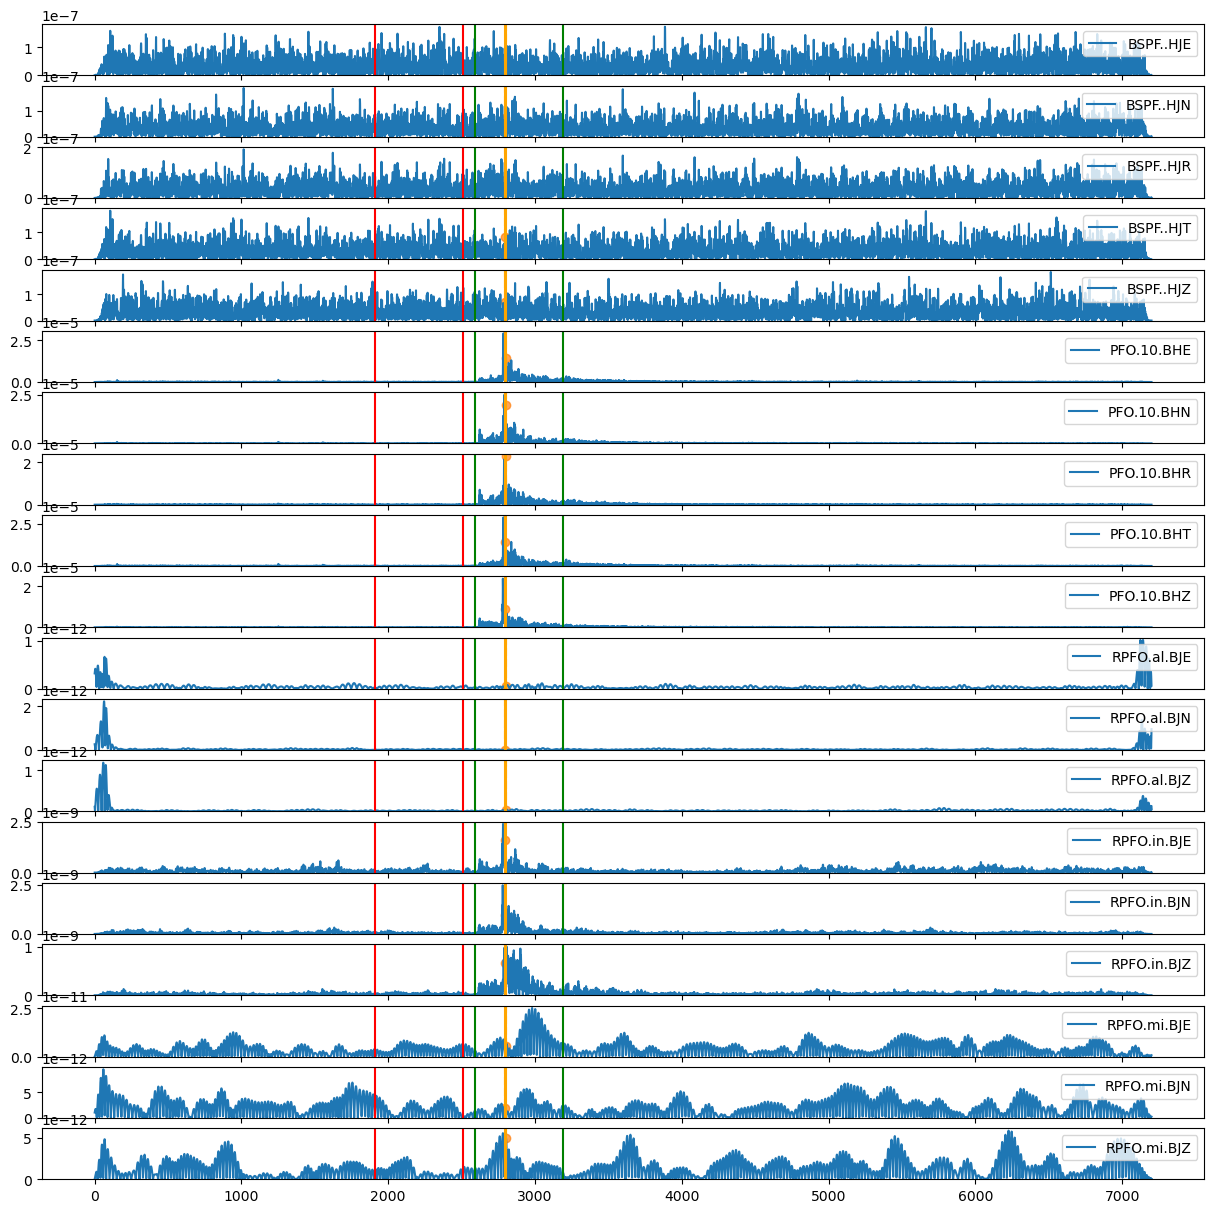

In [17]:
## create dataframe for output
out_df = pd.DataFrame()

out_df["Torigin"] = events.origin
out_df["Magnitude"] = events.magnitude
out_df["CoincidenceSum"] = events.cosum
out_df["Mag_type"] = events.type
out_df["BAZ"] = events.backazimuth
out_df["Edistance_km"] = events.distances_km
out_df["Hdistance_km"] = events.Hdistance_km

tmp_events = [str(ee).split(".")[0] for ee in events.origin]

data_amax, data_snr, data_adr, skipped, nan_row = [], [], [], 0, 0

## pre-define header for data frames
header = ['BSPF__E','BSPF__N','BSPF__R','BSPF__T','BSPF__Z',
          'PFO_10_E','PFO_10_N','PFO_10_R','PFO_10_T','PFO_10_Z',
          'RPFO_al_E','RPFO_al_N','RPFO_al_Z',
          'RPFO_in_E','RPFO_in_N','RPFO_in_Z',
          'RPFO_mi_E','RPFO_mi_N','RPFO_mi_Z'
         ]

## prepare dataframes
header_amax = [h+"_amax" for h in header]
header_amax.insert(0,"origin")
df_amax = pd.DataFrame(columns=header_amax)

header_snr = [h+"_snr" for h in header]
header_snr.insert(0,"origin")
df_snr = pd.DataFrame(columns=header_snr)


header_adr = []
for hh in ["BSPF_a_N_adr", "BSPF_a_E_adr", "BSPF_a_Z_adr", "BSPF_a_T_adr", "BSPF_a_R_adr",
           "BSPF_m_N_adr", "BSPF_m_E_adr", "BSPF_m_Z_adr", "BSPF_m_T_adr", "BSPF_m_R_adr",
           "BSPF_i_N_adr", "BSPF_i_E_adr", "BSPF_i_Z_adr", "BSPF_i_T_adr", "BSPF_i_R_adr",
           "RPFO_in_N_adr", "RPFO_in_E_adr", "RPFO_in_Z_adr",
           "RPFO_al_N_adr", "RPFO_al_E_adr", "RPFO_al_Z_adr",
           "RPFO_mi_N_adr", "RPFO_mi_E_adr", "RPFO_mi_Z_adr"]:
    header_adr.append(hh)

# header_adr = [h+"_adr" for h in header]
header_adr.insert(0, "origin")
df_adr = pd.DataFrame(columns=header_adr)



for event in tqdm(config['mseed_files'][200:201]):

    yy = int(event.replace(".","_").split("_")[1][:4])
    mm = int(event.replace(".","_").split("_")[1][4:6])
    dd = int(event.replace(".","_").split("_")[1][6:8])
    h = int(event.replace(".","_").split("_")[2][0:2])
    m = int(event.replace(".","_").split("_")[2][2:4])
    s = int(event.replace(".","_").split("_")[2][4:6])

    otime = f"{yy}-{mm:02d}-{dd:02d} {h:02d}:{m:02d}:{s:02d}"


    if otime not in tmp_events:
        skipped += 1
        continue
    else:
        jj = tmp_events.index(otime)

#     print(f"\n -> {jj} {events.origin[jj]} ")

    event_name = str(events.origin[jj]).replace("-","").replace(":","").replace(" ", "_").split(".")[0]


    try:
        st = obs.read(config['path_to_mseed']+event)

        st = st.resample(40, no_filter=False)

        for tr in st:
            if "PFOIX" in tr.stats.station:
                tr.stats.station = "PFO"
                tr.stats.location = "10"


        ## add radial and transverse channels
        st = __add_radial_and_transverse_channel(st, "PFO*", events.backazimuth[jj])
        st = __add_radial_and_transverse_channel(st, "BSPF", events.backazimuth[jj])

        if len(st) != 19:
            print(f"{len(st)} is not 19")

        ## processing data stream
        st = st.detrend("linear")
        st = st.taper(0.01)
        st = st.filter("highpass", freq=0.01, corners=4, zerophase=True)

        ## compute maximal amplitude values (PGA and PGR)
        data_amax = __compute_Amax(header, st, data_amax, events.trigger_time[jj], win_length_sec=15)
        row = {**{"origin":events.origin[jj]}, **data_amax}
        df_amax.loc[len(df_amax)] = row

        ## compute signal-to-noise ratios
        data_snr = __compute_SNR(header, st, data_snr, events.trigger_time[jj], win_length_sec=15, plot=True, plot_save=False)
        row = {**{"origin":events.origin[jj]}, **data_snr}
        df_snr.loc[len(df_snr)] = row

        # ## compute signal-to-noise ratios
        # data_adr = __compute_adr_max(header, st, data_adr, events.trigger_time[jj], win_length_sec=15)
        # row = {**{"origin":events.origin[jj]}, **data_adr}
        # df_adr.loc[len(df_adr)] = row

    except Exception as e:
        print(e)
        print(f" -> failed for {event}")
        skipped += 1
        continue



In [18]:
# def __cc_in_octaves(st_in, fmin, fmax):

#     from pandas import DataFrame
#     from functions.get_octave_bands import __get_octave_bands
#     from functions.compute_cc_for_fbands import __compute_cc_for_fbands
    
#     flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")

#     fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

#     ## _____________________

# #     fbands = [(1,5),(2,6),(3,7),(4,8),(5,9),(6,10),(7,11),(8,12),(9,13),(10,14),(11,15),(12,16),(13,17),(14,18)]
# #     fbands = [(1,2),(2,4),(3,6),(4,8),(5,10),(6,12),(7,14),(8,16), (9,18), (10,20)]

#     df_out = DataFrame()
    
#     for comp in ["Z","N","E"]:

#         print(comp)

#         plt.figure(figsize=(15,5))

#         tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
#         tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
#         tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
        
#         ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr2, fbands=fbands, plot=False)
        
#         df_out[f'{comp}_in_fband'] = ff
#         df_out[f'{comp}_in_cc_t'] = cc_t_max
#         df_out[f'{comp}_in_cc_f'] = cc_f_max
        
#         plt.scatter(ff, cc_t_max, color="r")
#         plt.scatter(ff, cc_f_max, color="r")

#         ff, cc_t_max, cc_f_max = __compute_cc_for_fbands(tr1, tr3, fbands=fbands, plot=False)

#         df_out[f'{comp}_al_fband'] = ff
#         df_out[f'{comp}_al_cc_t'] = cc_t_max
#         df_out[f'{comp}_al_cc_f'] = cc_f_max
        
#         plt.scatter(ff, cc_t_max)
#         plt.scatter(ff, cc_f_max) 

#     #     plt.xscale("log")
#         plt.show()
        
#     return df_out


# In[17]:


# def __coherence_in_octaves(st_in, fmin, fmax):

#     from numpy import arange, mean
#     from pandas import DataFrame
#     from functions.get_octave_bands import __get_octave_bands
#     from scipy.signal import coherence
    
#     flower, fupper, fcenter = __get_octave_bands(fmin, fmax, fband_type="one-third-octave")
#     fbands = [(fl, fu) for fl, fu in zip(flower, fupper)]

#     ## _____________________

# #     ddf = 3
# #     fcenter = arange(fmin+ddf, fmax-ddf, 1)
# #     fbands = [(fc - ddf, fc + ddf) for fc in fcenter] 
    
#     df_out = DataFrame()
    
#     fig, ax = plt.subplots(1,3,figsize=(15,5))
    
#     for ii, comp in enumerate(["Z","N","E"]):

#         tr1 = st_in.select(station="BSPF", channel=f'*{comp}')[0]
#         tr2 = st_in.select(station="RPFO", location="in", channel=f'*{comp}')[0]
#         tr3 = st_in.select(station="RPFO", location="al", channel=f'*{comp}')[0]
        
#         co2, co3 = [],[]
#         for (fl, fu) in fbands:
#             s1, s2, s3 = tr1.copy(), tr2.copy(), tr3.copy()
            
#             s1 = s1.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s2 = s2.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
#             s3 = s3.filter("bandpass", freqmin=fl, freqmax=fu, corners=8, zerophase=True)
            
#             s1 = s1.normalize()
#             s2 = s2.normalize()
#             s3 = s3.normalize()

#             s1 = s1.taper(0.1)
#             s2 = s2.taper(0.1)
#             s3 = s3.taper(0.1)
            
#             df = s1.stats.sampling_rate
#             tseg = 1/fl*20
#             nseg = int(df*tseg)
            
# #             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
# #             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann',nperseg=nseg, noverlap=int(0.5*nseg))
#             ff2, coh2 = coherence(s1.data, s2.data, fs=df, window='hann')
#             ff3, coh3 = coherence(s1.data, s3.data, fs=df, window='hann')
        
#             for i in range(len(ff2)):
#                 if ff2[i] < fl or ff2[i] > fu:
#                     coh2[i], coh3[i] = 0, 0
        
# #             plt.figure()
# #             plt.plot(ff2, coh2)
# #             plt.show()
            
#             co2.append(max(coh2))
#             co3.append(max(coh3))
            
#         df_out[f'{comp}_in_fc'] = fcenter
#         df_out[f'{comp}_in_co']  = co2
#         df_out[f'{comp}_al_fc'] = fcenter
#         df_out[f'{comp}_al_co']  = co3
                 
#         ax[ii].scatter(fcenter, co2, s=50, label="BSPF-RPFO_inner")
#         ax[ii].plot(fcenter, co2, ls="-")

#         ax[ii].scatter(fcenter, co3, s=50, label="BSPF-PRFO_all")
#         ax[ii].plot(fcenter, co3, ls="-")

#         ax[ii].set_title(f"max. coherence {comp}")
#         ax[ii].legend()
#         ax[ii].set_xscale("log")
#         ax[ii].grid(ls="--",zorder=0,alpha=.5, which="both")
#     plt.show();
        
#     return df_out


# In[ ]:





# In[ ]:





# ## Manual Selection

In [19]:
date = obs.UTCDateTime("2023-05-20")
events[(events.origin < str((date+86500).date)) & (events.origin > str((date).date))]

,origin,latitude,longitude,depth,magnitude,type,seconds,trigger_time,arrival_time,event_time,cosum,backazimuth,distances_km,Hdistance_km
273,2023-05-20 08:18:16.240,33.382167,-116.906667,12640.0,3.38,ml,19988296.24,2023-05-20T08:18:24.565000Z,2023-05-20T08:18:16.240000Z,2023-05-20T08:18:16.240000Z,6.0,238.977903,48.993538,50.597790
274,2023-05-20 08:20:51.820,33.381833,-116.904000,13440.0,2.61,ml,19988451.82,2023-05-20T08:21:00.235000Z,2023-05-20T08:20:51.820000Z,2023-05-20T08:20:51.820000Z,4.0,238.789573,48.800911,50.617808
275,2023-05-20 12:22:23.130,33.162667,-116.543000,12660.0,1.68,ml,20002943.13,2023-05-20T12:22:31.485000Z,2023-05-20T12:22:23.130000Z,2023-05-20T12:22:23.130000Z,6.0,189.336065,50.349154,51.916403


In [20]:
good_events = [
    "2022-10-03 16:08:09.970",
    "2022-10-07 22:45:05.470",
    "2022-10-15 05:17:34.150",
    "2022-10-23 09:24:58.150",
    "2022-10-26 08:14:35.080",
    "2022-12-31 12:12:26.650",
    "2023-01-09 19:42:56.460",
    "2023-01-11 18:59:20.030",
    "2023-01-15 09:58:54.070",
    "2023-02-01 09:05:02.320",
    "2023-03-01 22:49:03.580",
    "2023-03-24 13:45:13.700",
    "2023-04-10 14:51:00.950",
    "2023-04-17 18:52:36.930",
    "2023-04-26 06:46:58.450",
    "2023-05-03 21:14:20.210",
    "2023-05-20 08:18:16.240",
]

df = pd.DataFrame()
df['origin_time'] = good_events
# df.to_pickle(config['outpath_data']+"event_selection_good.pkl")

In [21]:
from obspy import UTCDateTime

## list of events to reject (manually)
no_event = ["2022-10-05 15:39:13.690", 
            "2022-10-05 15:42:03.610",
            "2022-10-05 18:35:16.860",
            "2022-10-10 05:48:52.890",
            "2022-10-12 19:12:14.670",
            "2022-10-12 23:08:11.410",
            "2022-10-12 23:58:00.800",
            "2022-10-14 03:13:56.380",
            "2022-10-16 08:42:24.970",
            "2022-10-26 08:27:09.860",
            "2022-10-28 12:47:26.910",
            "2022-11-03 05:53:34.230",
            "2022-11-09 00:46:57.550",
            "2022-11-10 16:53:29.940",
            "2022-11-25 10:45:36.390",
            "2022-12-06 21:56:31.330",
            "2022-12-09 06:03:03.220",
            "2022-12-15 13:55:13.460",
            "2022-12-17 18:02:34.910",
            "2022-12-19 15:41:22.380",
            "2022-12-19 15:41:26.020",
            "2023-01-05 09:59:04.210",
            "2023-01-07 12:32:45.250",
            "2023-01-16 00:00:36.100",
            "2023-01-29 23:50:47.770",
            "2023-02-05 23:38:46.670",
            "2023-02-22 05:09:39.970",
            "2023-03-09 11:49:06.640",
            "2023-03-17 07:12:56.970",
            "2023-03-24 13:59:00.160",
            "2023-03-29 19:23:29.470",
            "2023-03-29 19:23:27.460",
            "2023-04-06 02:42:00.600",
            "2023-04-13 23:57:53.950",
            "2023-04-17 15:27:56.450",
            "2023-05-01 02:52:56.160",
            "2023-06-02 20:19:46.740",
            "2023-06-05 07:39:16.650",
           ]

In [22]:
no_event_utc = list(map(UTCDateTime, no_event))


df = pd.DataFrame()
df['origin_time'] = no_event
# df.to_pickle(config['outpath_data']+"event_selection_reject.pkl")